# READING AND PREPROCESSING THE DATA 

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from   scipy.optimize import curve_fit
import torch, torch.nn as nn

torch.set_default_dtype(torch.float64)

path=r"C:\Users\arunj\Downloads\AGS File_Project_A.xlsx"


def clean_column_names(df):
    def _clean(name):
        # 1) Strip whitespace
        name = name.strip()
        # 2) Replace spaces/slashes with underscore
        name = re.sub(r"[ /]+", "_", name)
        # 3) Remove commas, parentheses, percent signs, quotes
        name = re.sub(r"[,\(\)%'\"]+", "", name)
        # 4) Collapse multiple underscores
        name = re.sub(r"_+", "_", name)
        # 5) Lowercase
        return name.lower()
    
    df = df.rename(columns=_clean)
    return df

# Usage
# table2 = clean_column_names(table2)
# Now columns like "Shear Modulus, G (Mpa)" become "shear_modulus_g_mpa"


def cleaning(df_total):
    df_total.columns=df_total.iloc[0]
    df_total.reset_index(inplace=True)
    df_total=df_total.iloc[2:,1:]
    df_total=df_total.dropna(how="all")
    df_total = df_total.loc[:, ~df_total.columns.isna()]
    
    return clean_column_names(df_total)



def reading_data(path):
    df=pd.read_excel(path,"Stiffness and Damping")
    columns=list(df.columns)
    head=columns[0]
    indexes=[]
    for idx, rows in df.iterrows():
        if rows[head]==r"'Exploratory position ID":
            indexes.append(idx)

    idx1=indexes[0]
    idx2=indexes[1]
    
    df_table1=df.iloc[idx1:idx2,:]
    df_table2=df.iloc[idx2:,:]

    return cleaning(df_table1),cleaning(df_table2)

table1, table2=reading_data(path)


table2 = table2.reset_index(drop=True)

# Convert columns to appropriate types
table2["exploratory_position_id"] = table2["exploratory_position_id"].astype("category")
table2["sample_reference"] = table2["sample_reference"].astype("category")
table2["sample_type"] = table2["sample_type"].astype("category")
table2["sample_depth"] = table2["sample_depth"].astype(float)
table2["reading"] = table2["reading"].astype("category")
table2["average_shear_strain"] = table2["average_shear_strain"].astype(float)
table2["shear_modulus_g_mpa"] = table2["shear_modulus_g_mpa"].astype(float)
table2["g_gmax"] = table2["g_gmax"].astype(float)
table2["damping_ratio"] = table2["damping_ratio"].astype(float)

table1=table1.iloc[:-1,:]

# ------------------------------------------------------------------
# table3  ←  SELECT DISTINCT meta‑columns
#            GROUP BY meta‑columns
#            HAVING SUM(average_shear_strain) > 0 
# ------------------------------------------------------------------
meta = ["exploratory_position_id",
        "sample_depth",
        "sample_reference",
        "sample_type"]

table3 = (
    table2
    .groupby(meta, as_index=False)[["average_shear_strain","damping_ratio"]]  # group by the 4 keys
    .mean()                                                  # mean(average_shear_strain)
    .loc[lambda d: d["average_shear_strain"] > 0]           # HAVING … > 0
    .reset_index(drop=True)                                 # clean 0…N‑1 index
)

C:\Users\arunj\AppData\Local\Temp\ipykernel_49096\349987635.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(meta, as_index=False)[["average_shear_strain","damping_ratio"]]  # group by the 4 keys


# Analysis of all the reading for a given sample and extracting the stress-strain curve from instantaneous shear modulus and strain

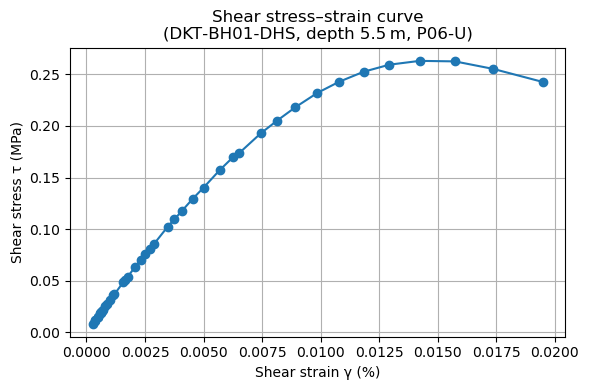

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


mask = (
    (table2["exploratory_position_id"] == "DKT-BH01-DHS") &
    (table2["sample_depth"]            == 5.5)            &
    (table2["sample_reference"]        == "P06")          &
    (table2["sample_type"]             == "U")
)
specimen = table2.loc[mask].copy()

# 3 ─ compute shear stress  τ = G · γ
#     G in MPa, γ dimensionless  → τ in MPa

specimen["shear_stress_mpa"] = (
    specimen["shear_modulus_g_mpa"] *
    specimen["average_shear_strain"]
)


plt.figure(figsize=(6, 4))
plt.plot(
    specimen["average_shear_strain"],   # x‑axis in %
    specimen["shear_stress_mpa"], "-o"
)
plt.xlabel("Shear strain γ (%)")
plt.ylabel("Shear stress τ (MPa)")
plt.title("Shear stress–strain curve\n(DKT‑BH01‑DHS, depth 5.5 m, P06‑U)")
plt.grid(True)
plt.tight_layout()
plt.show()

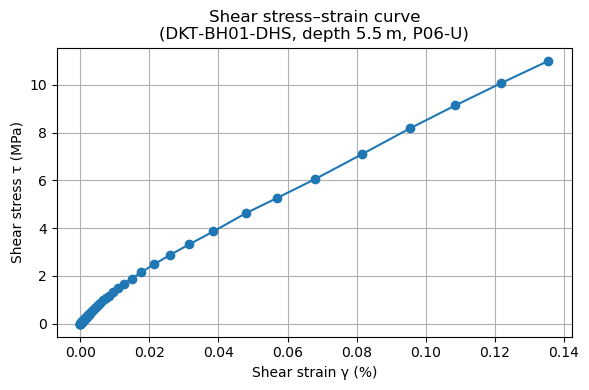

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


mask = (
    (table2["exploratory_position_id"] == "DKT-BH04-DHS") &
    (table2["sample_depth"]            == 31.8)            &
    (table2["sample_reference"]        == "B04")
)
specimen = table2.loc[mask].copy()

# 3 ─ compute shear stress  τ = G · γ
#     G in MPa, γ dimensionless  → τ in MPa

specimen["shear_stress_mpa"] = (
    specimen["shear_modulus_g_mpa"] *
    specimen["average_shear_strain"]
)


plt.figure(figsize=(6, 4))
plt.plot(
    specimen["average_shear_strain"],   # x‑axis in %
    specimen["shear_stress_mpa"], "-o"
)
plt.xlabel("Shear strain γ (%)")
plt.ylabel("Shear stress τ (MPa)")
plt.title("Shear stress–strain curve\n(DKT‑BH01‑DHS, depth 5.5 m, P06‑U)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Reason for predicting the failure stress and maxshear modulus, since there are samples that does not cover the max stress point. Therefore we need to extrapolate based on our sample readings. To do this we use Hyperbolic equation integrated with PINN to ensure ideal fit

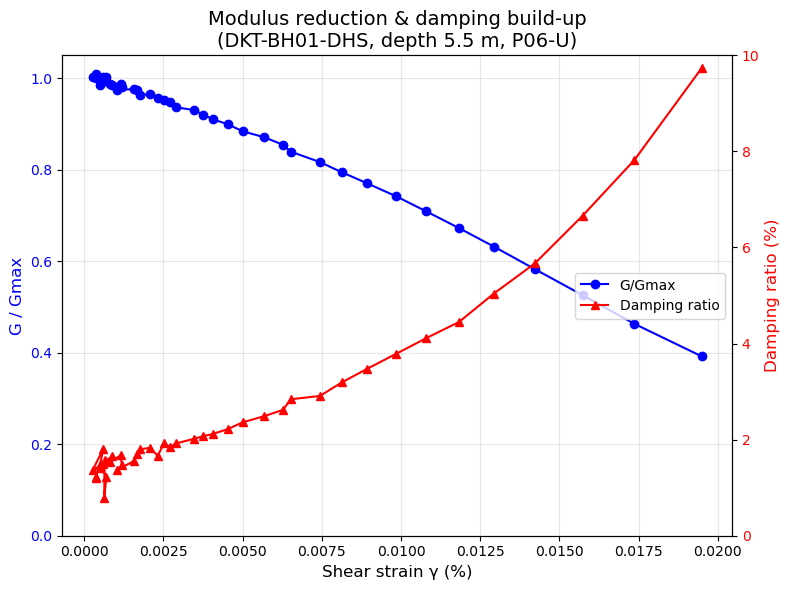

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Isolate the specimen
mask = (
    (table2["exploratory_position_id"] == "DKT-BH01-DHS") &
    (table2["sample_depth"]            == 5.5)            &
    (table2["sample_reference"]        == "P06")          &
    (table2["sample_type"]             == "U")
)
spec = table2.loc[mask].copy()

# Basic conversions
spec["gamma_frac"] = spec["average_shear_strain"]        # % → fraction
spec["tau_mpa"] = spec["shear_modulus_g_mpa"] * spec["average_shear_strain"] 

# Modulus reduction (G/Gmax) & damping ratio
Gmax = spec["shear_modulus_g_mpa"].iloc[0]               # first cycle ≈ Gmax
spec["G_Gmax"] = spec["shear_modulus_g_mpa"] / Gmax
spec["D_percent"] = spec["damping_ratio"]                # already %

# Create the plot with twin y-axes
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot G/Gmax on left y-axis
ax1.plot(spec["average_shear_strain"], spec["G_Gmax"], "bo-", label="G/Gmax", markersize=6)
ax1.set_xlabel("Shear strain γ (%)", fontsize=12)
ax1.set_ylabel("G / Gmax", color="b", fontsize=12)
ax1.tick_params(axis="y", labelcolor="b")
ax1.set_ylim(0, 1.05)
ax1.grid(True, alpha=0.3)

# Create right y-axis for damping ratio
ax2 = ax1.twinx()
ax2.plot(spec["average_shear_strain"], spec["D_percent"], "r^-", label="Damping ratio", markersize=6)
ax2.set_ylabel("Damping ratio (%)", color="r", fontsize=12)
ax2.tick_params(axis="y", labelcolor="r")
ax2.set_ylim(0, 10)  # Set appropriate limits for damping ratio

# Add title and adjust layout
plt.title("Modulus reduction & damping build-up\n(DKT-BH01-DHS, depth 5.5 m, P06-U)", fontsize=14)
fig.tight_layout()

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.show()

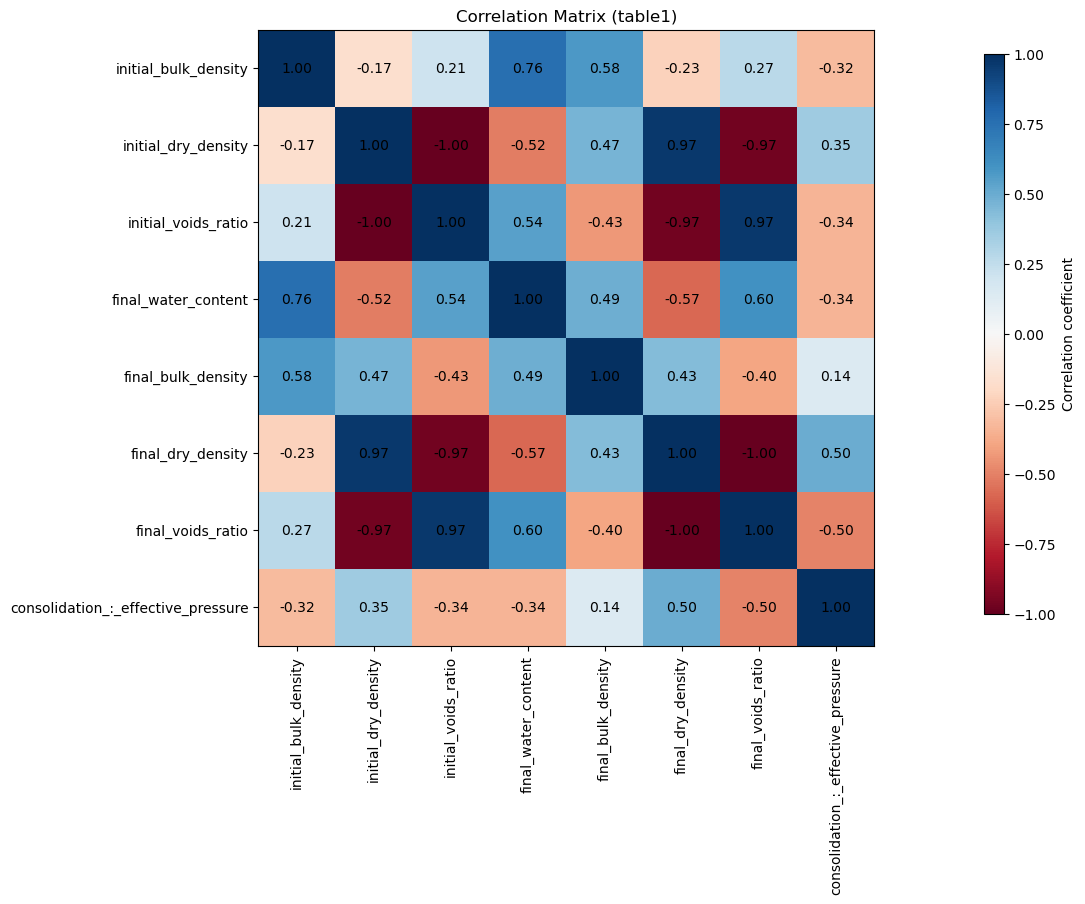

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---- CONFIG ----
metadata_cols = [
    "exploratory_position_id",
    "sample_depth",
    "sample_reference",
    "sample_type",
    "sample_condition",
]

# ---- CLEAN + CONVERT ----
# 1) Remove metadata columns (ignore if missing)
df = table1.drop(columns=metadata_cols, errors="ignore").copy()

# 2) Convert every remaining column to float (coerce)
for col in df.columns:
    # Optional pre-clean: strip spaces; remove common non-numeric chars
    if df[col].dtype == "object":
        df[col] = df[col].astype(str).str.strip().str.replace(",", "", regex=False)
    df[col] = pd.to_numeric(df[col], errors="coerce")

# After conversion, keep only columns that are not entirely NaN
df = df.loc[:, df.notna().any(axis=0)]

# Drop rows that are all-NaN across the remaining (numeric) columns
df = df.dropna(how="all")

# ---- CORRELATION + PLOT ----
if df.shape[1] < 2 or df.notna().sum().sum() == 0:
    print("Not enough numeric data to compute a correlation matrix after conversion.")
else:
    corr = df.corr(numeric_only=True)

    # If correlation still ends up empty (e.g., all constant columns), handle it
    if corr.size == 0 or corr.shape[0] < 2:
        print("Correlation matrix is empty or degenerate (e.g., constant columns).")
    else:
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(corr, cmap="RdBu", interpolation="none", vmin=-1, vmax=1)

        # Axis ticks
        ax.set_xticks(range(len(corr)))
        ax.set_yticks(range(len(corr)))
        ax.set_xticklabels(corr.columns, rotation=90)
        ax.set_yticklabels(corr.columns)
        ax.set_title("Correlation Matrix (table1)")

        # Numbers inside each block
        for i in range(len(corr)):
            for j in range(len(corr)):
                ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", color="black")

        # Colorbar outside (prevents overlap)
        fig.subplots_adjust(right=0.88)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        fig.colorbar(im, cax=cbar_ax, label="Correlation coefficient")

        plt.show()

# Trying to predict the stress-strain relationship, max shear modulus and failure stress for each sample from table2 and then analyze the results with table1 that contains the intrinsic properties

# 1. build table3 (distinct metadata)

In [11]:
# ───────────────────────── 1. build table3 (distinct metadata) ──────────
meta_cols = ["exploratory_position_id",
             "sample_depth",
             "sample_reference",
             "sample_type"]

table3 = (
    table2
    .groupby(meta_cols, as_index=False)[["average_shear_strain","damping_ratio"]]
    .mean()
    .loc[lambda d: d["average_shear_strain"] > 0]
    .reset_index(drop=True)
)

# ─── add columns to hold PINN outputs + counts ──────────────────────────
# Core PINN outputs:
table3["tou_f"]                  = np.nan
# (failure_stress renamed later)
table3["predicted_g_max"]        = np.nan
# raw modulus comparison:
table3["max_shear_modulus_g_mpa"]= np.nan
# fit error percentage:
table3["error_pct"]              = np.nan
# count of readings for quality check:
table3["n_readings"]             = np.nan   # new column

# --- Additional constitutive parameters ---
# Compute and add the PINN’s curvature exponent 'c' parameter:
table3["c_param"] = np.nan

# Compute G/Gmax reduction at fixed strains (e.g., 0.01%, 0.1%, 1%):
fixed_strains = [0.0001, 0.001, 0.01]
for eps in fixed_strains:
    table3[f"GoverGmax_{eps}"] = np.nan
# Merge soil-index and stratigraphic data from table1 later
# Link to design/use-case (e.g., Vs for Eurocode) later

C:\Users\arunj\AppData\Local\Temp\ipykernel_49096\807152762.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(meta_cols, as_index=False)[["average_shear_strain","damping_ratio"]]


# CASE 1: Using algebraic equation

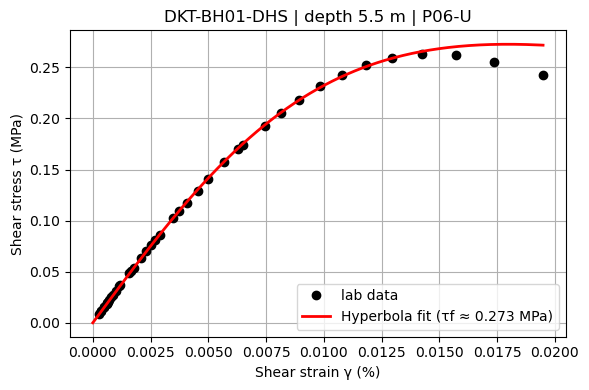

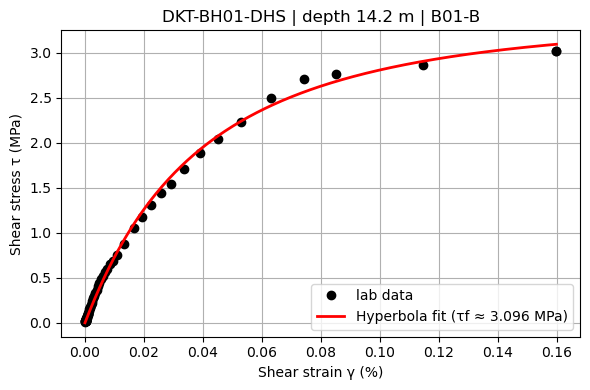

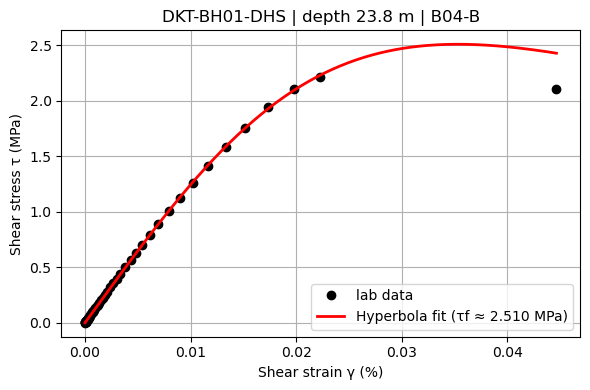

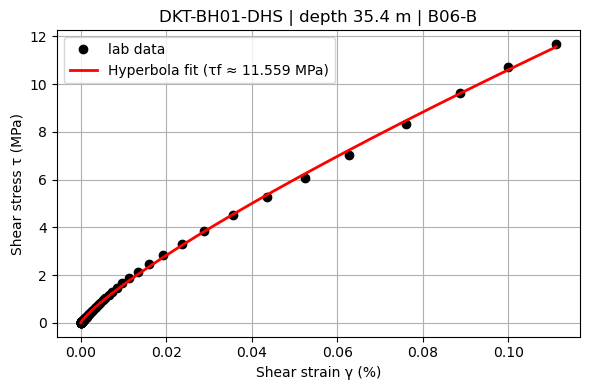

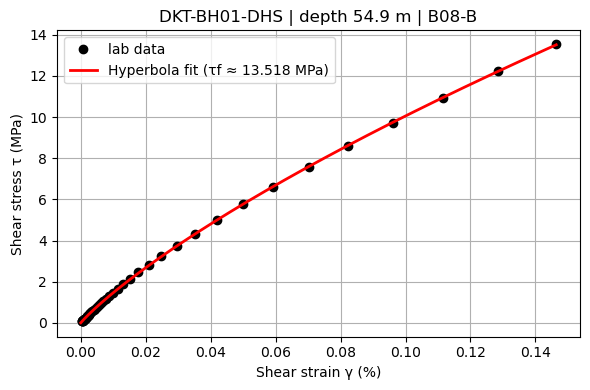

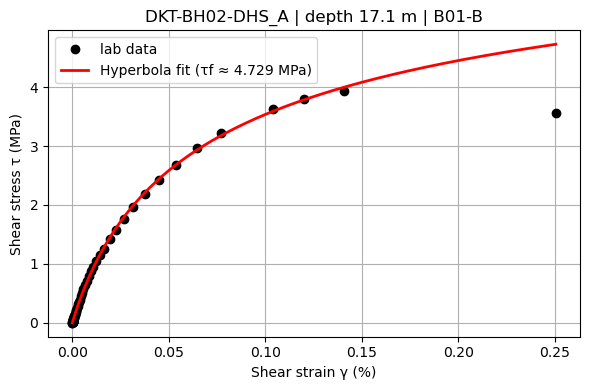

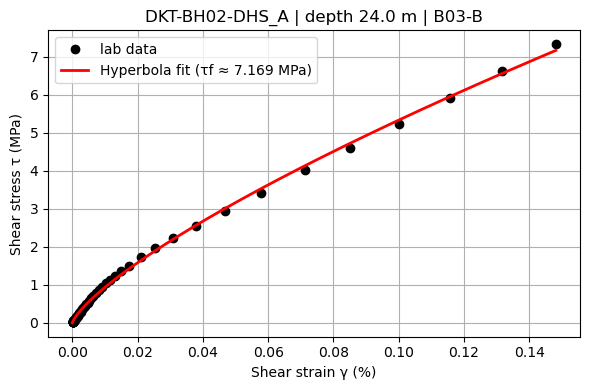

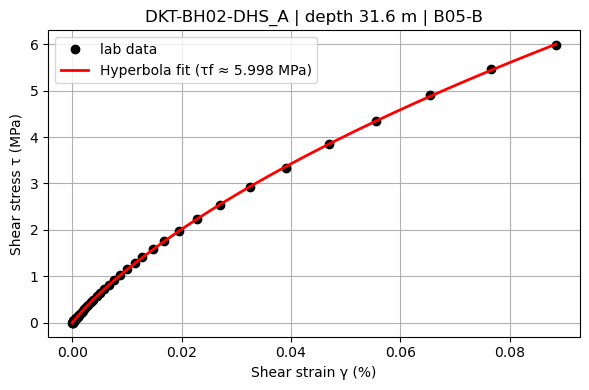

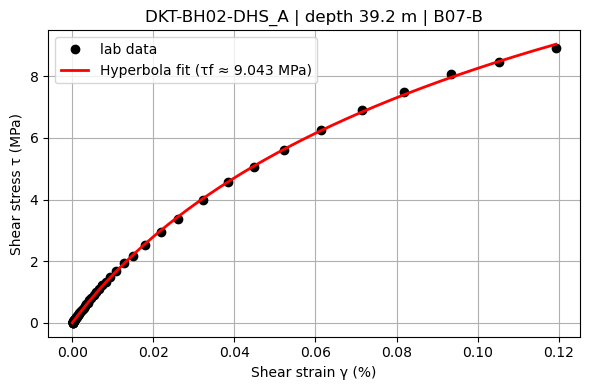

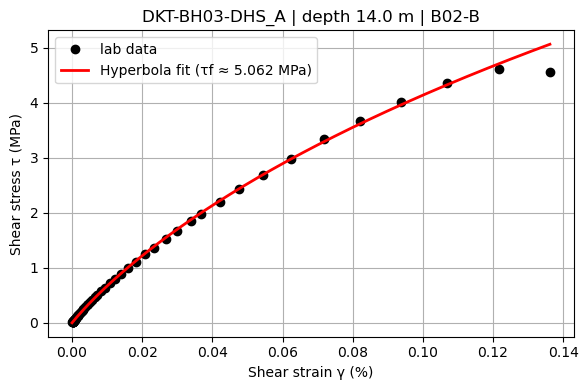

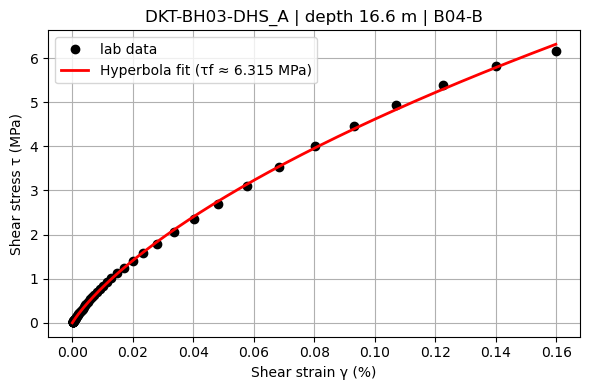

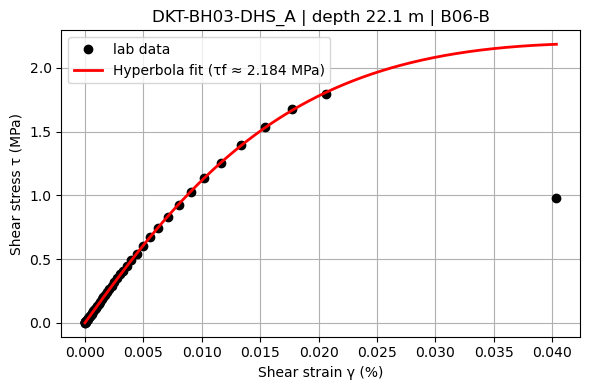

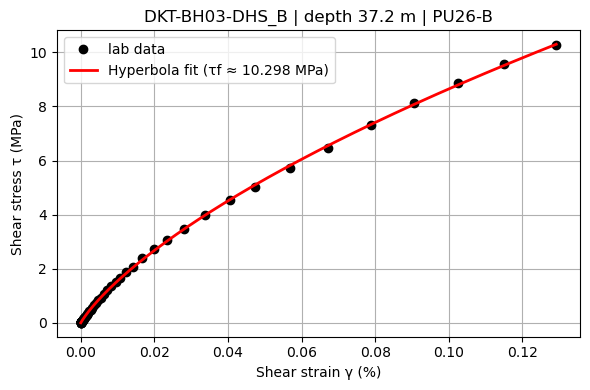

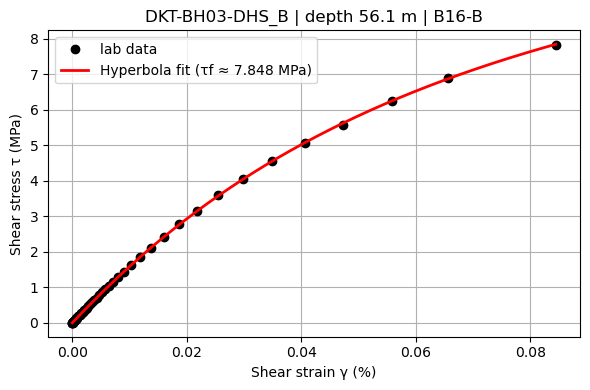

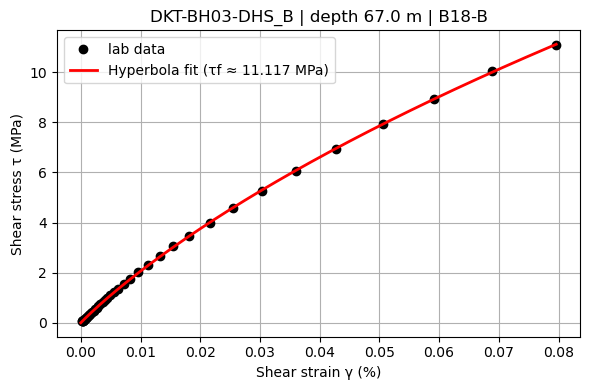

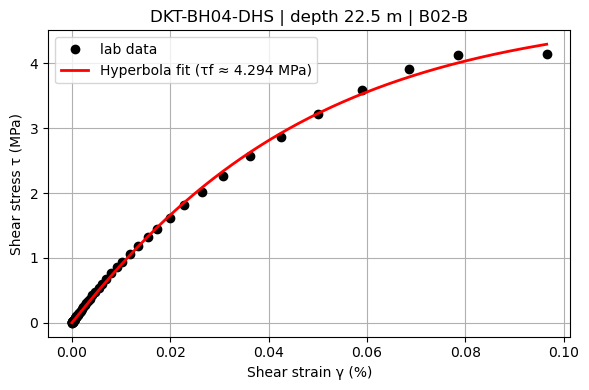

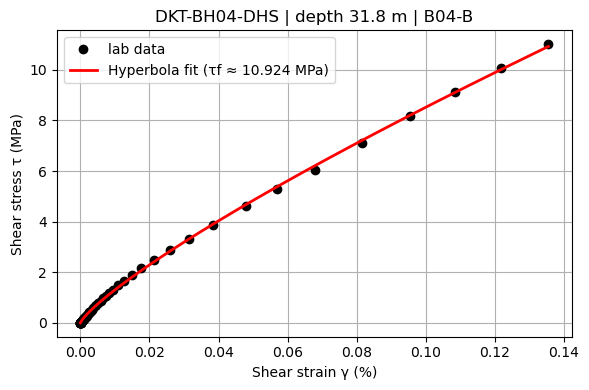

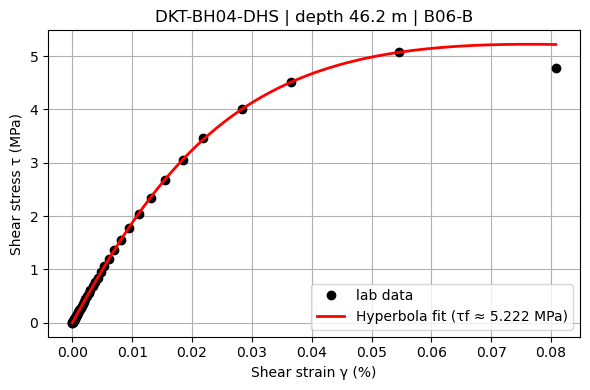

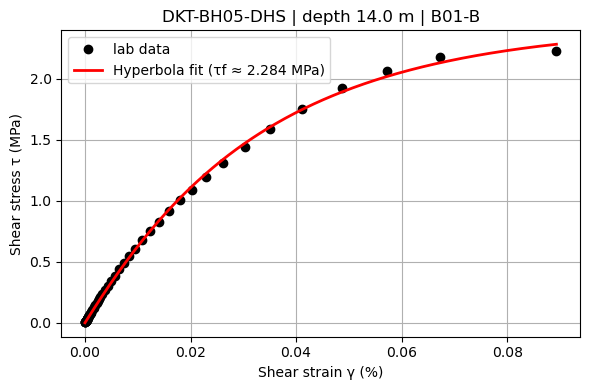

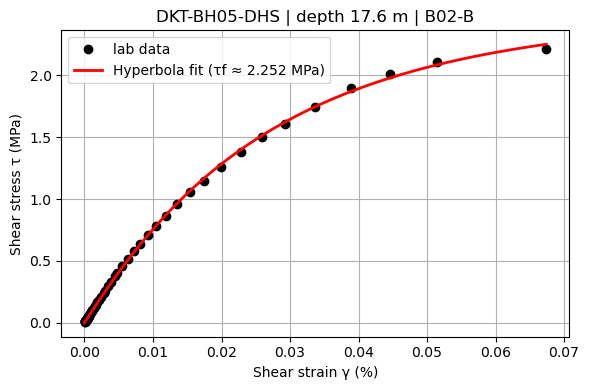

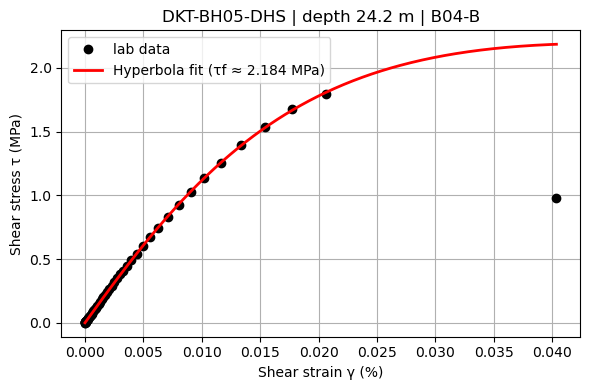

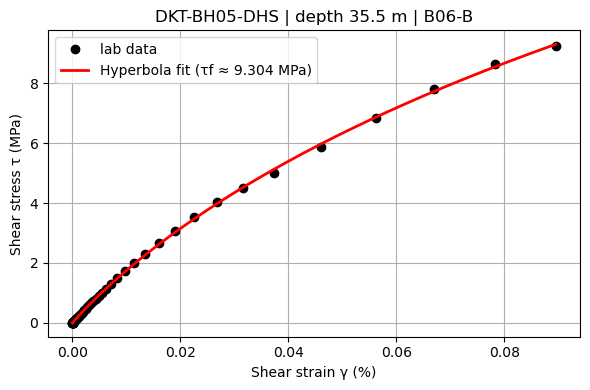

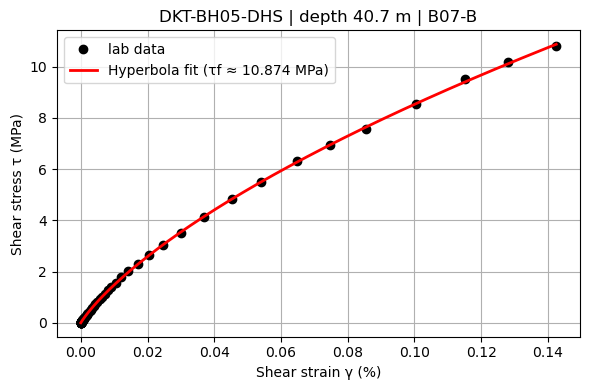

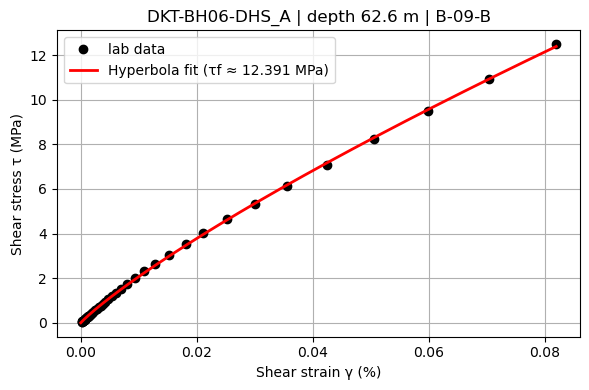

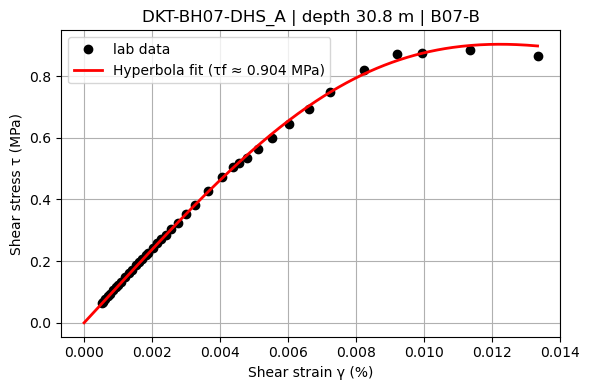

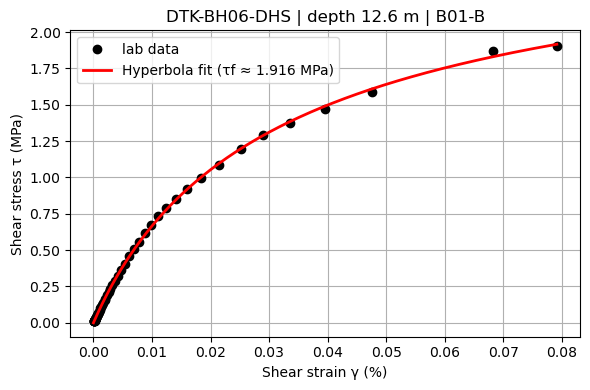

C:\Users\arunj\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


exploratory_position_id  sample_depth sample_reference sample_type  \
0             DKT-BH01-DHS           5.5              P06           U   
1             DKT-BH01-DHS          14.2              B01           B   
2             DKT-BH01-DHS          23.8              B04           B   
3             DKT-BH01-DHS          35.4              B06           B   
4             DKT-BH01-DHS          54.9              B08           B   
5           DKT-BH02-DHS_A          17.1              B01           B   
6           DKT-BH02-DHS_A          24.0              B03           B   
7           DKT-BH02-DHS_A          31.6              B05           B   
8           DKT-BH02-DHS_A          39.2              B07           B   
9           DKT-BH03-DHS_A          14.0              B02           B   
10          DKT-BH03-DHS_A          16.6              B04           B   
11          DKT-BH03-DHS_A          22.1              B06           B   
12          DKT-BH03-DHS_B          37.2             PU26           B   
13          DKT-BH03-DHS_B          56.1              B16           B   
14          DKT-BH03-DHS_B          67.0              B18           B   
15            DKT-BH04-DHS          22.5              B02           B   
16            DKT-BH04-DHS          31.8              B04           B   
17            DKT-BH04-DHS          46.2              B06           B   
18            DKT-BH05-DHS          14.0              B01           B   
19            DKT-BH05-DHS          17.6              B02           B   
20            DKT-BH05-DHS          24.2              B04           B   
21            DKT-BH05-DHS          35.5              B06           B   
22            DKT-BH05-DHS          40.7              B07           B   
23          DKT-BH06-DHS_A          62.6             B-09           B   
24          DKT-BH07-DHS_A          30.8              B07           B   
25            DTK-BH06-DHS          12.6              B01           B   
26            DTK-BH06-DHS          26.2              B05           B   

    n_readings  failure_stress  predicted_g_max  damping_ratio   c_param  \
0         42.0        0.272620        30.627469       2.644762  1.983411   
1         60.0        3.096349        84.763586       2.235167  1.099181   
2         57.0        2.509783       131.115281       0.131930  2.184078   
3         67.0       11.558886      1476.454342       0.731940  0.195236   
4         47.0       13.517628       199.175960       0.955745  0.434711   
5         63.0        4.728559       111.053063       2.104921  0.898548   
6         65.0        7.169223      1189.509649       1.371231  0.258927   
7         62.0        5.998209       160.143074       0.930968  0.562761   
8         67.0        9.042520       181.033068       1.137164  0.867018   
9         62.0        5.061939        79.845233       2.344194  0.682744   
10        65.0        6.315358       119.190192       1.760000  0.517744   
11        56.0        2.184164       127.082001       0.271607  1.631568   
12        67.0       10.298155       264.522083       1.391642  0.463140   
13        65.0        7.847531       170.540997       0.392923  1.131002   
14        47.0       11.116659       251.378849       0.440213  0.621291   
15        61.0        4.293542        94.044143       1.060984  1.352823   
16        67.0       10.923805     -1951.338779       1.090149  0.175112   
17        63.0        5.222142       205.097411       0.343651  1.501608   
18        57.0        2.284157        68.962060       1.460526  1.293946   
19        57.0        2.252440        86.982844       1.024035  1.243921   
20        56.0        2.184164       127.081998       0.271607  1.631569   
21        66.0        9.304444       206.524897       0.519242  0.769406   
22        67.0       10.874041       231.774728       1.179851  0.481629   
23        47.0       12.391037       325.813795       0.391277  0.332642   
24        40.0        0.903508       119.508175       6.07

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the hyperbola function exactly as in your example
def hyper(g, a, b, c):
    return g / (a + b * g**c)

# Only these three strain levels for G/Gmax calculation
fixed_strains = [0.0001, 0.001, 0.01]

# Check if 'average_shear_strain' exists in table3 before trying to drop it
if 'average_shear_strain' in table3.columns:
    table3 = table3.drop(columns=["average_shear_strain"])

# Iterate through each metadata combination
for idx, meta in table3.iterrows():
    # Create filter mask for this metadata combination
    mask = (
        (table2["exploratory_position_id"] == meta["exploratory_position_id"]) &
        (table2["sample_depth"] == meta["sample_depth"]) &
        (table2["sample_reference"] == meta["sample_reference"]) &
        (table2["sample_type"] == meta["sample_type"])
    )
    
    # Filter and prepare data
    df_sub = table2.loc[mask].copy()
    df_sub = df_sub[df_sub["average_shear_strain"] > 0]  # Keep positive γ
    
    # Record total readings
    n_reads = len(df_sub)
    table3.at[idx, "n_readings"] = n_reads
    
    if n_reads < 4:
        continue
    
    # Extract and convert data
    γ = df_sub["average_shear_strain"].astype(float).values  # fraction
    τ = df_sub["shear_modulus_g_mpa"].astype(float).values * γ  # MPa
    
    # Record the group's max raw modulus
    G_raw_max = df_sub["shear_modulus_g_mpa"].max()
    table3.at[idx, "max_shear_modulus_g_mpa"] = G_raw_max
    
    # Identify rising branch (up to peak stress)
    pk = τ.argmax()
    γ_r, τ_r = γ[:pk+1], τ[:pk+1]
    τ_peak = τ_r[-1]
    
    # Initial parameter estimates
    p0 = [1/df_sub["shear_modulus_g_mpa"].iloc[0], 1/τ_peak, 0.5]
    
    try:
        # Fit hyperbola to rising branch data
        params, _ = curve_fit(
            hyper, γ_r, τ_r,
            p0=p0
        )
        a, b, c = params
    except RuntimeError:
        continue
    
    # Calculate failure stress (maximum of fitted curve)
    γ_plot = np.linspace(0, γ.max(), 300)
    τ_plot = hyper(γ_plot, a, b, c)
    τ_f = τ_plot.max()
    
    # Calculate maximum shear modulus
    G_max = 1/a
    
    # Calculate error percentage
    error_pct = (G_max - G_raw_max) / G_raw_max * 100
    
    # Store results in table3
    table3.at[idx, "tou_f"] = τ_f
    table3.at[idx, "predicted_g_max"] = G_max
    table3.at[idx, "error_pct"] = error_pct
    table3.at[idx, "c_param"] = c
    
    # Calculate G/Gmax at the three specific reference strains
    for eps in fixed_strains:
        # Calculate shear modulus at this strain
        τ_at_eps = hyper(eps, a, b, c)
        G_at_eps = τ_at_eps / eps if eps > 0 else G_max
        
        # Calculate G/Gmax ratio
        G_over_Gmax = G_at_eps / G_max
        table3.at[idx, f"GoverGmax_{eps}"] = G_over_Gmax
    
    # Generate plot
    plt.figure(figsize=(6, 4))
    plt.plot(γ, τ, "ko", label="lab data")
    plt.plot(γ_plot, τ_plot, "r-", linewidth=2,
             label=f"Hyperbola fit (τf ≈ {τ_f:.3f} MPa)")
    
    title = (f"{meta['exploratory_position_id']} | depth {meta['sample_depth']} m | "
             f"{meta['sample_reference']}-{meta['sample_type']}")
    plt.title(title)
    plt.xlabel("Shear strain γ (%)")
    plt.ylabel("Shear stress τ (MPa)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Final table processing - only rename the column
table3 = table3.rename(columns={"tou_f": "failure_stress"})

# Create additional tables as needed
table4 = table3[["exploratory_position_id", "sample_depth", 
                 "sample_reference", "sample_type", "failure_stress", 
                 "predicted_g_max", "c_param"]].copy()

# Create table5 with only the three G/Gmax values
strain_columns = [f"GoverGmax_{eps}" for eps in fixed_strains]
table5 = table3[["exploratory_position_id", "sample_depth", 
                 "sample_reference", "sample_type"] + strain_columns].copy()

# Create final summary table
final2 = pd.DataFrame({
    "parameter": ["G_max", "τ_f", "c"],
    "mean_value": [
        table3["predicted_g_max"].mean(),
        table3["failure_stress"].mean(),
        table3["c_param"].mean()
    ],
    "std_value": [
        table3["predicted_g_max"].std(),
        table3["failure_stress"].std(),
        table3["c_param"].std()
    ]
})



# 1. define the columns you want from the summary (previously table3) and from table1
t3_cols = [
    "exploratory_position_id",
    "sample_depth",
    "sample_reference",
    "sample_type",
    "n_readings",
    "failure_stress",
    "predicted_g_max",
    "damping_ratio",
    "max_shear_modulus_g_mpa",
    "error_pct",
    'c_param',
    'GoverGmax_0.0001', 'GoverGmax_0.001', 'GoverGmax_0.01'
]
t1_cols = [
    "exploratory_position_id",
    "sample_depth",
    "sample_reference",
    "sample_type",
    "initial_bulk_density",
    "initial_dry_density",
    "initial_voids_ratio",
    "final_water_content",
    "final_bulk_density",
    "final_dry_density",
    "final_voids_ratio",
    "consolidation_:_effective_pressure"
]

# 2. slice out only those columns
t3_sel = table3[t3_cols]
t1_sel = table1[t1_cols]

# 3. perform the outer join on the four metadata keys
final = pd.merge(
    t3_sel,
    t1_sel,
    on=["exploratory_position_id", "sample_depth", "sample_reference", "sample_type"],
    how="outer",
)

final['max_shear_modulus_g_mpa']=final['max_shear_modulus_g_mpa'].astype(float)
final['initial_bulk_density']=final['initial_bulk_density'].astype(float)

#CHANGEEEEEEEEEEEEEEEEEEEEEEEEE HEREEEE.........
final['vs_avg'] = np.sqrt((final['predicted_g_max'] * 1e6) / (final['initial_bulk_density'] * 1000))

cols_to_drop = ["max_shear_modulus_g_mpa", "error_pct"]
final = final.drop(columns=[c for c in cols_to_drop if c in final.columns])

for i in final.columns:
    if i not in ['exploratory_position_id','sample_reference','sample_type']:
        final[i]=final[i].astype(float)
        
final

In [14]:
table_algebra=table3.copy()
final_algebra=final.copy()

In [15]:
# ───────────────────────── 1. build table3 (distinct metadata) ──────────
meta_cols = ["exploratory_position_id",
             "sample_depth",
             "sample_reference",
             "sample_type"]

table3 = (
    table2
    .groupby(meta_cols, as_index=False)[["average_shear_strain","damping_ratio"]]
    .mean()
    .loc[lambda d: d["average_shear_strain"] > 0]
    .reset_index(drop=True)
)

# ─── add columns to hold PINN outputs + counts ──────────────────────────
# Core PINN outputs:
table3["tou_f"]                  = np.nan
# (failure_stress renamed later)
table3["predicted_g_max"]        = np.nan
# raw modulus comparison:
table3["max_shear_modulus_g_mpa"]= np.nan
# fit error percentage:
table3["error_pct"]              = np.nan
# count of readings for quality check:
table3["n_readings"]             = np.nan   # new column

# --- Additional constitutive parameters ---
# Compute and add the PINN’s curvature exponent 'c' parameter:
table3["c_param"] = np.nan

# Compute G/Gmax reduction at fixed strains (e.g., 0.01%, 0.1%, 1%):
fixed_strains = [0.0001, 0.001, 0.01]
for eps in fixed_strains:
    table3[f"GoverGmax_{eps}"] = np.nan
# Merge soil-index and stratigraphic data from table1 later
# Link to design/use-case (e.g., Vs for Eurocode) later

C:\Users\arunj\AppData\Local\Temp\ipykernel_49096\807152762.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(meta_cols, as_index=False)[["average_shear_strain","damping_ratio"]]


# 3. add columns to hold PINN outputs + counts 

## Creating a PINN model using the hyperbolic stress-strain relationship
$ \tau(\gamma) = \dfrac{\gamma}{a + b\,\gamma^{c}} $ 

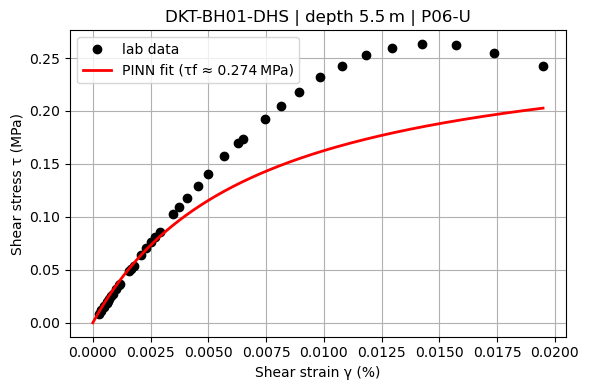

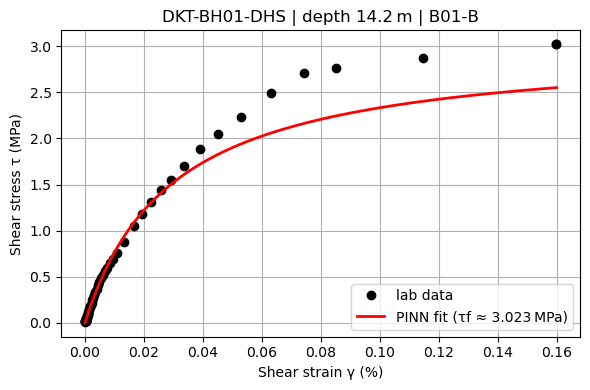

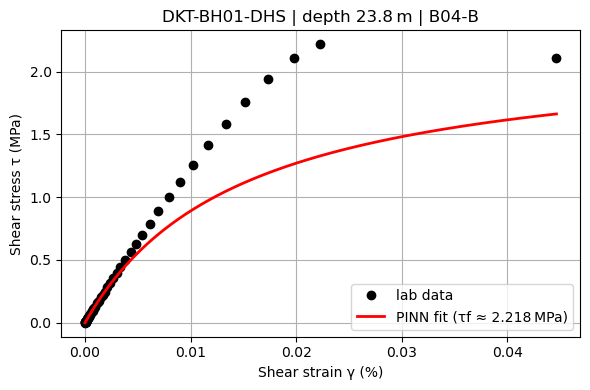

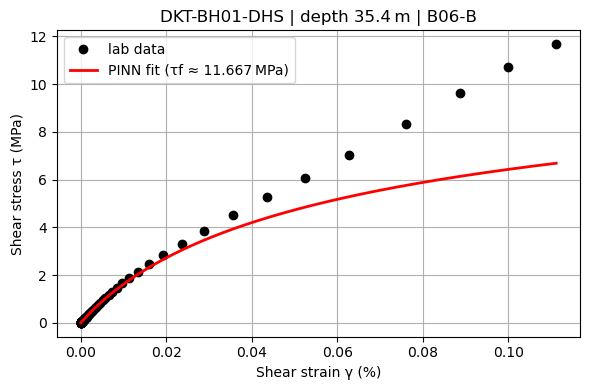

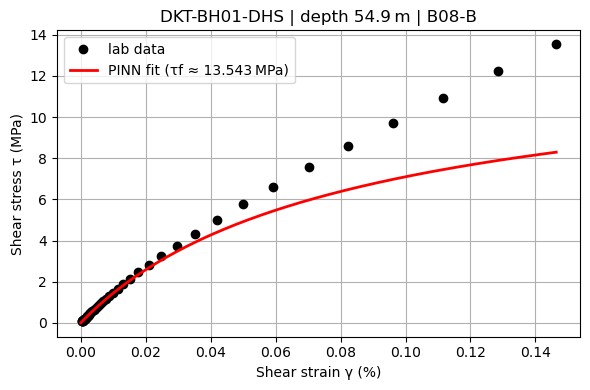

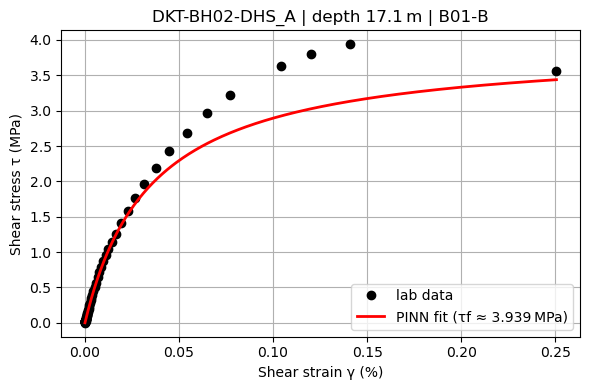

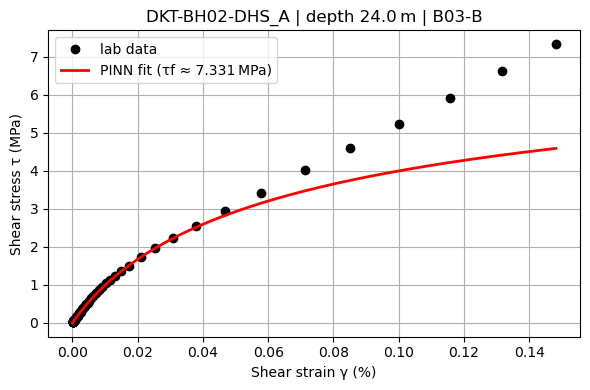

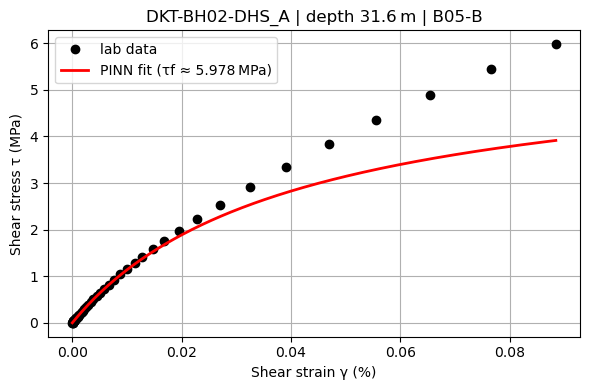

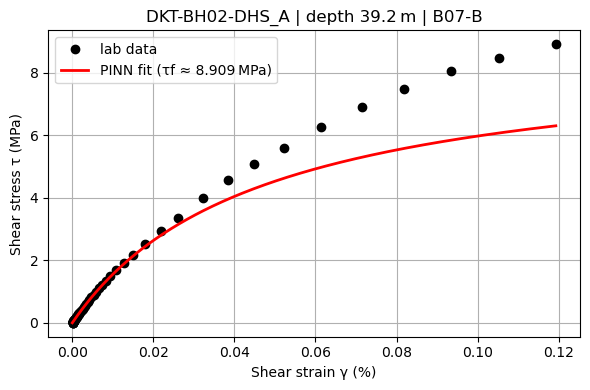

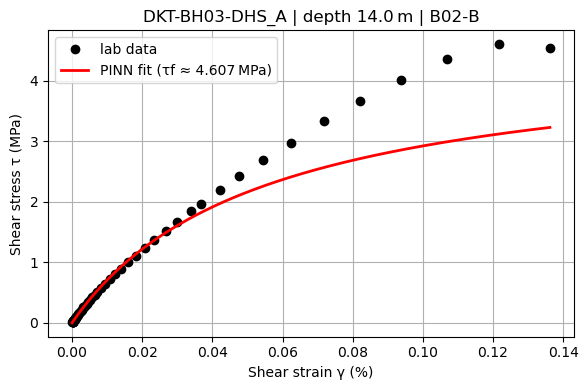

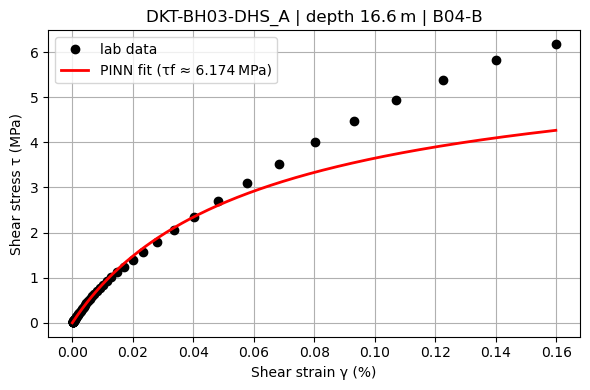

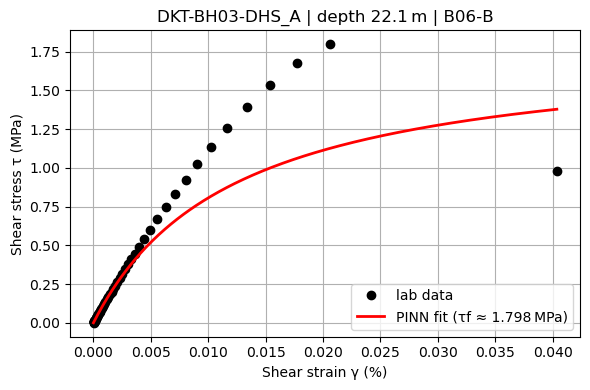

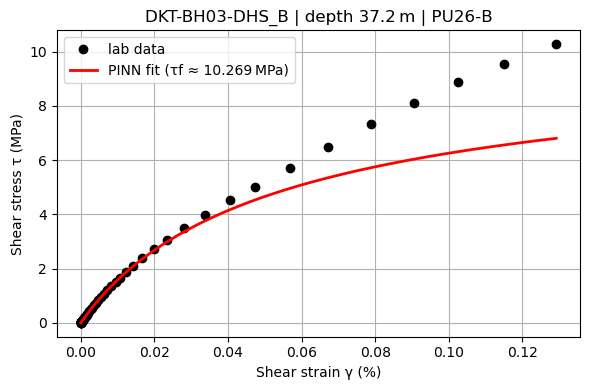

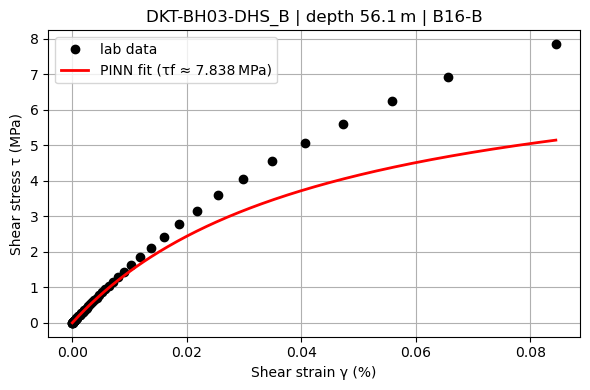

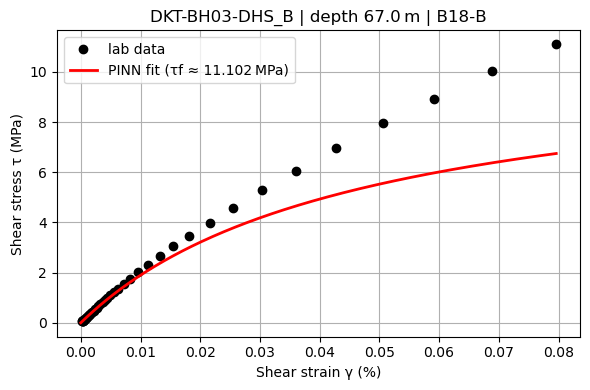

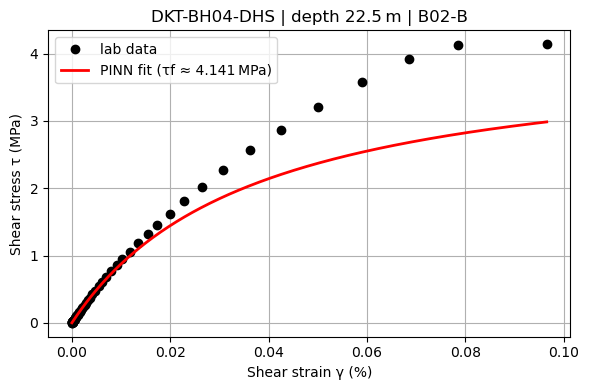

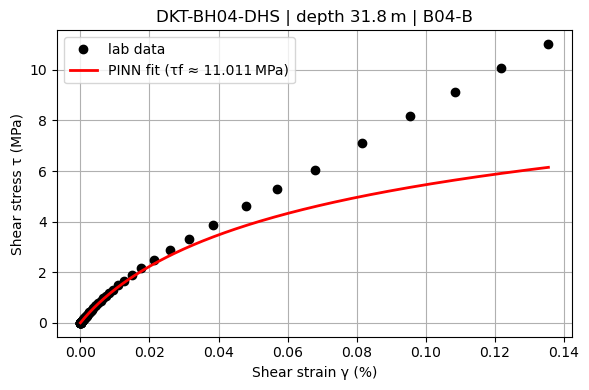

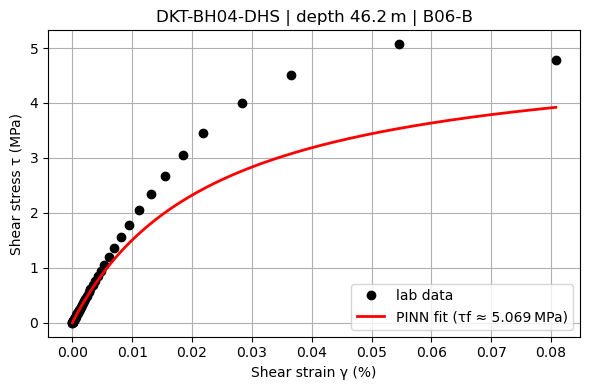

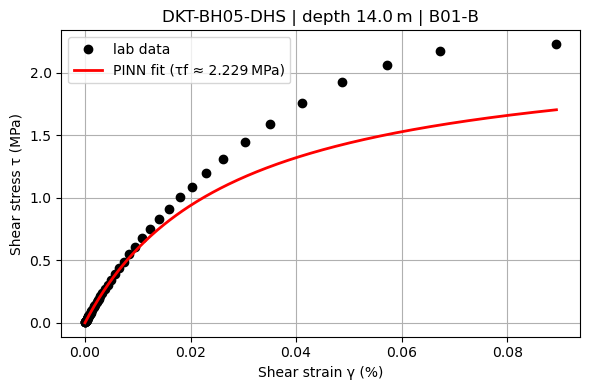

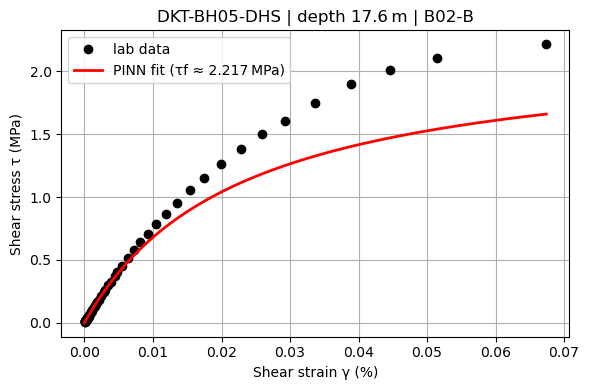

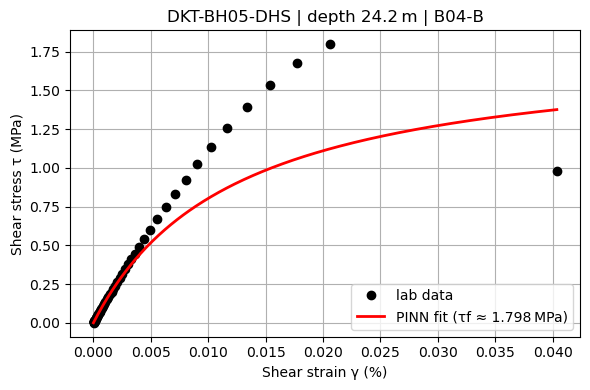

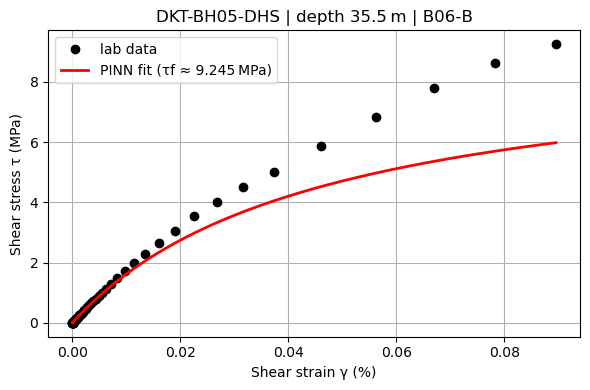

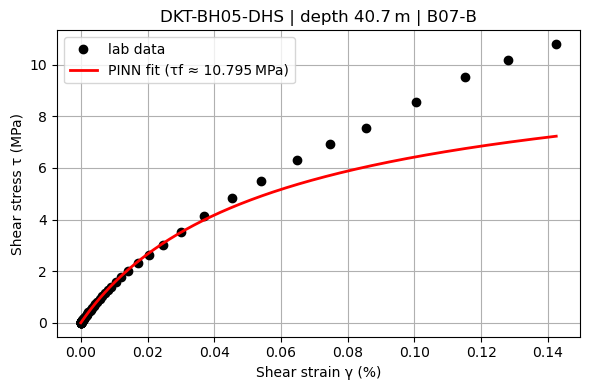

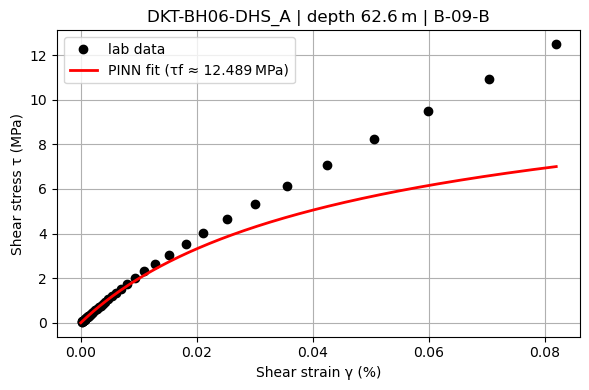

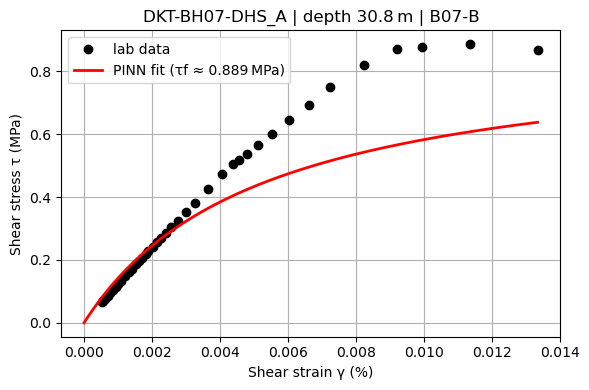

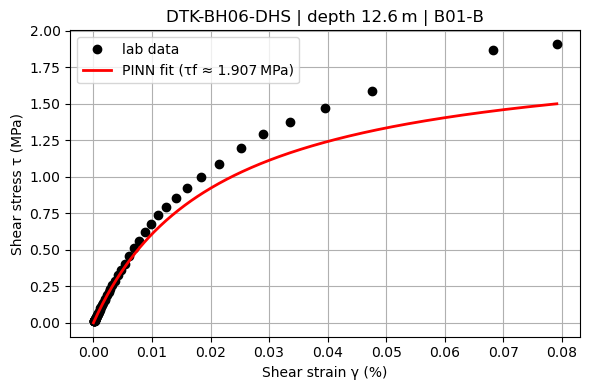

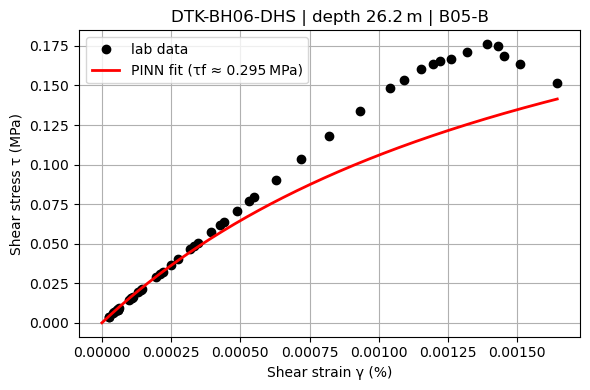

exploratory_position_id  sample_depth sample_reference sample_type  \
0             DKT-BH01-DHS           5.5              P06           U   
1             DKT-BH01-DHS          14.2              B01           B   
2             DKT-BH01-DHS          23.8              B04           B   
3             DKT-BH01-DHS          35.4              B06           B   
4             DKT-BH01-DHS          54.9              B08           B   
5           DKT-BH02-DHS_A          17.1              B01           B   
6           DKT-BH02-DHS_A          24.0              B03           B   
7           DKT-BH02-DHS_A          31.6              B05           B   
8           DKT-BH02-DHS_A          39.2              B07           B   
9           DKT-BH03-DHS_A          14.0              B02           B   
10          DKT-BH03-DHS_A          16.6              B04           B   
11          DKT-BH03-DHS_A          22.1              B06           B   
12          DKT-BH03-DHS_B          37.2             PU26           B   
13          DKT-BH03-DHS_B          56.1              B16           B   
14          DKT-BH03-DHS_B          67.0              B18           B   
15            DKT-BH04-DHS          22.5              B02           B   
16            DKT-BH04-DHS          31.8              B04           B   
17            DKT-BH04-DHS          46.2              B06           B   
18            DKT-BH05-DHS          14.0              B01           B   
19            DKT-BH05-DHS          17.6              B02           B   
20            DKT-BH05-DHS          24.2              B04           B   
21            DKT-BH05-DHS          35.5              B06           B   
22            DKT-BH05-DHS          40.7              B07           B   
23          DKT-BH06-DHS_A          62.6             B-09           B   
24          DKT-BH07-DHS_A          30.8              B07           B   
25            DTK-BH06-DHS          12.6              B01           B   
26            DTK-BH06-DHS          26.2              B05           B   

    n_readings  failure_stress  predicted_g_max  damping_ratio  \
0         42.0        0.274049        39.966471       2.644762   
1         60.0        3.022835       102.466738       2.235167   
2         57.0        2.218063       148.735965       0.131930   
3         67.0       11.666979       206.267682       0.731940   
4         47.0       13.543041       165.391918       0.955745   
5         63.0        3.939222       111.503915       2.104921   
6         65.0        7.331105       125.191133       1.371231   
7         62.0        5.977711       144.345921       0.930968   
8         67.0        8.909454       190.009219       1.137164   
9         62.0        4.606677        84.406574       2.344194   
10        65.0        6.173997       102.083444       1.760000   
11        56.0        1.798455       146.099011       0.271607   
12        67.0       10.269225       195.368561       1.391642   
13        65.0        7.838401       176.796445       0.392923   
14        47.0       11.102413       232.902220       0.440213   
15        61.0        4.140639       110.953373       1.060984   
16        67.0       11.011155       170.472616       1.090149   
17        63.0        5.068932       214.204794       0.343651   
18        57.0        2.229117        81.074733       1.460526   
19        57.0        2.217295        98.189105       1.024035   
20        56.0        1.798455       145.077161       0.271607   
21        66.0        9.244927       198.552346       0.519242   
22        67.0       10.795144       188.410133       1.179851   
23        47.0       12.488847       253.210050       0.391277   
24        40.0        0.888974       169.204576       6.070750   
25        57.0        1.907230        89.386023       1.417193   
26        47.0        0.294711       165.441407       3.597234   

    initial_bulk_density  initial_dry_density  ...  final_water_content  \
0                   2.13          

In [18]:
# ───────── helper: hyperbola + PINN classes ─────────
def hyper(g, a, b, c):
    return g / np.clip(a + b * g**c, 1e-6, None)

class PINN(nn.Module):
    def __init__(self, a0, b0, c0):
        super().__init__()
        self.a = nn.Parameter(torch.tensor([a0]))
        self.b = nn.Parameter(torch.tensor([b0]))
        self.c_raw = nn.Parameter(torch.tensor([np.log(c0/(1-c0))]))
    def forward(self, x):
        c = torch.sigmoid(self.c_raw)
        return x / torch.clamp(self.a + self.b * x.pow(c), min=1e-6)
    def residual(self, x, y):
        c = torch.sigmoid(self.c_raw)
        return y * (self.a + self.b * x.pow(c)) - x

# ───────────────────────── 2. iterate each metadata combo ───────────────
for idx, meta in table3.iterrows():

    # subset rows for this metadata
    m = (
        (table2["exploratory_position_id"] == meta["exploratory_position_id"]) &
        (table2["sample_depth"]            == meta["sample_depth"])            &
        (table2["sample_reference"]        == meta["sample_reference"])        &
        (table2["sample_type"]             == meta["sample_type"])
    )
    df_sub = table2.loc[m].copy()
    df_sub = df_sub[df_sub["average_shear_strain"] > 0]   # keep positive γ

    # record total readings
    n_reads = len(df_sub)
    table3.at[idx, "n_readings"] = n_reads

    if n_reads < 4:
        continue

    # record the group's max raw modulus
    G_raw_max = df_sub["shear_modulus_g_mpa"].max()
    table3.at[idx, "max_shear_modulus_g_mpa"] = G_raw_max

    γ = df_sub["average_shear_strain"].astype(float).values          # fraction
    τ = df_sub["shear_modulus_g_mpa"].astype(float).values * γ       # MPa

    # rising branch
    pk = τ.argmax()
    γ_r, τ_r = γ[:pk+1], τ[:pk+1]
    τ_peak   = τ_r[-1]

    # ── SciPy warm start ─────────────────────────────
    a0 = 1/df_sub["shear_modulus_g_mpa"].iloc[0]
    b0 = 1/τ_peak
    c0 = 0.5
    try:
        a_s, b_s, c_s = curve_fit(
            hyper, γ_r, τ_r,
            p0=[a0,b0,c0],
            bounds=([0,0,0],[np.inf,np.inf,1]),
            max_nfev=8000
        )[0]
    except RuntimeError:
        continue

    # ── train PINN ───────────────────────────────────
    g_t = torch.tensor(γ_r).unsqueeze(1)
    t_t = torch.tensor(τ_r).unsqueeze(1)
    model = PINN(a_s, b_s, c_s)
    opt   = torch.optim.Adam(model.parameters(), lr=5e-3)
    λ_phys, λ_anchor, eps = 0.5, 20.0, 1e-12
##CHANGEEEEEEEEEEEEEEEEEEEEEEEE....
    for epoch in range(2500):
        opt.zero_grad()
        τ_pred = model(g_t)
        loss = (
            (torch.log(τ_pred+eps) - torch.log(t_t+eps)).pow(2).mean()
            + λ_phys  * model.residual(g_t, t_t).pow(2).mean()
            + λ_anchor* (1/model.b - τ_peak)**2
        )
        loss.backward(); opt.step()

    # ── extract PINN results ───────────────────────────
    τf_pin    = (1/model.b).item()
    gmax_pred = (1/model.a).item()
    c_par = torch.sigmoid(model.c_raw).item()

    # ── write back into table3 ─────────────────────────
    table3.at[idx, "tou_f"]           = τf_pin
    table3.at[idx, "predicted_g_max"] = gmax_pred
    table3.at[idx, "error_pct"]       = (gmax_pred - G_raw_max)/G_raw_max * 100
    table3.at[idx, "c_param"] = c_par

    # ── compute G/Gmax at fixed reference strains ───────────
    for eps in fixed_strains:
        τ_at_eps = model(torch.tensor([eps]).unsqueeze(1)).item()
        G_at_eps = τ_at_eps / eps if eps > 1e-10 else gmax_pred
        G_over_Gmax = G_at_eps / gmax_pred
        table3.at[idx, f"GoverGmax_{eps}"] = G_over_Gmax

    # ── plot ─────────────────────────────────────────
    γ_grid = np.linspace(0, γ.max(), 300)
    τ_grid = model(torch.tensor(γ_grid).unsqueeze(1)).detach().numpy()

    plt.figure(figsize=(6,4))
    plt.plot(γ, τ, "ko", label="lab data")
    plt.plot(γ_grid, τ_grid, "r-", lw=2,
             label=f"PINN fit (τf ≈ {τf_pin:.3f} MPa)")
    title = (f"{meta['exploratory_position_id']} | depth {meta['sample_depth']} m | "
             f"{meta['sample_reference']}‑{meta['sample_type']}")
    plt.title(title)
    plt.xlabel("Shear strain γ (%)"); plt.ylabel("Shear stress τ (MPa)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# remove the summed‐strain column
table3 = table3.drop(columns=["average_shear_strain"])

# rename the PINN failure‐stress column
table3 = table3.rename(columns={"tou_f": "failure_stress"})


# 1. define the columns you want from the summary (previously table3) and from table1
t3_cols = [
    "exploratory_position_id",
    "sample_depth",
    "sample_reference",
    "sample_type",
    "n_readings",
    "failure_stress",
    "predicted_g_max",
    "damping_ratio",
    "max_shear_modulus_g_mpa",
    "error_pct",
    'c_param',
    'GoverGmax_0.0001', 'GoverGmax_0.001', 'GoverGmax_0.01'
]
t1_cols = [
    "exploratory_position_id",
    "sample_depth",
    "sample_reference",
    "sample_type",
    "initial_bulk_density",
    "initial_dry_density",
    "initial_voids_ratio",
    "final_water_content",
    "final_bulk_density",
    "final_dry_density",
    "final_voids_ratio",
    "consolidation_:_effective_pressure"
]

# 2. slice out only those columns
t3_sel = table3[t3_cols]
t1_sel = table1[t1_cols]

# 3. perform the outer join on the four metadata keys
final = pd.merge(
    t3_sel,
    t1_sel,
    on=["exploratory_position_id", "sample_depth", "sample_reference", "sample_type"],
    how="outer",
)

final['max_shear_modulus_g_mpa']=final['max_shear_modulus_g_mpa'].astype(float)
final['initial_bulk_density']=final['initial_bulk_density'].astype(float)

#CHANGEEEEEEEEEEEEEEEEEEEEEEEEE HEREEEE.........
final['vs_avg'] = np.sqrt((final['predicted_g_max'] * 1e6) / (final['initial_bulk_density'] * 1000))

cols_to_drop = ["max_shear_modulus_g_mpa", "error_pct"]
final = final.drop(columns=[c for c in cols_to_drop if c in final.columns])

for i in final.columns:
    if i not in ['exploratory_position_id','sample_reference','sample_type']:
        final[i]=final[i].astype(float)
        
final_total=final.copy() #CONSOLIDATED TABLE

true_cols = [
    'exploratory_position_id',
    'sample_depth',
    'sample_reference',
    'sample_type',
    'n_readings',
    'failure_stress',
    'predicted_g_max',
    'damping_ratio',
    'initial_bulk_density',
    'initial_dry_density',
    'initial_voids_ratio',
    'final_water_content',
    'final_bulk_density',
    'final_dry_density',
    'final_voids_ratio',
    'consolidation_:_effective_pressure',
    'vs_avg',
    'c_param',
    'GoverGmax_0.0001', 'GoverGmax_0.001', 'GoverGmax_0.01'
]

# this is the correct way to subset by columns:
final = final[true_cols]

# Identify numeric columns (UMAP can accept all numeric, incl. integers)
feature_cols = final.select_dtypes(include=["int64", "float64"]).columns.tolist()
final

# Understanding the data and initial analysis...

In [20]:
table_pinn=table3.copy()
final_pinn=final_total.copy()

In [21]:
joined_table = pd.merge(
    table_algebra,
    table_pinn,
    on=["exploratory_position_id", "sample_depth", "sample_reference", "sample_type"],
    how="inner",
    suffixes=("_al", "_pinn")
)

In [22]:
joined_table

102 exploratory_position_id  sample_depth sample_reference sample_type  \
0              DKT-BH01-DHS           5.5              P06           U   
1              DKT-BH01-DHS          14.2              B01           B   
2              DKT-BH01-DHS          23.8              B04           B   
3              DKT-BH01-DHS          35.4              B06           B   
4              DKT-BH01-DHS          54.9              B08           B   
5            DKT-BH02-DHS_A          17.1              B01           B   
6            DKT-BH02-DHS_A          24.0              B03           B   
7            DKT-BH02-DHS_A          31.6              B05           B   
8            DKT-BH02-DHS_A          39.2              B07           B   
9            DKT-BH03-DHS_A          14.0              B02           B   
10           DKT-BH03-DHS_A          16.6              B04           B   
11           DKT-BH03-DHS_A          22.1              B06           B   
12           DKT-BH03-DHS_B          37.2             PU26           B   
13           DKT-BH03-DHS_B          56.1              B16           B   
14           DKT-BH03-DHS_B          67.0              B18           B   
15             DKT-BH04-DHS          22.5              B02           B   
16             DKT-BH04-DHS          31.8              B04           B   
17             DKT-BH04-DHS          46.2              B06           B   
18             DKT-BH05-DHS          14.0              B01           B   
19             DKT-BH05-DHS          17.6              B02           B   
20             DKT-BH05-DHS          24.2              B04           B   
21             DKT-BH05-DHS          35.5              B06           B   
22             DKT-BH05-DHS          40.7              B07           B   
23           DKT-BH06-DHS_A          62.6             B-09           B   
24           DKT-BH07-DHS_A          30.8              B07           B   
25             DTK-BH06-DHS          12.6              B01           B   
26             DTK-BH06-DHS          26.2              B05           B   

102  damping_ratio_al  failure_stress_al  predicted_g_max_al  \
0            2.644762           0.272620           30.627469   
1            2.235167           3.096349           84.763586   
2            0.131930           2.509783          131.115281   
3            0.731940          11.558886         1476.454342   
4            0.955745          13.517628          199.175960   
5            2.104921           4.728559          111.053063   
6            1.371231           7.169223         1189.509649   
7            0.930968           5.998209          160.143074   
8            1.137164           9.042520          181.033068   
9            2.344194           5.061939           79.845233   
10           1.760000           6.315358          119.190192   
11           0.271607           2.184164          127.082001   
12           1.391642          10.298155          264.522083   
13           0.392923           7.847531          170.540997   
14           0.440213          11.116659          251.378849   
15           1.060984           4.293542           94.044143   
16           1.090149          10.923805        -1951.338779   
17           0.343651           5.222142          205.097411   
18           1.460526           2.284157           68.962060   
19           1.024035           2.252440           86.982844   
20           0.271607           2.184164          127.081998   
21           0.519242           9.304444          206.524897   
22           1.179851          10.874041          231.774728   
23           0.391277          12.391037          325.813795   
24           6.070750           0.903508          119.508175   
25           1.417193           1.916090           93.032667   
26           3.597234                NaN                 NaN   

102  max_shear_modulus_g_mpa_al  error_pct_al  n_readings_al  ...  \
0                         32.00     -4.289159           42.0  ...

# EDA

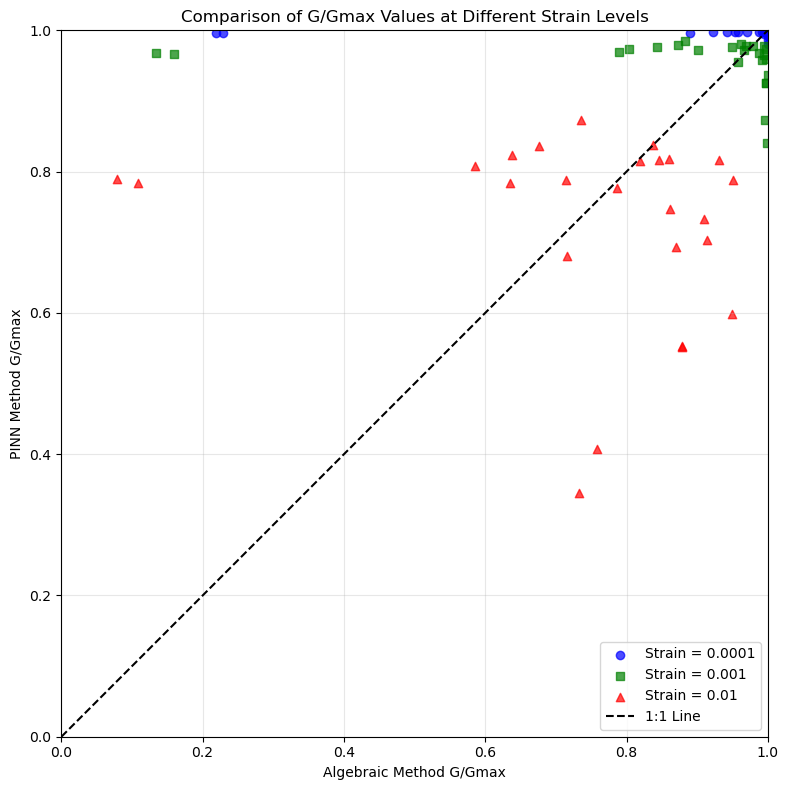

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the G/Gmax data for all three strain levels
strains = ['0.0001', '0.001', '0.01']
colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']

plt.figure(figsize=(10, 8))

# Plot each strain level
for i, strain in enumerate(strains):
    algebraic_vals = joined_table[f'GoverGmax_{strain}_al']
    pinn_vals = joined_table[f'GoverGmax_{strain}_pinn']
    
    # Plot the data points
    plt.scatter(algebraic_vals, pinn_vals, alpha=0.7, 
                color=colors[i], marker=markers[i], 
                label=f'Strain = {strain}')

# Add the 1:1 reference line
max_val = 1.0  # G/Gmax should be between 0 and 1
plt.plot([0, max_val], [0, max_val], 'k--', label='1:1 Line')

# Add labels and title
plt.xlabel('Algebraic Method G/Gmax')
plt.ylabel('PINN Method G/Gmax')
plt.title('Comparison of G/Gmax Values at Different Strain Levels')
plt.legend()
plt.grid(True, alpha=0.3)

# Set equal aspect ratio and limits
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

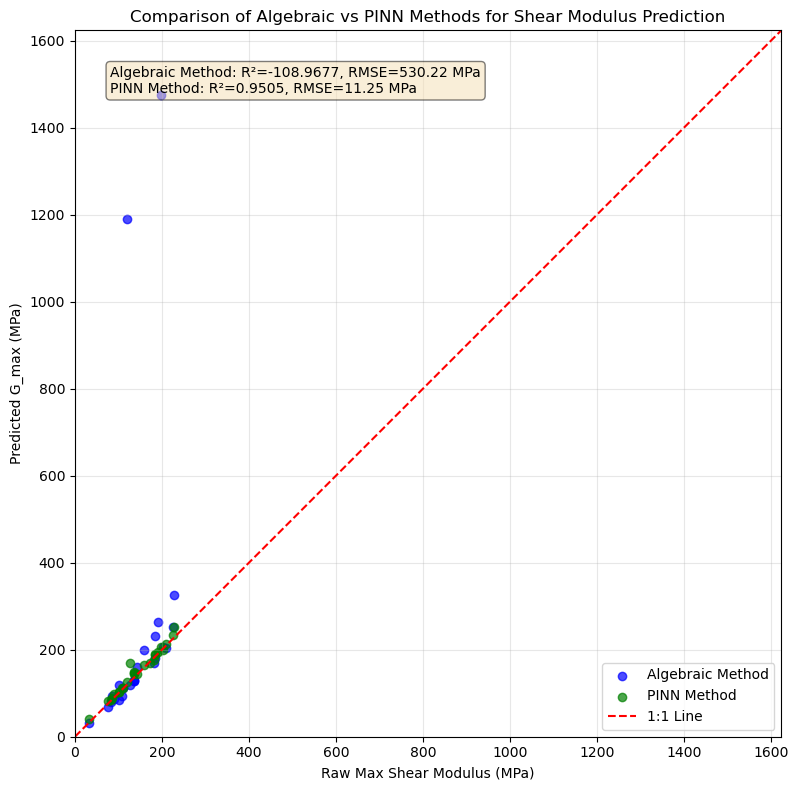

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

# Remove rows with NA values in the relevant columns
clean_data = joined_table[['max_shear_modulus_g_mpa_al', 'predicted_g_max_al', 'predicted_g_max_pinn']].dropna()

# Extract the cleaned data for plotting
max_modulus = clean_data['max_shear_modulus_g_mpa_al']
algebraic_pred = clean_data['predicted_g_max_al']
pinn_pred = clean_data['predicted_g_max_pinn']

# Create a single comparison plot
plt.figure(figsize=(10, 8))

# Plot the data points for both methods
plt.scatter(max_modulus, algebraic_pred, alpha=0.7, color='blue', label='Algebraic Method')
plt.scatter(max_modulus, pinn_pred, alpha=0.7, color='green', label='PINN Method')

# Add the 1:1 reference line
max_val = max(max_modulus.max(), algebraic_pred.max(), pinn_pred.max()) * 1.1
plt.plot([0, max_val], [0, max_val], 'r--', label='1:1 Line')

# Add labels and title
plt.xlabel('Raw Max Shear Modulus (MPa)')
plt.ylabel('Predicted G_max (MPa)')
plt.title('Comparison of Algebraic vs PINN Methods for Shear Modulus Prediction')
plt.legend()
plt.grid(True, alpha=0.3)

# Set equal aspect ratio and limits
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.gca().set_aspect('equal', adjustable='box')

# Calculate and display performance metrics
algebraic_r2 = r2_score(max_modulus, algebraic_pred)
algebraic_rmse = np.sqrt(mean_squared_error(max_modulus, algebraic_pred))
pinn_r2 = r2_score(max_modulus, pinn_pred)
pinn_rmse = np.sqrt(mean_squared_error(max_modulus, pinn_pred))

# Add text box with performance metrics
textstr = '\n'.join((
    f'Algebraic Method: R²={algebraic_r2:.4f}, RMSE={algebraic_rmse:.2f} MPa',
    f'PINN Method: R²={pinn_r2:.4f}, RMSE={pinn_rmse:.2f} MPa'))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

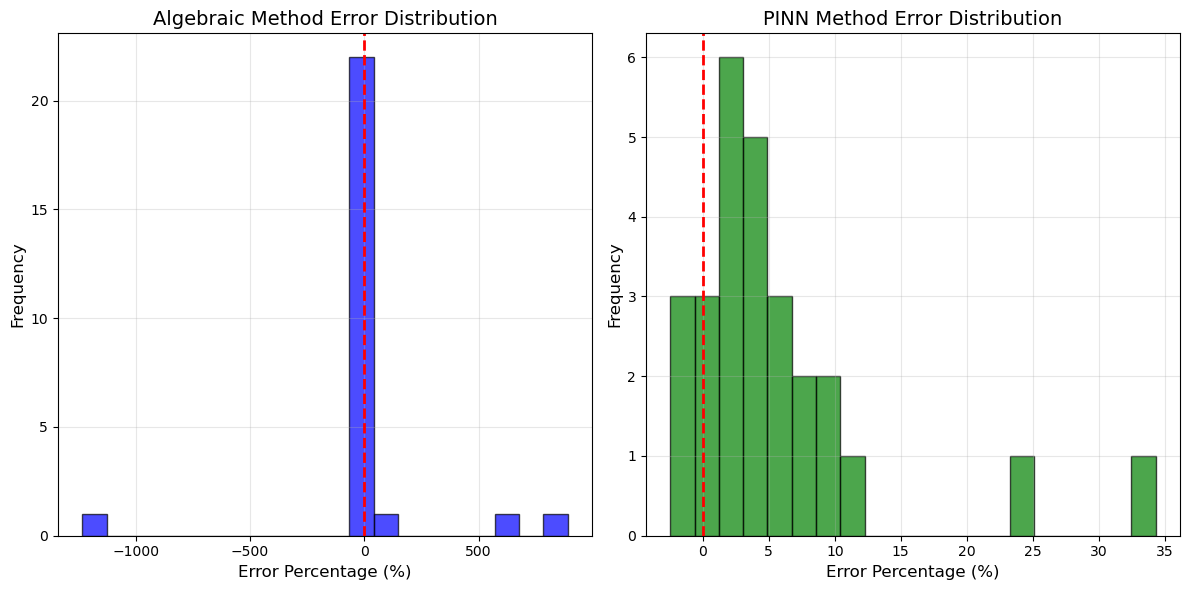

Error Percentage Summary Statistics:
Algebraic Method - Mean: 15.56%, Std: 330.77%
PINN Method - Mean: 5.49%, Std: 7.81%


In [25]:
# Create error distribution plot
plt.figure(figsize=(12, 6))

error_al=joined_table['error_pct_al']
error_pinn=joined_table['error_pct_pinn']
# Create subplots
plt.subplot(1, 2, 1)
plt.hist(error_al, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Error Percentage (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Algebraic Method Error Distribution', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(error_pinn, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Error Percentage (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('PINN Method Error Distribution', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Error Percentage Summary Statistics:")
print(f"Algebraic Method - Mean: {error_al.mean():.2f}%, Std: {error_al.std():.2f}%")
print(f"PINN Method - Mean: {error_pinn.mean():.2f}%, Std: {error_pinn.std():.2f}%")

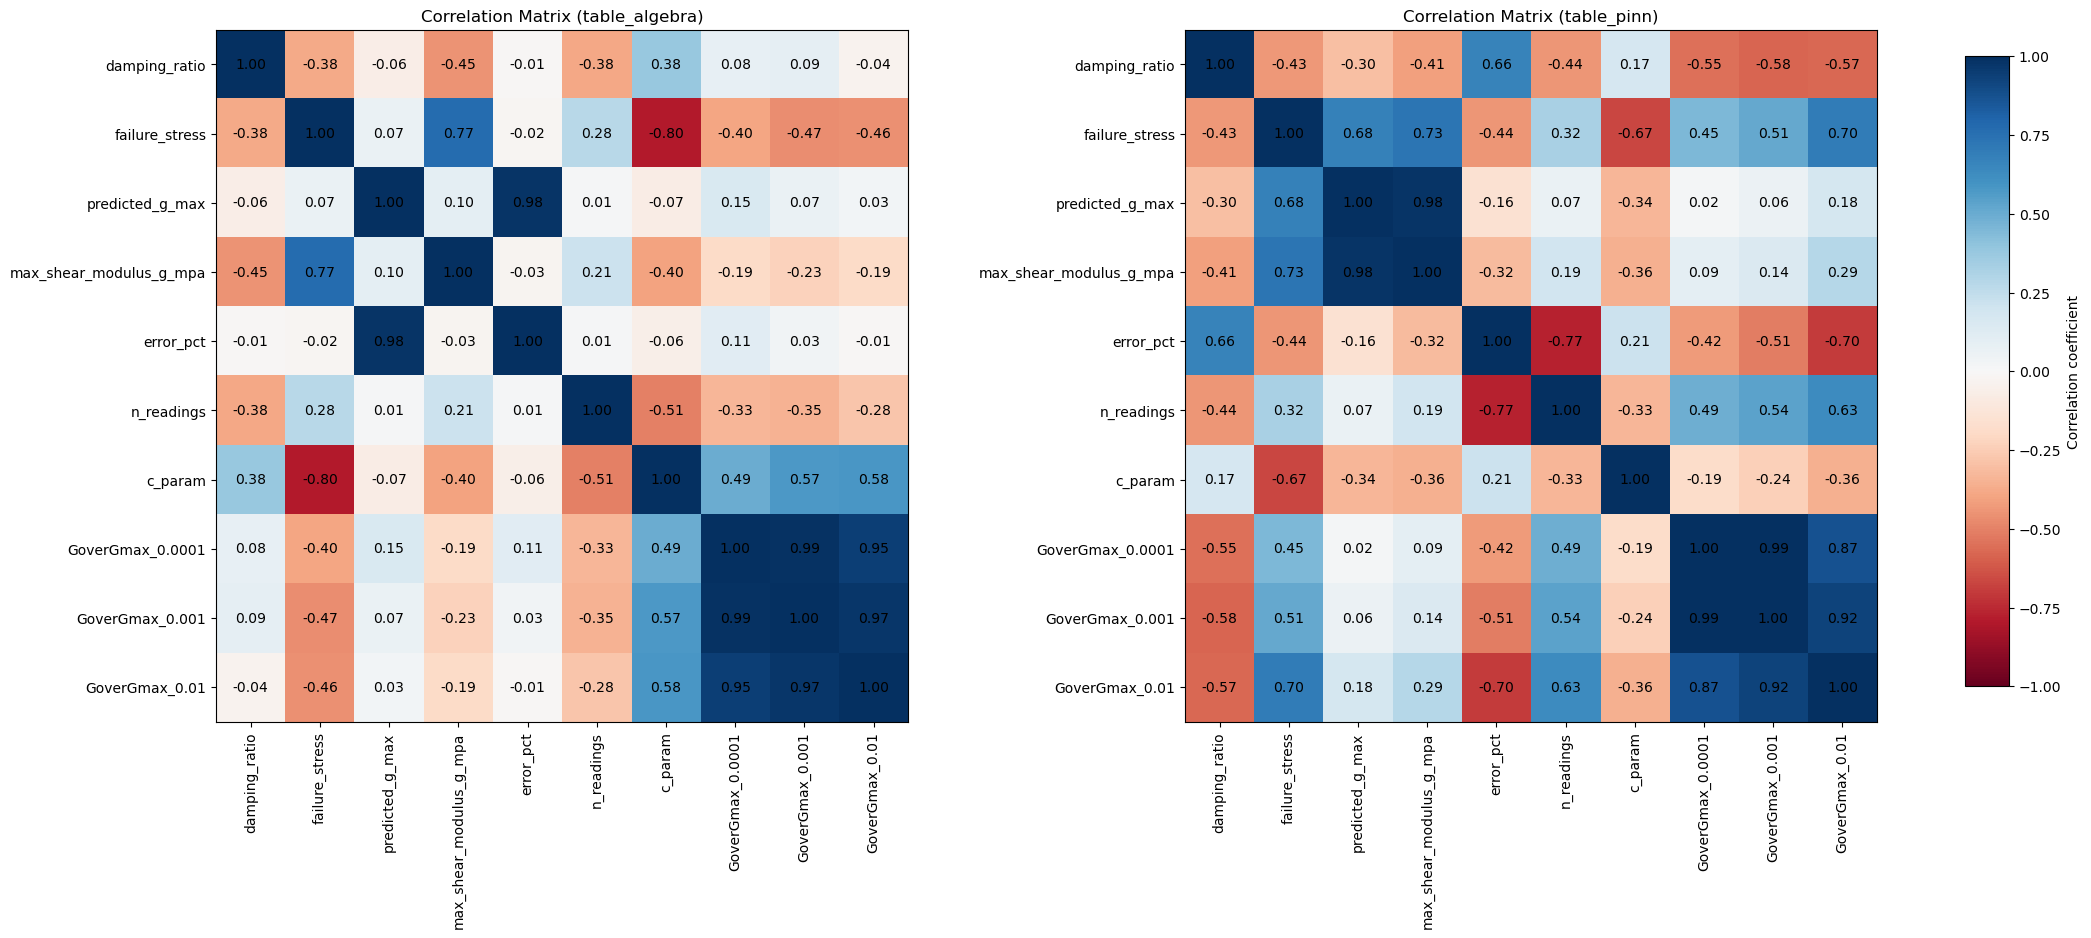

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def clean_and_corr(df, metadata_cols):
    """Remove NULLs, drop metadata, return correlation matrix."""
    df = df.dropna()
    df = df.drop(columns=metadata_cols, errors="ignore")
    return df.corr(numeric_only=True)

# Metadata columns
metadata_cols = [
    "exploratory_position_id", 
    "sample_depth", 
    "sample_reference", 
    "sample_type"
]

# 1. Correlation matrices
corr_algebra = clean_and_corr(table_algebra, metadata_cols)
corr_pinn    = clean_and_corr(table_pinn, metadata_cols)

# 2. Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(22, 9))

for ax, corr_matrix, title in zip(
    axes, 
    [corr_algebra, corr_pinn], 
    ["table_algebra", "table_pinn"]
):
    im = ax.imshow(corr_matrix, cmap="RdBu", interpolation="none", vmin=-1, vmax=1)
    ax.set_xticks(range(len(corr_matrix)))
    ax.set_yticks(range(len(corr_matrix)))
    ax.set_xticklabels(corr_matrix.columns, rotation=90)
    ax.set_yticklabels(corr_matrix.columns)
    ax.set_title(f"Correlation Matrix ({title})")

    # Add numbers
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            value = corr_matrix.iloc[i, j]
            ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="black")

# Adjust layout and add a separate colorbar on the right
fig.subplots_adjust(right=0.88, wspace=0.4)  # leave space for colorbar & spacing
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label="Correlation coefficient")

plt.show()


# Given a 0.98% correlation between actual and predicted shear modulus, we will consider predicted shear modulus for further analysis and will consider PINN network over algebraic method.

### Identifying the correlation relationships between availble intrinsic parameters and performance parameters.

In [83]:
final_pinn_per=final_pinn.copy()

In [87]:
final_pinn_per['bulk_density_change']=(final_pinn_per['final_bulk_density']-final_pinn_per['initial_bulk_density'])/final_pinn_per['initial_bulk_density']
final_pinn_per['dry_density_change']=(final_pinn_per['final_dry_density']-final_pinn_per['initial_dry_density'])/final_pinn_per['initial_dry_density']
final_pinn_per['voids_ratio_change']=(final_pinn_per['final_voids_ratio']-final_pinn_per['initial_voids_ratio'])/final_pinn_per['initial_voids_ratio']

In [95]:
final_pinn_per.drop(['final_bulk_density','final_dry_density','final_voids_ratio'], axis=1,inplace=True)

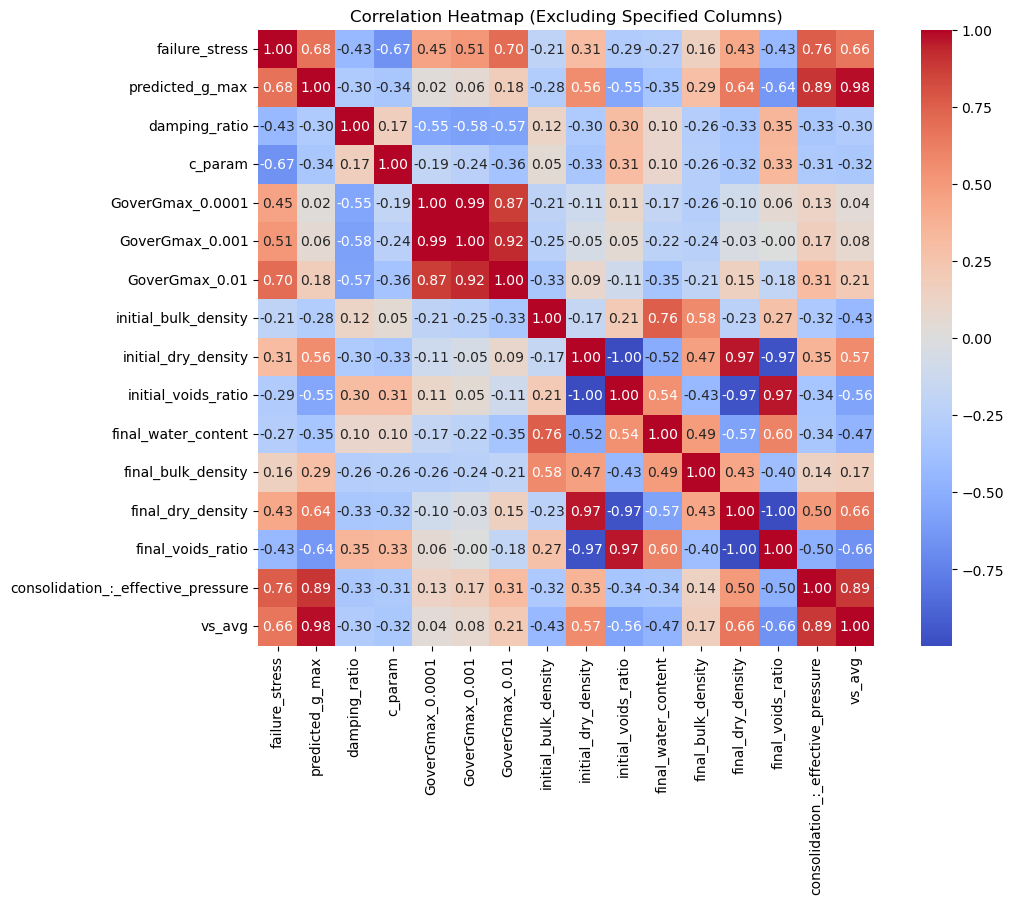

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude specified columns and select only numeric columns
numeric_data = final_pinn.drop(columns=['exploratory_position_id', 'sample_reference', 'sample_type','sample_depth', 'n_readings']).select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap (Excluding Specified Columns)")
plt.show()

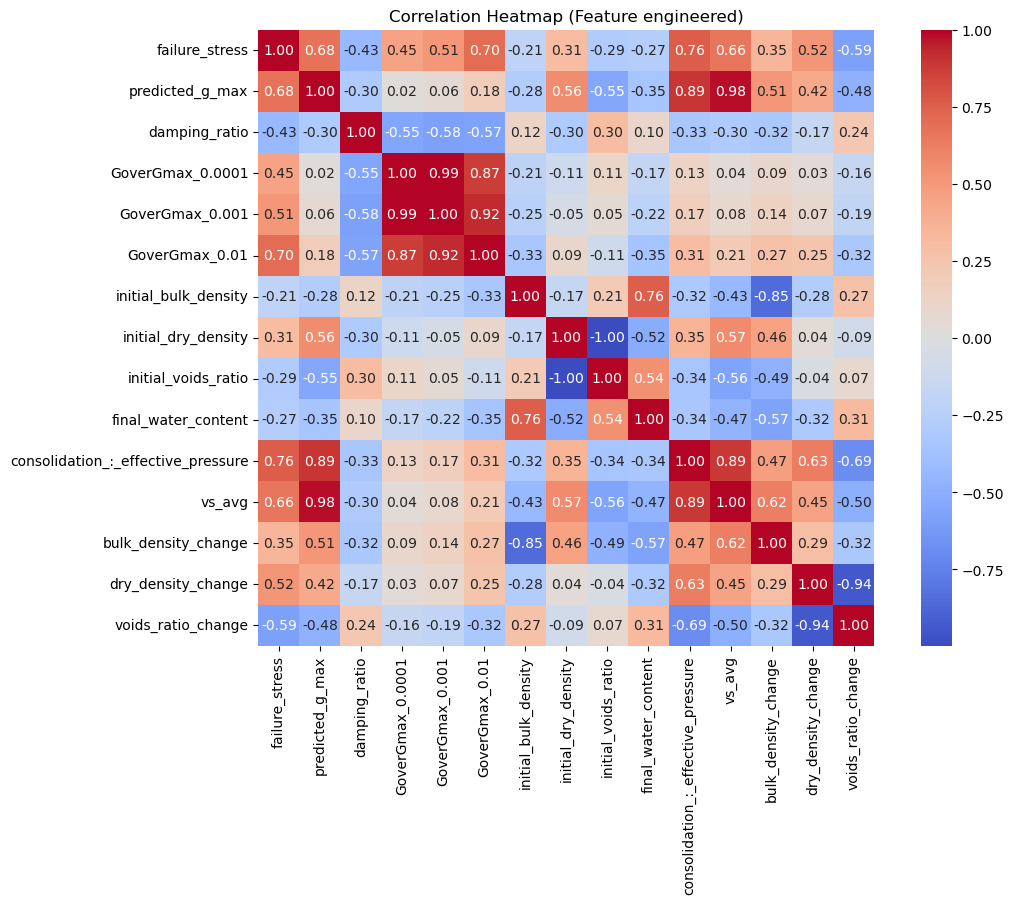

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude specified columns and select only numeric columns
numeric_data = final_pinn_per.drop(columns=['exploratory_position_id','c_param','sample_reference', 'sample_type','sample_depth', 'n_readings']).select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap (Feature engineered)")
plt.show()

# Unsupervised ML

# Given the predictions and intrinsic properties of the sample data, we will now perform unsupervised ML

Optimal k by silhouette: 6



C:\Users\arunj\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


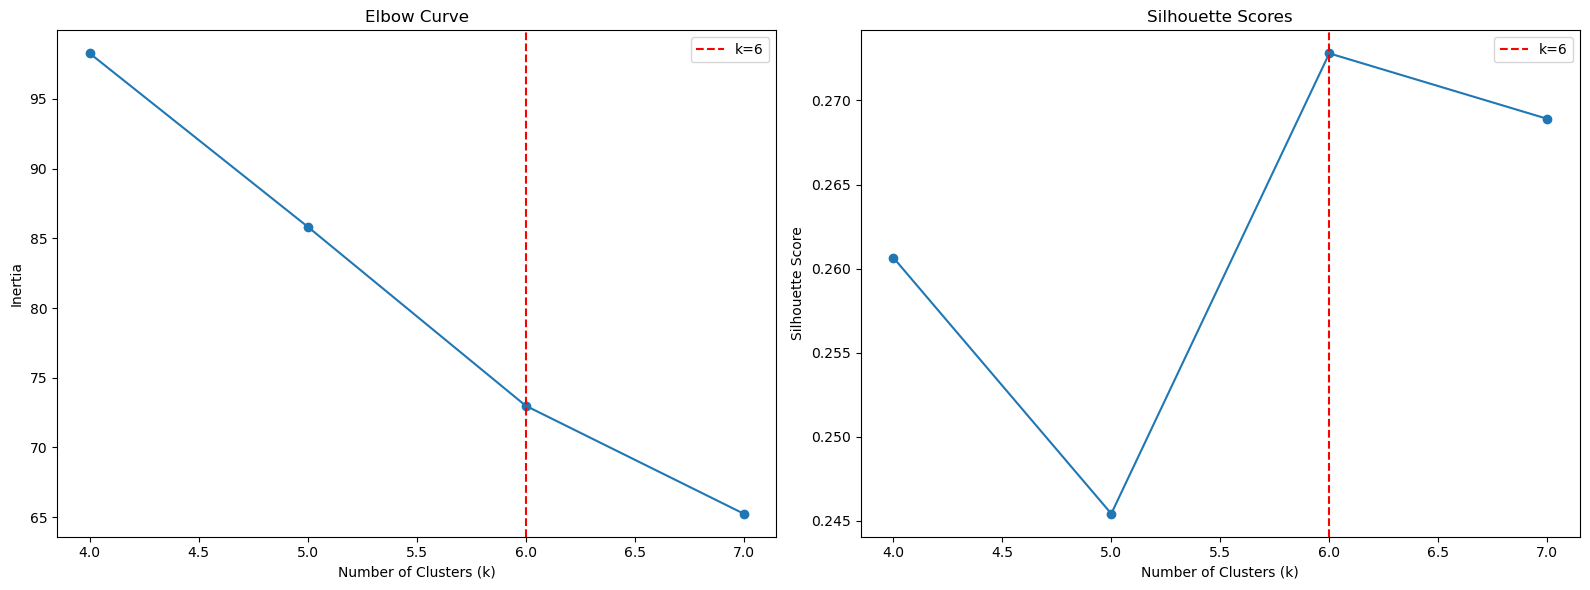

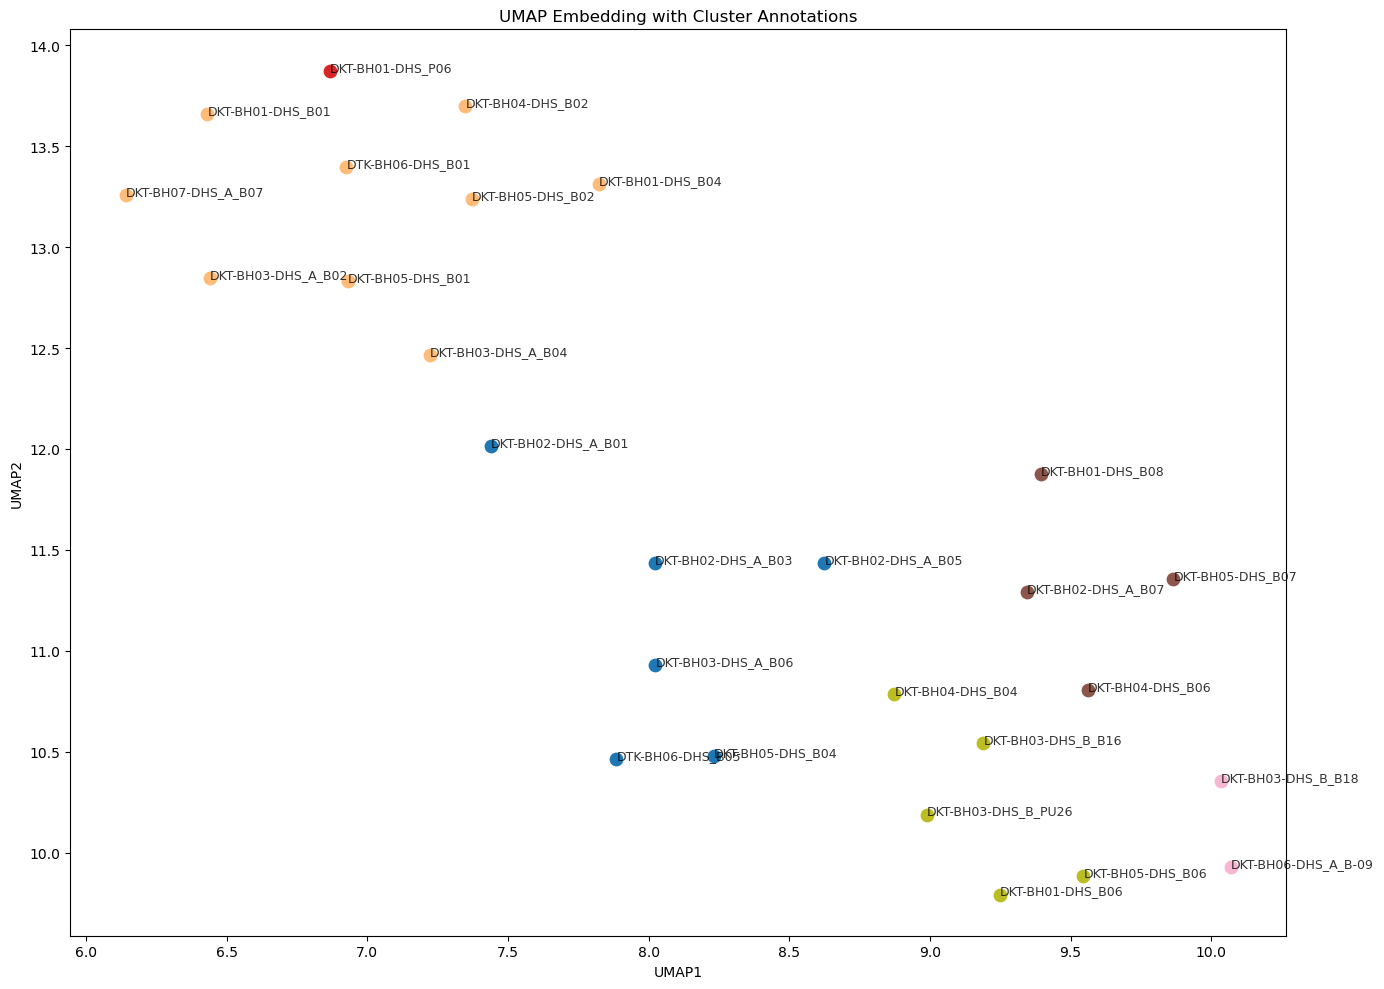

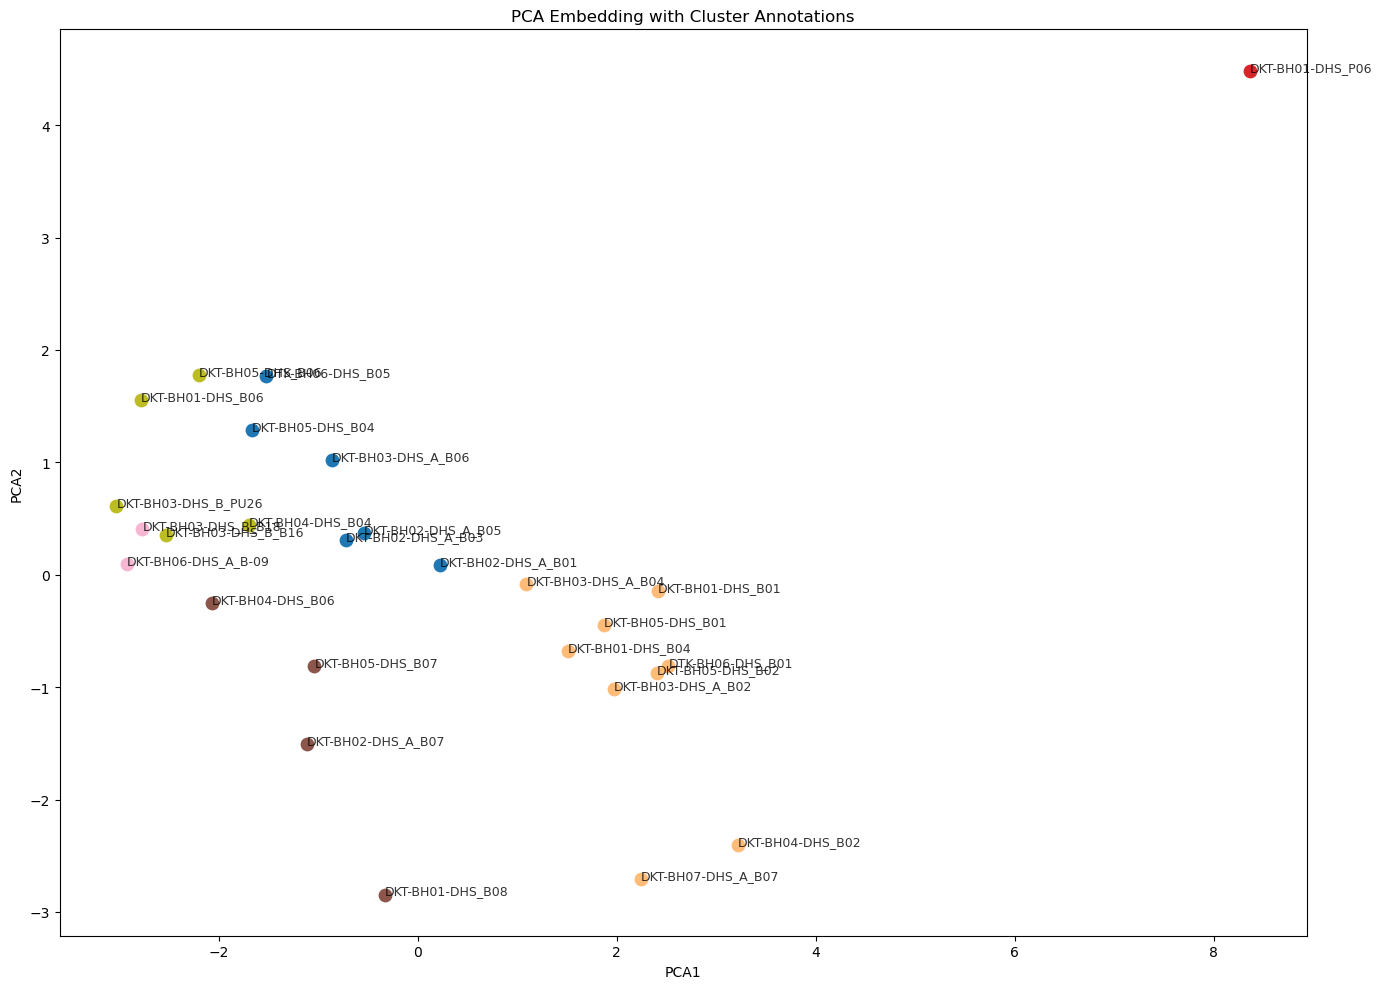

Cluster counts:
         count
cluster       
0            6
1            9
2            1
3            4
4            2
5            5


cluster sample_reference sample_type  damping_ratio  failure_stress  \
26        0              B05           B       3.597234        0.294711   
20        0              B04           B       0.271607        1.798455   
5         0              B01           B       2.104921        3.939222   
6         0              B03           B       1.371231        7.331105   
7         0              B05           B       0.930968        5.977711   
11        0              B06           B       0.271607        1.798455   
1         1              B01           B       2.235167        3.022835   
2         1              B04           B       0.131930        2.218063   
24        1              B07           B       6.070750        0.888974   
19        1              B02           B       1.024035        2.217295   
9         1              B02           B       2.344194        4.606677   
10        1              B04           B       1.760000        6.173997   
18        1              B01           B       1.460526        2.229117   
25        1              B01           B       1.417193        1.907230   
15        1              B02           B       1.060984        4.140639   
0         2              P06           U       2.644762        0.274049   
17        3              B06           B       0.343651        5.068932   
8         3              B07           B       1.137164        8.909454   
4         3              B08           B       0.955745       13.543041   
22        3              B07           B       1.179851       10.795144   
23        4             B-09           B       0.391277       12.488847   
14        4              B18           B       0.440213       11.102413   
16        5              B04           B       1.090149       11.011155   
12        5             PU26           B       1.391642       10.269225   
21        5              B06           B       0.519242        9.244927   
3         5              B06           B       0.731940       11.666979   
13        5              B16           B       0.392923        7.838401   

    predicted_g_max  initial_bulk_density  initial_dry_density  \
26       165.441407                  1.76                 1.74   
20       145.077161                  1.76                 1.74   
5        111.503915                  1.71                 1.70   
6        125.191133                  1.71                 1.71   
7        144.345921                  1.71                 1.69   
11       146.099011                  1.73                 1.72   
1        102.466738                  1.84                 1.66   
2        148.735965                  1.66                 1.64   
24       169.204576                  1.64                 1.63   
19        98.189105                  1.66                 1.64   
9         84.406574                  1.69                 1.66   
10       102.083444                  1.69                 1.68   
18        81.074733                  1.69                 1.67   
25        89.386023                  1.66                 1.65   
15       110.953373                  1.62                 1.60   
0         39.966471                  2.13                 1.56   
17       214.204794                  1.71                 1.70   
8        190.009219                  1.69                 1.68   
4        165.391918                  1.64                 1.62   
22       188.410133                  1.70                 1.68   
23       253.210050                  1.71                 1.70   
14       232.902220                  1.72                 1.70   
16       170.472616                  1.72                 1.71   
12       195.368561                  1.76                 1.74   
21       198.552346                  1.74                 1.71   
3        206.267682                  1.75                 1.73   
13       176.796445                  1.73                 1.72   

    initial_voids_ratio  final_water_content  final_bu

In [29]:
true_cols = [
    'exploratory_position_id',
    'failure_stress',
    'predicted_g_max',
    'sample_reference',
    'sample_type',
    'damping_ratio',
    'initial_bulk_density',
    'initial_dry_density',
    'initial_voids_ratio',
    'final_water_content',
    'final_bulk_density',
    'final_dry_density',
    'final_voids_ratio',
    'consolidation_:_effective_pressure',
    'vs_avg'
]
# this is the correct way to subset by columns:
final_tot=final_total.copy()
final = final_tot[true_cols]

# Identify numeric columns (UMAP can accept all numeric, incl. integers)
feature_cols = final.select_dtypes(include=["int64", "float64"]).columns.tolist()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Settings
RANDOM_STATE = 2626919
MAX_K = 7

# 1. Standardize features
df = final.copy()
X_scaled = StandardScaler().fit_transform(df[feature_cols])

# 2. Elbow + silhouette search
ks = list(range(4, MAX_K + 1))
inertias, silhouettes = [], []
for k in ks:
    km = KMeans(n_clusters=k, n_init='auto', random_state=RANDOM_STATE)
    labels_tmp = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels_tmp))
optimal_k = ks[int(np.argmax(silhouettes))]
print(f"Optimal k by silhouette: {optimal_k}\n")

# 3. Final clustering
km_final = KMeans(n_clusters=optimal_k, n_init='auto', random_state=RANDOM_STATE)
clusters = km_final.fit_predict(X_scaled)

# 4. UMAP embedding
umap_emb = umap.UMAP(n_components=2, random_state=RANDOM_STATE).fit_transform(X_scaled)
# 4b. PCA embedding
dim_red = PCA(n_components=2, random_state=RANDOM_STATE)
pca_emb = dim_red.fit_transform(X_scaled)

# 5. Build final3
final3 = df.copy()
final3['cluster'] = clusters
final3['UMAP1'], final3['UMAP2'] = umap_emb[:, 0], umap_emb[:, 1]
final3['PCA1'], final3['PCA2'] = pca_emb[:, 0], pca_emb[:, 1]
globals()['final3'] = final3

# 6a. Elbow & silhouette plots
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(ks, inertias, marker='o', linestyle='-')
plt.axvline(optimal_k, color='red', linestyle='--', label=f'k={optimal_k}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ks, silhouettes, marker='o', linestyle='-')
plt.axvline(optimal_k, color='red', linestyle='--', label=f'k={optimal_k}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.legend()
plt.tight_layout()
plt.show()

# 6b. Annotated UMAP embedding
plt.figure(figsize=(14, 10))
cmap = plt.get_cmap('tab20')
for idx, row in final3.iterrows():
    plt.scatter(row['UMAP1'], row['UMAP2'],
                color=cmap(row['cluster'] / (optimal_k)), s=80)
    label = f"{row['exploratory_position_id']}_{row['sample_reference']}"
    plt.text(row['UMAP1'], row['UMAP2'], label, fontsize=9, alpha=0.8)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Embedding with Cluster Annotations')
plt.tight_layout()
plt.show()

# 6c. Annotated PCA embedding
plt.figure(figsize=(14, 10))
cmap = plt.get_cmap('tab20')
for idx, row in final3.iterrows():
    plt.scatter(row['PCA1'], row['PCA2'],
                color=cmap(row['cluster'] / (optimal_k)), s=80)
    plt.text(row['PCA1'], row['PCA2'],
             f"{row['exploratory_position_id']}_{row['sample_reference']}",
             fontsize=9, alpha=0.8)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA Embedding with Cluster Annotations')
plt.tight_layout()
plt.show()

# 7. Cluster counts & preview
counts = final3['cluster'].value_counts().sort_index()
print('Cluster counts:')
print(counts.to_frame(name='count'))


final4 = final3.copy()
# Assign Eurocode ground class based on average shear-wave velocity (vs_avg)
import numpy as np

conds = [
    final4["vs_avg"] >= 800,   # A
    final4["vs_avg"] >= 360,   # B
    final4["vs_avg"] >= 180,   # C
    final4["vs_avg"] >= 120,   # D
    final4["vs_avg"] >=  90    # E
]
choices = ["A", "B", "C", "D", "E"]

final3["eurocode_class"] = np.select(conds, choices, default="F")

# Preview final4
cols=['cluster','sample_reference', 'sample_type',
       'damping_ratio',
      'failure_stress',
    'predicted_g_max',
    'initial_bulk_density',
    'initial_dry_density',
    'initial_voids_ratio',
    'final_water_content',
    'final_bulk_density',
    'final_dry_density',
    'final_voids_ratio',
    'consolidation_:_effective_pressure',
    'vs_avg','eurocode_class']
final3[cols].sort_values(by='cluster',ascending=True)

### final3[cols].sort_values(by='cluster',ascending=True).to_csv(r"Final_clusters", index=False)

In [31]:
final3.columns

Index(['exploratory_position_id', 'failure_stress', 'predicted_g_max',
       'sample_reference', 'sample_type', 'damping_ratio',
       'initial_bulk_density', 'initial_dry_density', 'initial_voids_ratio',
       'final_water_content', 'final_bulk_density', 'final_dry_density',
       'final_voids_ratio', 'consolidation_:_effective_pressure', 'vs_avg',
       'cluster', 'UMAP1', 'UMAP2', 'PCA1', 'PCA2', 'eurocode_class'],
      dtype='object')

# PERFORMING ML---> 1. Start with the most simplistic model and start advancing

### INCLUDING PARTIAL ENERGY DISSIPATION INFORMATION ACTING AS AN ANCHOR

In [128]:
final_pinn_per.columns

Index(['exploratory_position_id', 'sample_depth', 'sample_reference',
       'sample_type', 'n_readings', 'failure_stress', 'predicted_g_max',
       'damping_ratio', 'c_param', 'GoverGmax_0.0001', 'GoverGmax_0.001',
       'GoverGmax_0.01', 'initial_bulk_density', 'initial_dry_density',
       'initial_voids_ratio', 'final_water_content',
       'consolidation_:_effective_pressure', 'vs_avg', 'bulk_density_change',
       'dry_density_change', 'voids_ratio_change'],
      dtype='object')

# MODEL 1 -- ADDING ALL INITIAL PARAMETERS AND STATE CHANGE PARAMETERS

Available samples: 27

=== Fold 1/5 ===
Epoch [500/2500], Train Loss: 0.0216, Val Loss: 0.3972
Epoch [1000/2500], Train Loss: 0.0195, Val Loss: 0.4318
Epoch [1500/2500], Train Loss: 0.0320, Val Loss: 0.4582
Epoch [2000/2500], Train Loss: 0.0110, Val Loss: 0.5067
Epoch [2500/2500], Train Loss: 0.0183, Val Loss: 0.5663
Fold 1 Results: R²: 0.254, RMSE: 3.154, MAE: 3.154

=== Fold 2/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0366, Val Loss: 0.8099
Epoch [1000/2500], Train Loss: 0.0281, Val Loss: 0.4908
Epoch [1500/2500], Train Loss: 0.0167, Val Loss: 0.4179
Epoch [2000/2500], Train Loss: 0.0160, Val Loss: 0.4362
Epoch [2500/2500], Train Loss: 0.0112, Val Loss: 0.4194
Fold 2 Results: R²: 0.652, RMSE: 2.575, MAE: 2.575

=== Fold 3/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0419, Val Loss: 0.0855
Epoch [1000/2500], Train Loss: 0.0175, Val Loss: 0.0672
Epoch [1500/2500], Train Loss: 0.0398, Val Loss: 0.0856
Epoch [2000/2500], Train Loss: 0.0106, Val Loss: 0.0768
Epoch [2500/2500], Train Loss: 0.0072, Val Loss: 0.0830
Fold 3 Results: R²: 0.874, RMSE: 1.203, MAE: 1.203

=== Fold 4/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0361, Val Loss: 0.3399
Epoch [1000/2500], Train Loss: 0.0148, Val Loss: 0.3919
Epoch [1500/2500], Train Loss: 0.0127, Val Loss: 0.3697
Epoch [2000/2500], Train Loss: 0.0193, Val Loss: 0.3634
Epoch [2500/2500], Train Loss: 0.0111, Val Loss: 0.3514
Fold 4 Results: R²: 0.720, RMSE: 2.289, MAE: 2.289

=== Fold 5/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0789, Val Loss: 0.2760
Epoch [1000/2500], Train Loss: 0.0243, Val Loss: 0.3089
Epoch [1500/2500], Train Loss: 0.0209, Val Loss: 0.2560
Epoch [2000/2500], Train Loss: 0.0147, Val Loss: 0.2958
Epoch [2500/2500], Train Loss: 0.0039, Val Loss: 0.3045
Fold 5 Results: R²: -0.314, RMSE: 2.294, MAE: 2.294

Mean R²: 0.437 ± 0.428
Mean RMSE: 2.303 ± 0.634
Mean MAE: 2.303 ± 0.634

Overall Metrics (all folds combined):
R²: 0.649
RMSE: 2.428
MAE: 2.428


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

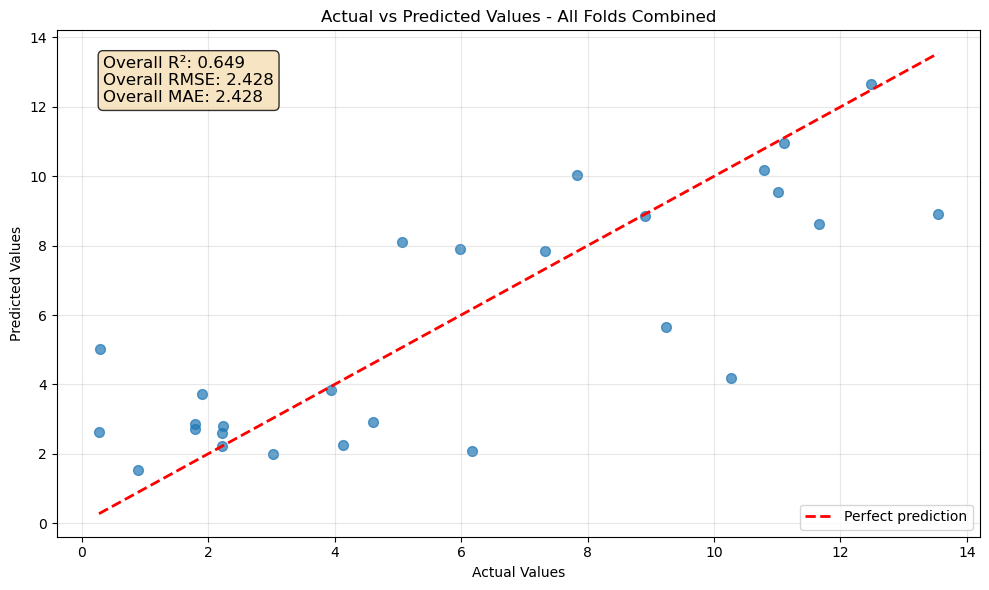


Feature Importance (Permutation Importance):
                           feature  importance
consolidation_:_effective_pressure    0.156638
              initial_bulk_density    0.112467
                dry_density_change    0.074799
                     damping_ratio    0.040019
                voids_ratio_change   -0.021207
               bulk_density_change   -0.238177
               initial_voids_ratio   -0.254278


In [190]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(2626919)
np.random.seed(2626919)

# Load the data
df = final_pinn_per.copy()

# WE OBSERVED dry_density is highly correlated to voids ratio... So removed dry density
# Define feature and target columns
feature_cols = [
    'damping_ratio', 'initial_bulk_density', 'bulk_density_change', 'initial_voids_ratio', 'voids_ratio_change','dry_density_change',
    'consolidation_:_effective_pressure'
]
target_col = 'failure_stress'

# Drop rows with missing values in features or target
df = df.dropna(subset=feature_cols + [target_col])

print(f"Available samples: {len(df)}")

# Prepare data
X = df[feature_cols].values
y = df[target_col].values

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=2626919)

# Define the ANN model
class ANN(nn.Module):
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Store results for each fold
fold_results = []
all_y_test = []
all_y_pred = []

# 5-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\n=== Fold {fold + 1}/5 ===")
    
    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale the features and target
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled.astype(np.float32))
    y_train_tensor = torch.FloatTensor(y_train_scaled.astype(np.float32))
    X_test_tensor = torch.FloatTensor(X_test_scaled.astype(np.float32))
    y_test_tensor = torch.FloatTensor(y_test_scaled.astype(np.float32))
    
    # Initialize model
    model = ANN(X_train_scaled.shape[1])
    model = model.float()
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 2500
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train_tensor)
        loss = criterion(outputs.squeeze(), y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs.squeeze(), y_test_tensor)
        
        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    # Final prediction and evaluation for this fold
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor).numpy()
    
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_original = y_test
    
    # Calculate metrics
    r2 = r2_score(y_test_original, y_pred)
    rmse = mean_squared_error(y_test_original, y_pred, squared=False)
    mae = mean_squared_error(y_test_original, y_pred, squared=False)
    
    # Store results
    fold_results.append({
        'r2': r2,
        'rmse': rmse,
        'mae': mae
    })
    
    # Store predictions for overall analysis
    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred)
    
    print(f"Fold {fold + 1} Results: R²: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")

# Calculate mean metrics across folds
mean_r2 = np.mean([result['r2'] for result in fold_results])
std_r2 = np.std([result['r2'] for result in fold_results])
mean_rmse = np.mean([result['rmse'] for result in fold_results])
std_rmse = np.std([result['rmse'] for result in fold_results])
mean_mae = np.mean([result['mae'] for result in fold_results])
std_mae = np.std([result['mae'] for result in fold_results])

# Overall metrics
overall_r2 = r2_score(all_y_test, all_y_pred)
overall_rmse = mean_squared_error(all_y_test, all_y_pred, squared=False)
overall_mae = mean_squared_error(all_y_test, all_y_pred, squared=False)

# Print results
print(f"\nMean R²: {mean_r2:.3f} ± {std_r2:.3f}")
print(f"Mean RMSE: {mean_rmse:.3f} ± {std_rmse:.3f}")
print(f"Mean MAE: {mean_mae:.3f} ± {std_mae:.3f}")

print(f"\nOverall Metrics (all folds combined):")
print(f"R²: {overall_r2:.3f}")
print(f"RMSE: {overall_rmse:.3f}")
print(f"MAE: {overall_mae:.3f}")

# Create actual vs predicted plot with metrics inside
plt.figure(figsize=(10, 6))
plt.scatter(all_y_test, all_y_pred, alpha=0.7, s=50)
max_val = max(max(all_y_test), max(all_y_pred))
min_val = min(min(all_y_test), min(all_y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')

# Add metrics text inside the plot
textstr = f'Overall R²: {overall_r2:.3f}\nOverall RMSE: {overall_rmse:.3f}\nOverall MAE: {overall_mae:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - All Folds Combined')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance using the last fold's model
def permutation_importance(model, X_tensor, y_tensor, metric=r2_score, n_repeats=5):
    """Calculate permutation feature importance"""
    model.eval()
    with torch.no_grad():
        baseline_pred = model(X_tensor).numpy()
        baseline_score = metric(y_tensor.numpy(), baseline_pred.flatten())
    
    importance_scores = np.zeros(X_tensor.shape[1])
    
    for feature_idx in range(X_tensor.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_tensor.clone()
            X_permuted[:, feature_idx] = X_permuted[torch.randperm(X_permuted.size(0)), feature_idx]
            
            with torch.no_grad():
                perm_pred = model(X_permuted).numpy()
                score = metric(y_tensor.numpy(), perm_pred.flatten())
                scores.append(score)
        
        importance_scores[feature_idx] = baseline_score - np.mean(scores)
    
    return importance_scores

# Calculate feature importance
feature_importance = permutation_importance(model, X_test_tensor, y_test_tensor, n_repeats=5)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Permutation Importance):")
print(importance_df.to_string(index=False))

### We observe a high degree of multicollinearity indicated by negative feature importance

# MODEL 2:
# KEEPING ONLY INTITAL PARAMETERS

Available samples: 27

=== Fold 1/5 ===
Epoch [500/2500], Train Loss: 0.0456, Val Loss: 0.3450
Epoch [1000/2500], Train Loss: 0.0210, Val Loss: 0.5280
Epoch [1500/2500], Train Loss: 0.0107, Val Loss: 0.6470
Epoch [2000/2500], Train Loss: 0.0066, Val Loss: 0.6888
Epoch [2500/2500], Train Loss: 0.0093, Val Loss: 0.7377
Fold 1 Results: R²: 0.028, RMSE: 3.600, MAE: 3.600

=== Fold 2/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.1241, Val Loss: 0.2869
Epoch [1000/2500], Train Loss: 0.0516, Val Loss: 0.2572
Epoch [1500/2500], Train Loss: 0.0238, Val Loss: 0.3372
Epoch [2000/2500], Train Loss: 0.0286, Val Loss: 0.3113
Epoch [2500/2500], Train Loss: 0.0112, Val Loss: 0.2871
Fold 2 Results: R²: 0.762, RMSE: 2.130, MAE: 2.130

=== Fold 3/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0572, Val Loss: 0.0322
Epoch [1000/2500], Train Loss: 0.0345, Val Loss: 0.0600
Epoch [1500/2500], Train Loss: 0.0439, Val Loss: 0.0565
Epoch [2000/2500], Train Loss: 0.0065, Val Loss: 0.0454
Epoch [2500/2500], Train Loss: 0.0165, Val Loss: 0.0278
Fold 3 Results: R²: 0.958, RMSE: 0.696, MAE: 0.696

=== Fold 4/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.1229, Val Loss: 0.3059
Epoch [1000/2500], Train Loss: 0.0547, Val Loss: 0.2893
Epoch [1500/2500], Train Loss: 0.0389, Val Loss: 0.2762
Epoch [2000/2500], Train Loss: 0.0141, Val Loss: 0.2960
Epoch [2500/2500], Train Loss: 0.0141, Val Loss: 0.2857
Fold 4 Results: R²: 0.772, RMSE: 2.064, MAE: 2.064

=== Fold 5/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0356, Val Loss: 0.0731
Epoch [1000/2500], Train Loss: 0.0563, Val Loss: 0.0847
Epoch [1500/2500], Train Loss: 0.0298, Val Loss: 0.0927
Epoch [2000/2500], Train Loss: 0.0268, Val Loss: 0.0985
Epoch [2500/2500], Train Loss: 0.0160, Val Loss: 0.0884
Fold 5 Results: R²: 0.619, RMSE: 1.236, MAE: 1.236

Mean R²: 0.628 ± 0.319
Mean RMSE: 1.945 ± 0.985
Mean MAE: 1.945 ± 0.985

Overall Metrics (all folds combined):
R²: 0.699
RMSE: 2.247
MAE: 2.247


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

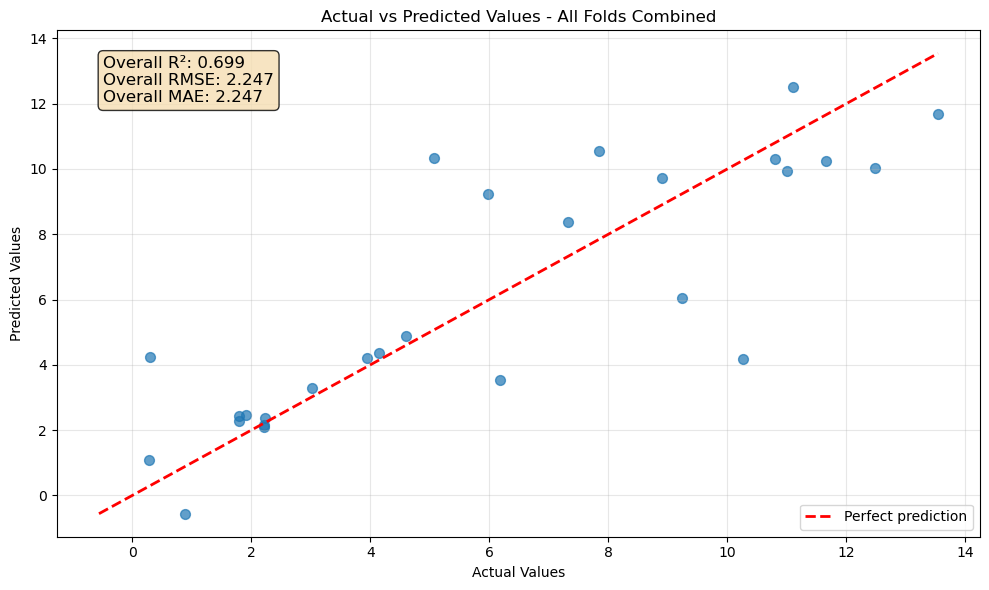


Feature Importance (Permutation Importance):
                           feature  importance
              initial_bulk_density    1.226075
consolidation_:_effective_pressure    0.597497
                     damping_ratio    0.288336
               initial_voids_ratio    0.171403
               initial_dry_density    0.075809


In [198]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(2626919)
np.random.seed(2626919)

# Load the data
df = final3.copy()

# WE OBSERVED dry_density is highly correlated to voids ratio... So removed dry density
# Define feature and target columns
feature_cols = [
    'damping_ratio', 'initial_bulk_density', 'initial_dry_density', 'initial_voids_ratio',
    'consolidation_:_effective_pressure'
]
target_col = 'failure_stress'

# Drop rows with missing values in features or target
df = df.dropna(subset=feature_cols + [target_col])

print(f"Available samples: {len(df)}")

# Prepare data
X = df[feature_cols].values
y = df[target_col].values

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=2626919)

# Define the ANN model
class ANN(nn.Module):
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Store results for each fold
fold_results = []
all_y_test = []
all_y_pred = []

# 5-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\n=== Fold {fold + 1}/5 ===")
    
    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale the features and target
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled.astype(np.float32))
    y_train_tensor = torch.FloatTensor(y_train_scaled.astype(np.float32))
    X_test_tensor = torch.FloatTensor(X_test_scaled.astype(np.float32))
    y_test_tensor = torch.FloatTensor(y_test_scaled.astype(np.float32))
    
    # Initialize model
    model = ANN(X_train_scaled.shape[1])
    model = model.float()
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 2500
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train_tensor)
        loss = criterion(outputs.squeeze(), y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs.squeeze(), y_test_tensor)
        
        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    # Final prediction and evaluation for this fold
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor).numpy()
    
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_original = y_test
    
    # Calculate metrics
    r2 = r2_score(y_test_original, y_pred)
    rmse = mean_squared_error(y_test_original, y_pred, squared=False)
    mae = mean_squared_error(y_test_original, y_pred, squared=False)
    
    # Store results
    fold_results.append({
        'r2': r2,
        'rmse': rmse,
        'mae': mae
    })
    
    # Store predictions for overall analysis
    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred)
    
    print(f"Fold {fold + 1} Results: R²: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")

# Calculate mean metrics across folds
mean_r2 = np.mean([result['r2'] for result in fold_results])
std_r2 = np.std([result['r2'] for result in fold_results])
mean_rmse = np.mean([result['rmse'] for result in fold_results])
std_rmse = np.std([result['rmse'] for result in fold_results])
mean_mae = np.mean([result['mae'] for result in fold_results])
std_mae = np.std([result['mae'] for result in fold_results])

# Overall metrics
overall_r2 = r2_score(all_y_test, all_y_pred)
overall_rmse = mean_squared_error(all_y_test, all_y_pred, squared=False)
overall_mae = mean_squared_error(all_y_test, all_y_pred, squared=False)

# Print results
print(f"\nMean R²: {mean_r2:.3f} ± {std_r2:.3f}")
print(f"Mean RMSE: {mean_rmse:.3f} ± {std_rmse:.3f}")
print(f"Mean MAE: {mean_mae:.3f} ± {std_mae:.3f}")

print(f"\nOverall Metrics (all folds combined):")
print(f"R²: {overall_r2:.3f}")
print(f"RMSE: {overall_rmse:.3f}")
print(f"MAE: {overall_mae:.3f}")

# Create actual vs predicted plot with metrics inside
plt.figure(figsize=(10, 6))
plt.scatter(all_y_test, all_y_pred, alpha=0.7, s=50)
max_val = max(max(all_y_test), max(all_y_pred))
min_val = min(min(all_y_test), min(all_y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')

# Add metrics text inside the plot
textstr = f'Overall R²: {overall_r2:.3f}\nOverall RMSE: {overall_rmse:.3f}\nOverall MAE: {overall_mae:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - All Folds Combined')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance using the last fold's model
def permutation_importance(model, X_tensor, y_tensor, metric=r2_score, n_repeats=5):
    """Calculate permutation feature importance"""
    model.eval()
    with torch.no_grad():
        baseline_pred = model(X_tensor).numpy()
        baseline_score = metric(y_tensor.numpy(), baseline_pred.flatten())
    
    importance_scores = np.zeros(X_tensor.shape[1])
    
    for feature_idx in range(X_tensor.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_tensor.clone()
            X_permuted[:, feature_idx] = X_permuted[torch.randperm(X_permuted.size(0)), feature_idx]
            
            with torch.no_grad():
                perm_pred = model(X_permuted).numpy()
                score = metric(y_tensor.numpy(), perm_pred.flatten())
                scores.append(score)
        
        importance_scores[feature_idx] = baseline_score - np.mean(scores)
    
    return importance_scores

# Calculate feature importance
feature_importance = permutation_importance(model, X_test_tensor, y_test_tensor, n_repeats=5)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Permutation Importance):")
print(importance_df.to_string(index=False))

### DESPITE THE MODEL PERFORMING BETTER WE OBSERVE THE EXPLAINED REGRESSION TO BE 0.699

# MODEL3: ENSURING THE MOST SIMPLISTIC MODEL WITH ONLY INTIAL PARAMETERS AND NON-MULTICOLLINEARITY

Available samples: 27

=== Fold 1/5 ===
Epoch [500/2500], Train Loss: 0.0564, Val Loss: 0.2030
Epoch [1000/2500], Train Loss: 0.0282, Val Loss: 0.1448
Epoch [1500/2500], Train Loss: 0.0279, Val Loss: 0.1233
Epoch [2000/2500], Train Loss: 0.0159, Val Loss: 0.1116
Epoch [2500/2500], Train Loss: 0.0122, Val Loss: 0.1272
Fold 1 Results: R²: 0.832, RMSE: 1.495, MAE: 1.495

=== Fold 2/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0566, Val Loss: 0.3286
Epoch [1000/2500], Train Loss: 0.0313, Val Loss: 0.1792
Epoch [1500/2500], Train Loss: 0.0181, Val Loss: 0.1859
Epoch [2000/2500], Train Loss: 0.0179, Val Loss: 0.1943
Epoch [2500/2500], Train Loss: 0.0104, Val Loss: 0.2007
Fold 2 Results: R²: 0.833, RMSE: 1.781, MAE: 1.781

=== Fold 3/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.1387, Val Loss: 0.0191
Epoch [1000/2500], Train Loss: 0.0610, Val Loss: 0.0550
Epoch [1500/2500], Train Loss: 0.0307, Val Loss: 0.0972
Epoch [2000/2500], Train Loss: 0.0167, Val Loss: 0.0694
Epoch [2500/2500], Train Loss: 0.0280, Val Loss: 0.0694
Fold 3 Results: R²: 0.895, RMSE: 1.101, MAE: 1.101

=== Fold 4/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0682, Val Loss: 0.4424
Epoch [1000/2500], Train Loss: 0.0313, Val Loss: 0.3964
Epoch [1500/2500], Train Loss: 0.0165, Val Loss: 0.3960
Epoch [2000/2500], Train Loss: 0.0156, Val Loss: 0.4037
Epoch [2500/2500], Train Loss: 0.0165, Val Loss: 0.3386
Fold 4 Results: R²: 0.730, RMSE: 2.247, MAE: 2.247

=== Fold 5/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0480, Val Loss: 0.1114
Epoch [1000/2500], Train Loss: 0.0229, Val Loss: 0.1127
Epoch [1500/2500], Train Loss: 0.0186, Val Loss: 0.1023
Epoch [2000/2500], Train Loss: 0.0216, Val Loss: 0.1071
Epoch [2500/2500], Train Loss: 0.0221, Val Loss: 0.0992
Fold 5 Results: R²: 0.572, RMSE: 1.309, MAE: 1.309

Mean R²: 0.773 ± 0.113
Mean RMSE: 1.587 ± 0.399
Mean MAE: 1.587 ± 0.399

Overall Metrics (all folds combined):
R²: 0.840
RMSE: 1.637
MAE: 1.637


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

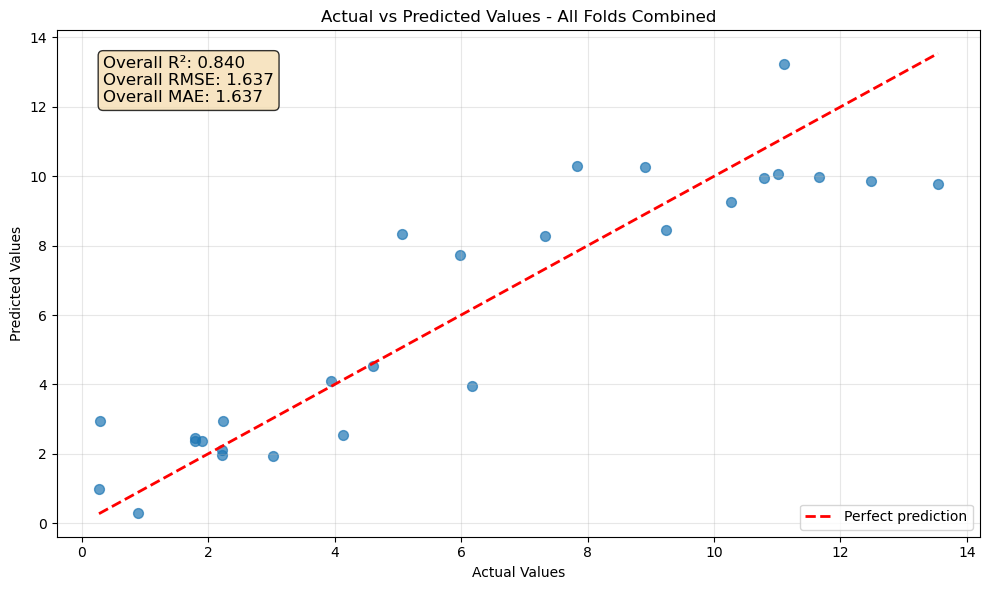


Feature Importance (Permutation Importance):
                           feature  importance
              initial_bulk_density    0.279020
consolidation_:_effective_pressure    0.222306
               initial_voids_ratio    0.071017
                     damping_ratio    0.041830


In [131]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(2626919)
np.random.seed(2626919)

# Load the data
df = final_pinn_per.copy()

# WE OBSERVED dry_density is highly correlated to voids ratio... So removed dry density
# Define feature and target columns
feature_cols = [
    'damping_ratio', 'initial_bulk_density', 'initial_voids_ratio',
    'consolidation_:_effective_pressure'
]
target_col = 'failure_stress'

# Drop rows with missing values in features or target
df = df.dropna(subset=feature_cols + [target_col])

print(f"Available samples: {len(df)}")

# Prepare data
X = df[feature_cols].values
y = df[target_col].values

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=2626919)

# Define the ANN model
class ANN(nn.Module):
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Store results for each fold
fold_results = []
all_y_test = []
all_y_pred = []

# 5-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\n=== Fold {fold + 1}/5 ===")
    
    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale the features and target
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled.astype(np.float32))
    y_train_tensor = torch.FloatTensor(y_train_scaled.astype(np.float32))
    X_test_tensor = torch.FloatTensor(X_test_scaled.astype(np.float32))
    y_test_tensor = torch.FloatTensor(y_test_scaled.astype(np.float32))
    
    # Initialize model
    model = ANN(X_train_scaled.shape[1])
    model = model.float()
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 2500
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train_tensor)
        loss = criterion(outputs.squeeze(), y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs.squeeze(), y_test_tensor)
        
        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    # Final prediction and evaluation for this fold
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor).numpy()
    
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_original = y_test
    
    # Calculate metrics
    r2 = r2_score(y_test_original, y_pred)
    rmse = mean_squared_error(y_test_original, y_pred, squared=False)
    mae = mean_squared_error(y_test_original, y_pred, squared=False)
    
    # Store results
    fold_results.append({
        'r2': r2,
        'rmse': rmse,
        'mae': mae
    })
    
    # Store predictions for overall analysis
    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred)
    
    print(f"Fold {fold + 1} Results: R²: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")

# Calculate mean metrics across folds
mean_r2 = np.mean([result['r2'] for result in fold_results])
std_r2 = np.std([result['r2'] for result in fold_results])
mean_rmse = np.mean([result['rmse'] for result in fold_results])
std_rmse = np.std([result['rmse'] for result in fold_results])
mean_mae = np.mean([result['mae'] for result in fold_results])
std_mae = np.std([result['mae'] for result in fold_results])

# Overall metrics
overall_r2 = r2_score(all_y_test, all_y_pred)
overall_rmse = mean_squared_error(all_y_test, all_y_pred, squared=False)
overall_mae = mean_squared_error(all_y_test, all_y_pred, squared=False)

# Print results
print(f"\nMean R²: {mean_r2:.3f} ± {std_r2:.3f}")
print(f"Mean RMSE: {mean_rmse:.3f} ± {std_rmse:.3f}")
print(f"Mean MAE: {mean_mae:.3f} ± {std_mae:.3f}")

print(f"\nOverall Metrics (all folds combined):")
print(f"R²: {overall_r2:.3f}")
print(f"RMSE: {overall_rmse:.3f}")
print(f"MAE: {overall_mae:.3f}")

# Create actual vs predicted plot with metrics inside
plt.figure(figsize=(10, 6))
plt.scatter(all_y_test, all_y_pred, alpha=0.7, s=50)
max_val = max(max(all_y_test), max(all_y_pred))
min_val = min(min(all_y_test), min(all_y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')

# Add metrics text inside the plot
textstr = f'Overall R²: {overall_r2:.3f}\nOverall RMSE: {overall_rmse:.3f}\nOverall MAE: {overall_mae:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - All Folds Combined')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance using the last fold's model
def permutation_importance(model, X_tensor, y_tensor, metric=r2_score, n_repeats=5):
    """Calculate permutation feature importance"""
    model.eval()
    with torch.no_grad():
        baseline_pred = model(X_tensor).numpy()
        baseline_score = metric(y_tensor.numpy(), baseline_pred.flatten())
    
    importance_scores = np.zeros(X_tensor.shape[1])
    
    for feature_idx in range(X_tensor.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_tensor.clone()
            X_permuted[:, feature_idx] = X_permuted[torch.randperm(X_permuted.size(0)), feature_idx]
            
            with torch.no_grad():
                perm_pred = model(X_permuted).numpy()
                score = metric(y_tensor.numpy(), perm_pred.flatten())
                scores.append(score)
        
        importance_scores[feature_idx] = baseline_score - np.mean(scores)
    
    return importance_scores

# Calculate feature importance
feature_importance = permutation_importance(model, X_test_tensor, y_test_tensor, n_repeats=5)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Permutation Importance):")
print(importance_df.to_string(index=False))

# MOST IDEAL WITH OPTIMAL EXPLAINED REGRESSION VALUE OF 0.84 AND NO OBSERVED MULTI-COLLINEARITY 

# Final graph

C:\Users\arunj\AppData\Local\Temp\ipykernel_49096\4114481855.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([feature_names.get(f, f) for f in importance_df1['feature']])
C:\Users\arunj\AppData\Local\Temp\ipykernel_49096\4114481855.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([feature_names.get(f, f) for f in importance_df2['feature']])


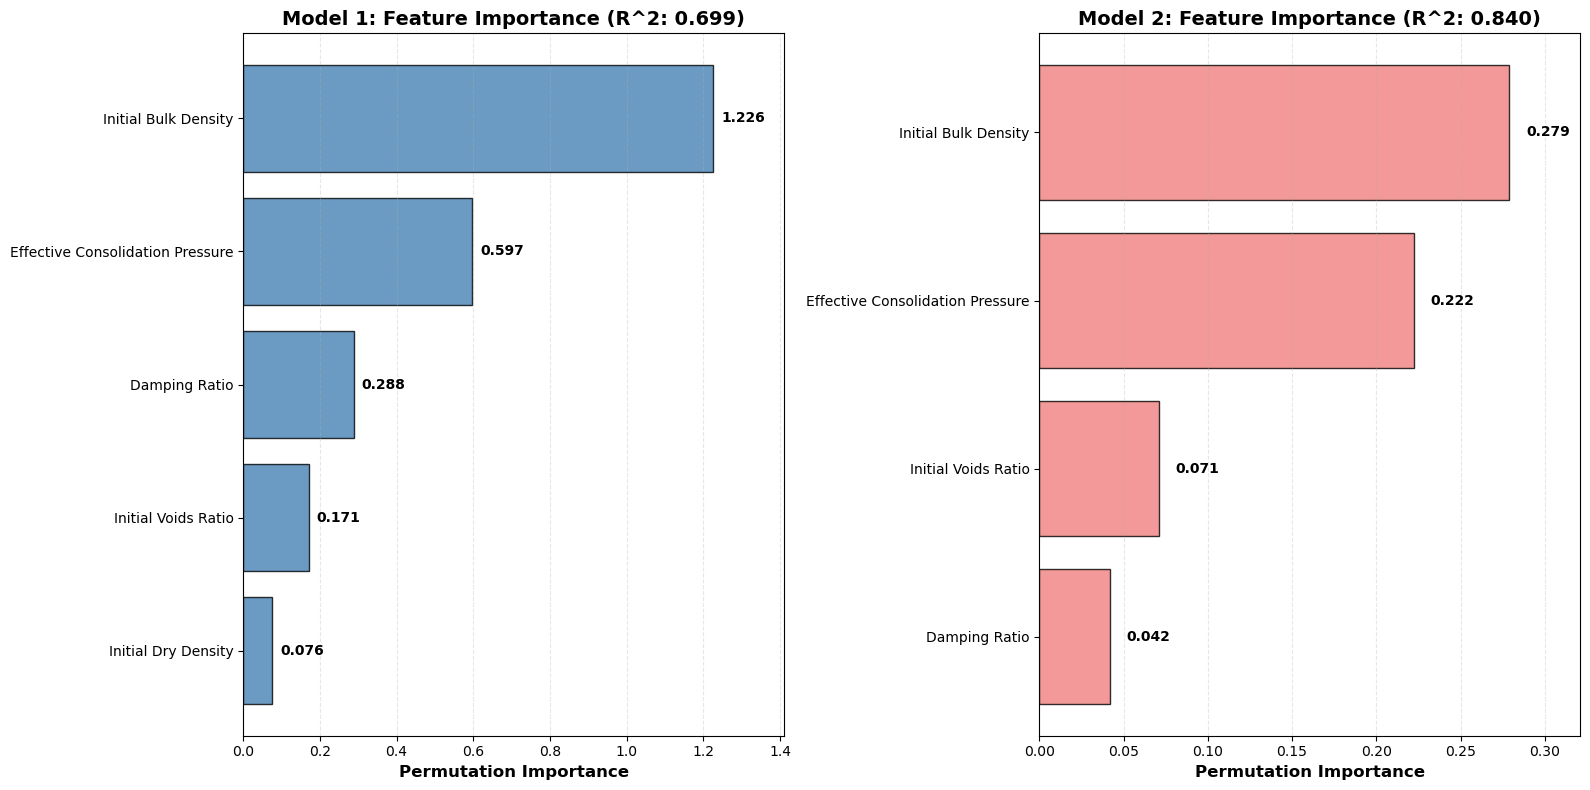

Model 1 - Feature Importance Ranking: (R^2: 0.699)
               Initial Bulk Density:   1.226
   Effective Consolidation Pressure:   0.597
                      Damping Ratio:   0.288
                Initial Voids Ratio:   0.171
                Initial Dry Density:   0.076

Model 2 - Feature Importance Ranking: (R^2: 0.840)
               Initial Bulk Density:   0.279
   Effective Consolidation Pressure:   0.222
                Initial Voids Ratio:   0.071
                      Damping Ratio:   0.042


In [212]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Data for the first graph (original)
importance_data1 = {
    'feature': [
        'initial_bulk_density',
        'consolidation_:_effective_pressure',
        'damping_ratio',
        'initial_voids_ratio',
        'initial_dry_density'
    ],
    'importance': [
        1.226075,
        0.597497,
        0.288336,
        0.171403,
        0.075809
    ]
}

# Data for the second graph (new)
importance_data2 = {
    'feature': [
        'initial_bulk_density',
        'consolidation_:_effective_pressure',
        'initial_voids_ratio',
        'damping_ratio'
    ],
    'importance': [
        0.279020,
        0.222306,
        0.071017,
        0.041830
    ]
}

# Create DataFrames
importance_df1 = pd.DataFrame(importance_data1)
importance_df2 = pd.DataFrame(importance_data2)

# Sort by importance
importance_df1 = importance_df1.sort_values('importance', ascending=True)
importance_df2 = importance_df2.sort_values('importance', ascending=True)

# Create the first plot (left)
bars1 = ax1.barh(importance_df1['feature'], importance_df1['importance'], 
                 color='steelblue', alpha=0.8, edgecolor='black')

# Add values on bars for first plot
for i, (value, feature) in enumerate(zip(importance_df1['importance'], importance_df1['feature'])):
    ax1.text(value + 0.02, i, f'{value:.3f}', 
             va='center', fontweight='bold', fontsize=10)

# Customize the first plot
ax1.set_xlabel('Permutation Importance', fontsize=12, fontweight='bold')
ax1.set_title('Model 1: Feature Importance (R^2: 0.699)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.set_xlim(0, max(importance_df1['importance']) * 1.15)

# Create the second plot (right)
bars2 = ax2.barh(importance_df2['feature'], importance_df2['importance'], 
                 color='lightcoral', alpha=0.8, edgecolor='black')

# Add values on bars for second plot
for i, (value, feature) in enumerate(zip(importance_df2['importance'], importance_df2['feature'])):
    ax2.text(value + 0.01, i, f'{value:.3f}', 
             va='center', fontweight='bold', fontsize=10)

# Customize the second plot
ax2.set_xlabel('Permutation Importance', fontsize=12, fontweight='bold')
ax2.set_title('Model 2: Feature Importance (R^2: 0.840)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.set_xlim(0, max(importance_df2['importance']) * 1.15)

# Improve feature names for display in both plots
feature_names = {
    'initial_bulk_density': 'Initial Bulk Density',
    'consolidation_:_effective_pressure': 'Effective Consolidation Pressure',
    'damping_ratio': 'Damping Ratio',
    'initial_voids_ratio': 'Initial Voids Ratio',
    'initial_dry_density': 'Initial Dry Density'
}

ax1.set_yticklabels([feature_names.get(f, f) for f in importance_df1['feature']])
ax2.set_yticklabels([feature_names.get(f, f) for f in importance_df2['feature']])

plt.tight_layout()
plt.show()

# Print the importance values for reference
print("Model 1 - Feature Importance Ranking: (R^2: 0.699)")
print("=" * 50)
for i, row in importance_df1.sort_values('importance', ascending=False).iterrows():
    print(f"{feature_names.get(row['feature'], row['feature']):>35}: {row['importance']:>7.3f}")

print("\nModel 2 - Feature Importance Ranking: (R^2: 0.840)")
print("=" * 50)
for i, row in importance_df2.sort_values('importance', ascending=False).iterrows():
    print(f"{feature_names.get(row['feature'], row['feature']):>35}: {row['importance']:>7.3f}")

# THANK YOU MAIN DATA ANALYSIS DONE...

# ----------------------------------------------------------------------

# Additional data analysis with much better PREDICTION TRAINING PARAMTERS such as NON-Zero Damping ratios, ALTHOUGH LIMITED AVAILABILITY OF FEATURES

In [149]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from   scipy.optimize import curve_fit
import torch, torch.nn as nn

torch.set_default_dtype(torch.float64)

path=r"C:\Users\arunj\Downloads\AGS File_Project_B.xlsx"


def clean_column_names(df,val):
    def _clean(name):
        # 1) Strip whitespace
        name = name.strip()
        # 2) Replace spaces/slashes with underscore
        name = re.sub(r"[ /]+", "_", name)
        # 3) Remove commas, parentheses, percent signs, quotes
        name = re.sub(r"[,\(\)%'\"]+", "", name)
        # 4) Collapse multiple underscores
        name = re.sub(r"_+", "_", name)
        # 5) Lowercase
        return name.lower()
    
    df = df.rename(columns=_clean)
    
    # Create a sorted temporary DataFrame to get the group mapping
    temp_df = df.sort_values(['bulk_density', 'void_ratio', 'effective_conf_stress'])
    group_mapping = (temp_df.groupby(['bulk_density', 'void_ratio', 'effective_conf_stress'])
                .ngroup()
                .add(1)
                .astype(str))

# Apply the mapping to the original DataFrame
    df['sample'] = val +'_'+ 'soil_sample_' + df.index.map(group_mapping)
    return df

# Usage
# table2 = clean_column_names(table2)
# Now columns like "Shear Modulus, G (Mpa)" become "shear_modulus_g_mpa"


def cleaning(df_total,val):
    df_total.columns=df_total.iloc[0]
    df_total.reset_index(inplace=True)
    df_total=df_total.iloc[2:,1:]
    df_total=df_total.dropna(how="all")
    
    
    
    return clean_column_names(df_total.iloc[1:,:],val)



def reading_data(path,val):
    df=pd.read_excel(path,val)
    columns=list(df.columns)
    head=columns[0]
    indexes=[]
    for idx, rows in df.iterrows():
        if rows[head]==r"Bulk density":
            indexes.append(idx)

    idx1=indexes[0]
    
    df_table1=df.iloc[idx1:,:]

    return cleaning(df_table1,val)

table1=reading_data(path,'P1_Test1')
table2=reading_data(path,'P1_Test2')
table3=reading_data(path,'P1_Test3')
table4=reading_data(path,'P2_Test4')
table=pd.concat([table1,table2,table3,table4], axis=0)
table = table.reset_index(drop=True)
# Move the last column to the 4th position
table.insert(3, 'sample', table.pop('sample'))

table1=table.iloc[:,0:4]
table2=table.iloc[:,3:]
# Move the last column to the 4th position

table1.insert(0, 'sample', table1.pop('sample'))

table1 = table1.rename(columns={
    'void_ratio': 'initial_voids_ratio',
    'effective_conf_stress': 'consolidation_:_effective_pressure',
    'bulk_density':'initial_bulk_density'
})

table1.drop_duplicates(inplace=True)
table1=table1.reset_index(drop=True)

table2 = table2.rename(columns={
    'shear_modulus_mpa': 'shear_modulus_g_mpa',
    'average_shear_strain_percent': 'average_shear_strain'
})

table2["sample"] = table2["sample"].astype("category")
table2["reading"] = table2["reading"].astype("category")
table2["average_shear_strain"] = table2["average_shear_strain"].astype(float)
table2["shear_modulus_g_mpa"] = table2["shear_modulus_g_mpa"].astype(float)
table2["g_gmax"] = table2["g_gmax"].astype(float)
table2["damping_ratio"] = table2["damping_ratio"].astype(float)

C:\Users\arunj\AppData\Local\Temp\ipykernel_49096\2256295993.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(meta_cols, as_index=False)[["average_shear_strain","damping_ratio"]]


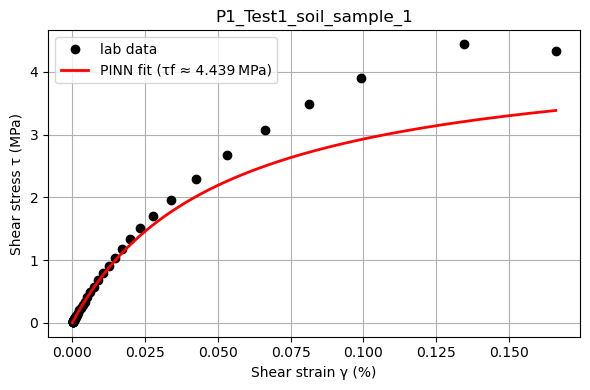

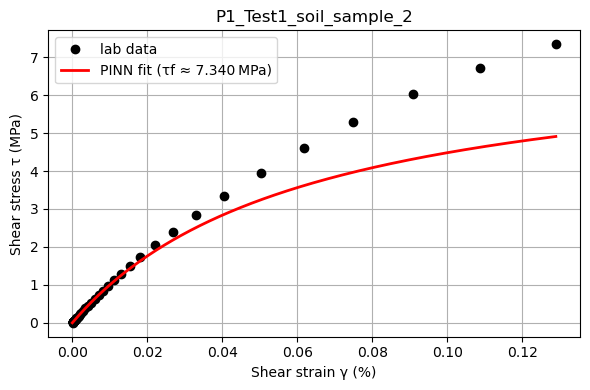

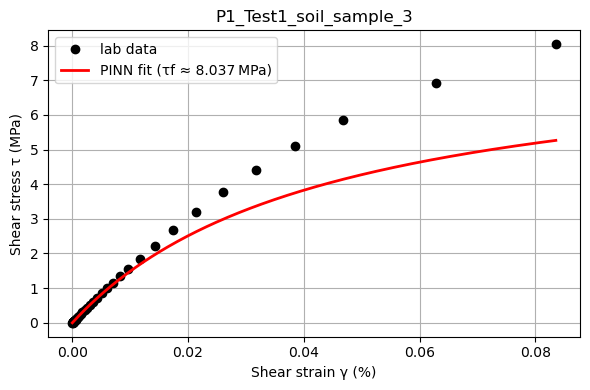

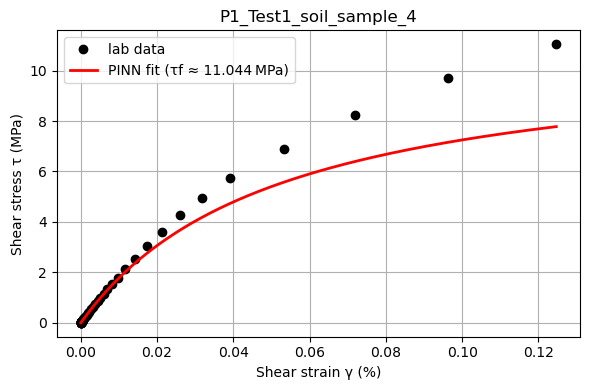

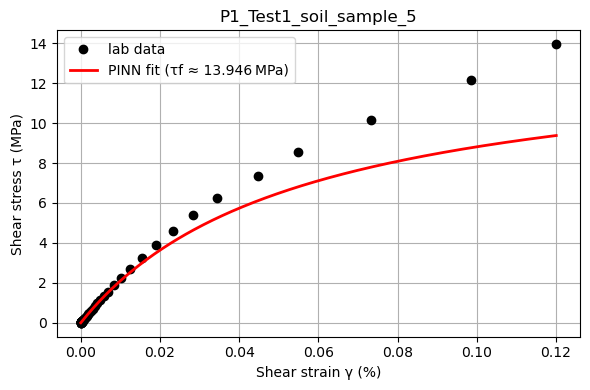

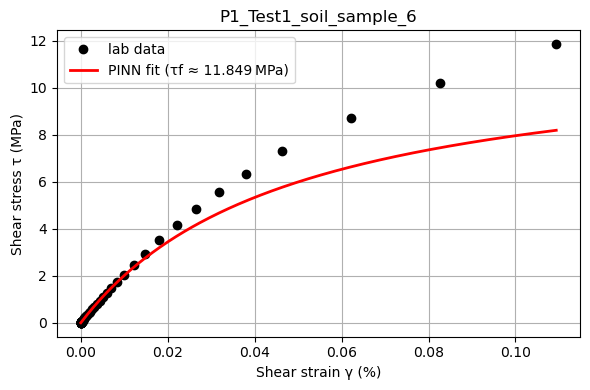

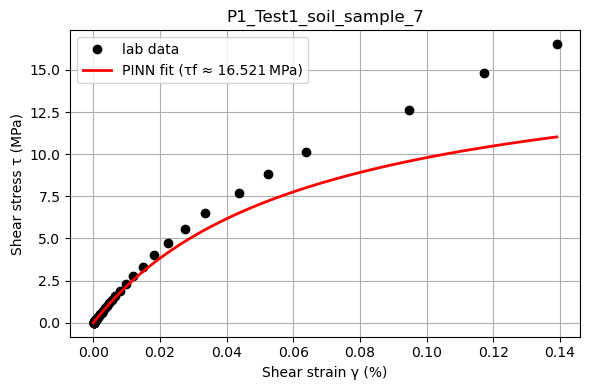

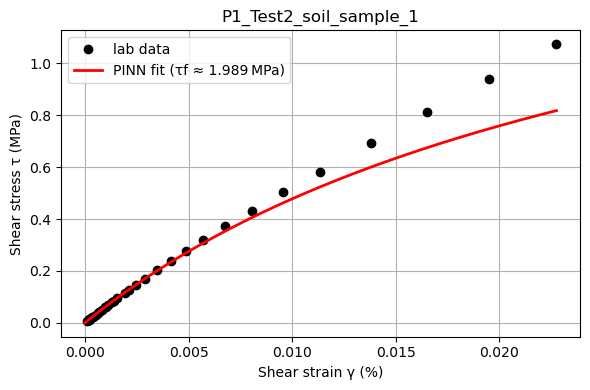

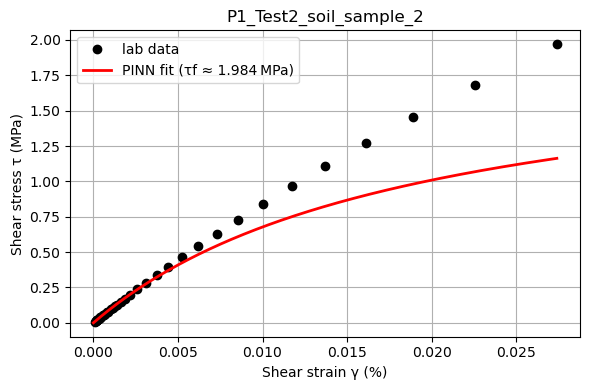

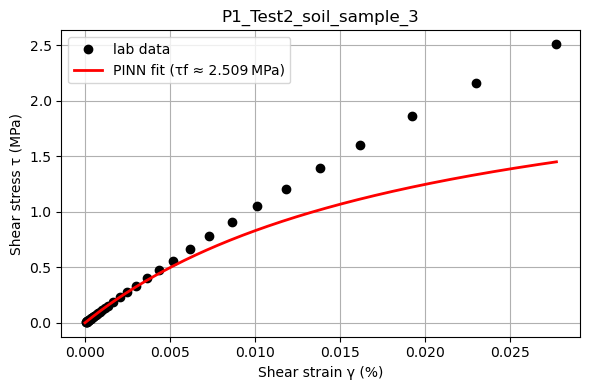

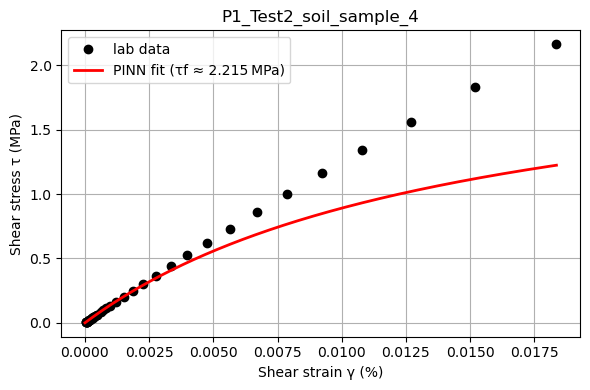

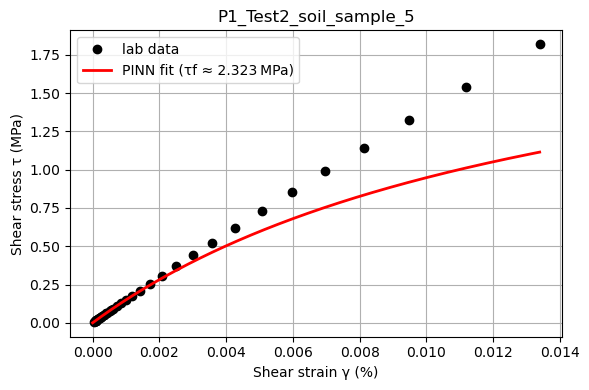

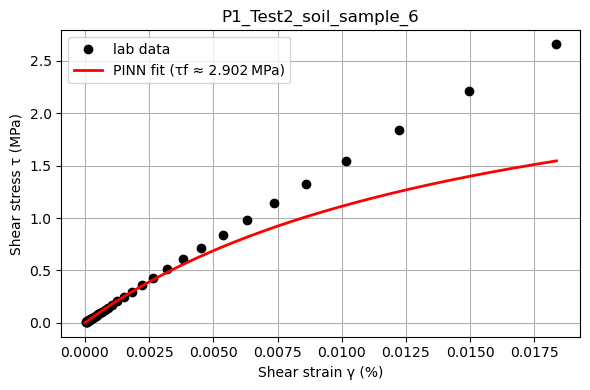

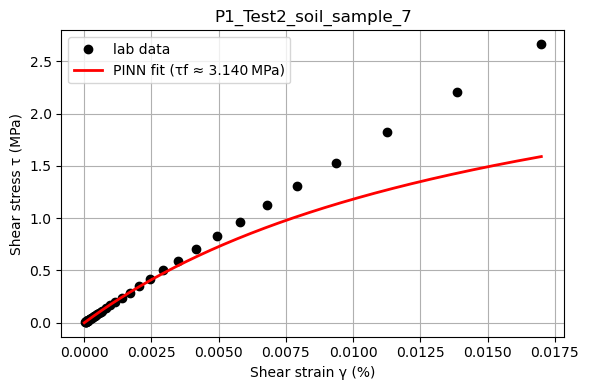

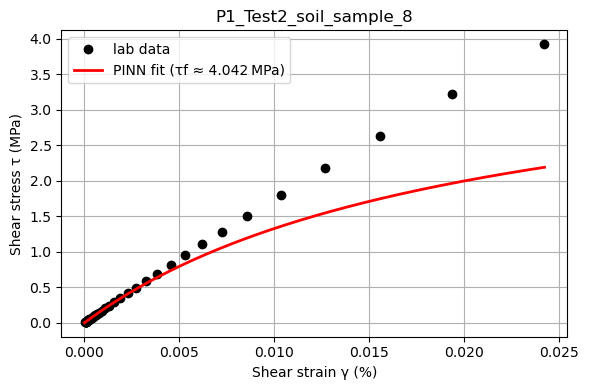

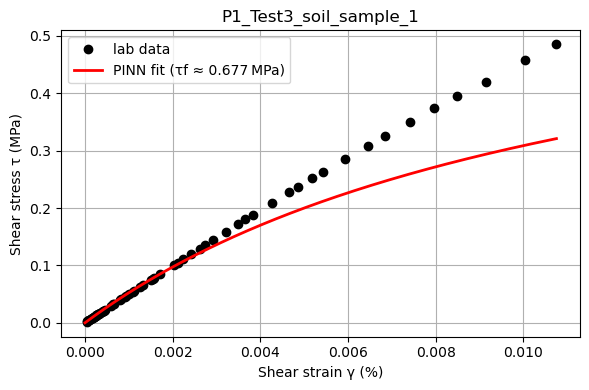

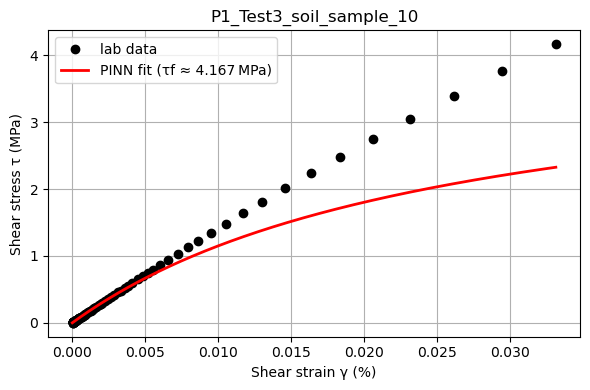

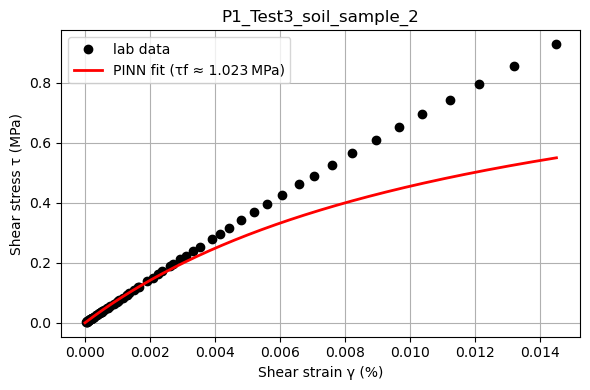

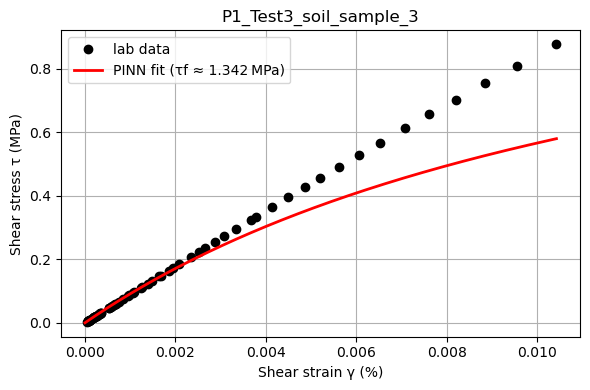

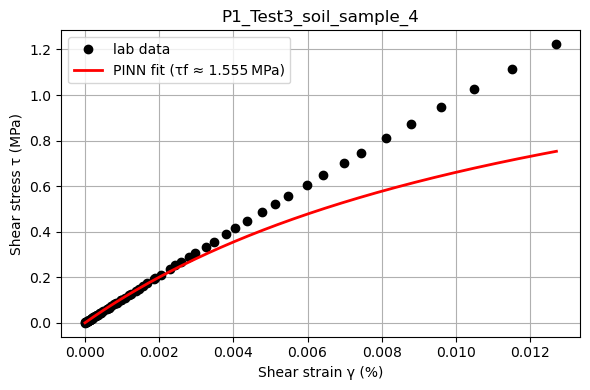

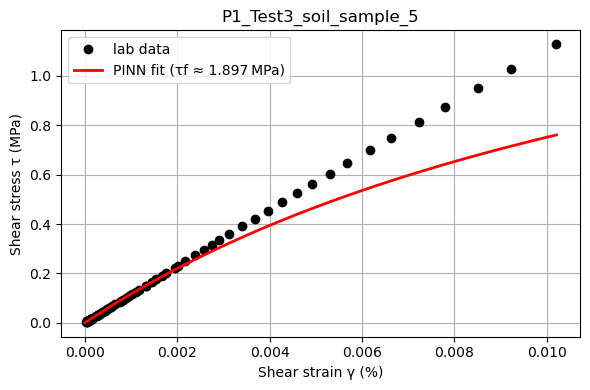

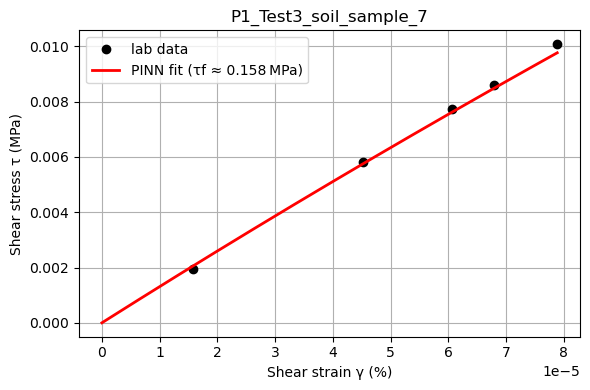

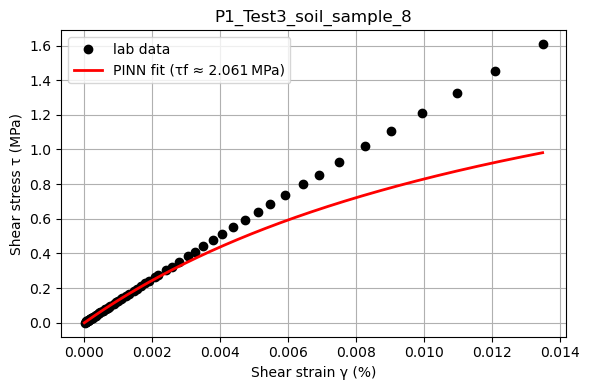

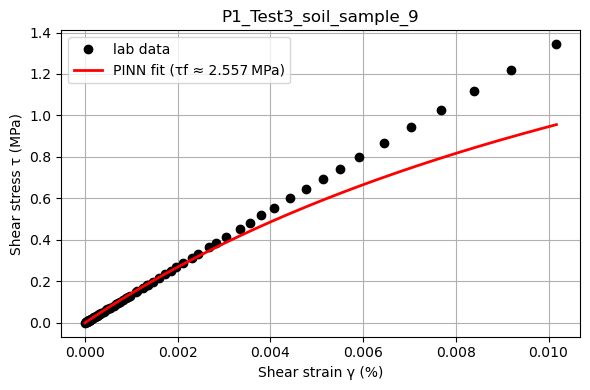

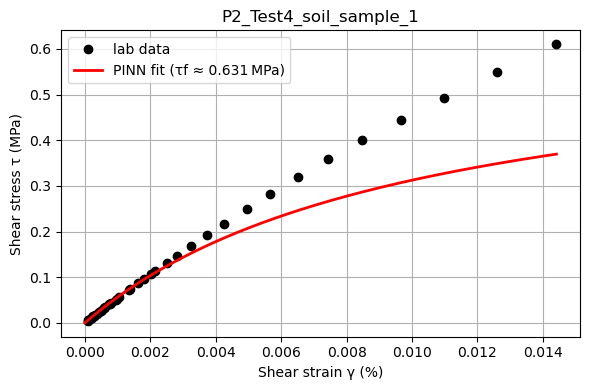

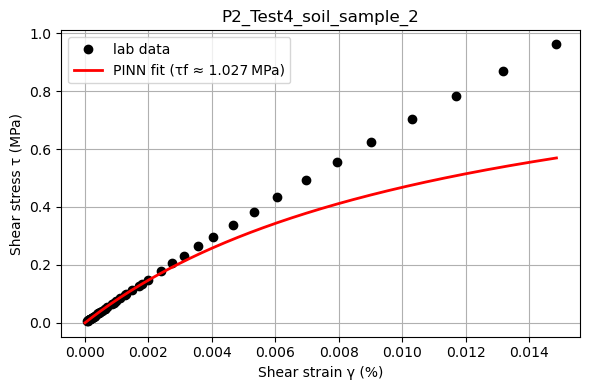

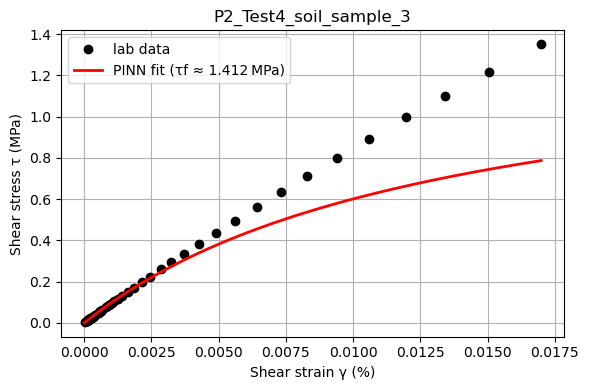

7                    sample  n_readings  failure_stress  predicted_g_max  \
0    P1_Test1_soil_sample_1        48.0        4.439299        87.324901   
1    P1_Test1_soil_sample_2        49.0        7.339999       116.048604   
2    P1_Test1_soil_sample_3        48.0        8.037212       182.553684   
3    P1_Test1_soil_sample_4        50.0       11.044232       212.230720   
4    P1_Test1_soil_sample_5        51.0       13.946321       249.583958   
5    P1_Test1_soil_sample_6        50.0       11.849240       242.452721   
6    P1_Test1_soil_sample_7        52.0       16.521375       254.494946   
7    P1_Test2_soil_sample_1        36.0        1.989211        65.235208   
8    P1_Test2_soil_sample_2        40.0        1.983539       103.174389   
9    P1_Test2_soil_sample_3        41.0        2.509425       124.043407   
10   P1_Test2_soil_sample_4        40.0        2.215289       148.855245   
11   P1_Test2_soil_sample_5        39.0        2.323208       160.557191   
12   P1_Test2_soil_sample_6        41.0        2.901512       180.668013   
13   P1_Test2_soil_sample_7        41.0        3.140250       189.991020   
14   P1_Test2_soil_sample_8        43.0        4.042212       198.331816   
15   P1_Test3_soil_sample_1        63.0        0.676905        56.765887   
16  P1_Test3_soil_sample_10        87.0        4.167487       159.157101   
17   P1_Test3_soil_sample_2        72.0        1.023145        82.062454   
18   P1_Test3_soil_sample_3        71.0        1.341579        98.113602   
19   P1_Test3_soil_sample_4        75.0        1.555206       114.840314   
20   P1_Test3_soil_sample_5        74.0        1.896709       124.576178   
21   P1_Test3_soil_sample_6         2.0             NaN              NaN   
22   P1_Test3_soil_sample_7         5.0        0.157738       132.076566   
23   P1_Test3_soil_sample_8        71.0        2.061034       138.793600   
24   P1_Test3_soil_sample_9        76.0        2.556690       150.118545   
25   P2_Test4_soil_sample_1        43.0        0.630585        61.958762   
26   P2_Test4_soil_sample_2        46.0        1.026856        85.957570   
27   P2_Test4_soil_sample_3        49.0        1.412125       104.652617   

7   damping_ratio  initial_bulk_density  initial_voids_ratio  \
0        1.456482              1.955632             0.763841   
1        0.893950              1.958835             0.757968   
2        0.247463              1.959587             0.756593   
3        0.401696              1.959909             0.756007   
4        0.345330              1.960290             0.755311   
5        0.308919              1.960400             0.755112   
6        0.396640              1.960754             0.754467   
7        0.426497              2.003710             0.709237   
8        0.157910              2.005333             0.706487   
9        0.183035              2.006310             0.704834   
10       0.044972              2.007605             0.702649   
11       0.032165              2.008414             0.701288   
12       0.021677              2.009599             0.699297   
13       0.005849              2.010460             0.697854   
14       0.043650              2.012181             0.694975   
15       0.071124              1.997127             0.692244   
16       0.023336              2.008231             0.673662   
17       0.037409              1.999787             0.687756   
18       0.004888              2.001329             0.685165   
19       0.043948              2.002618             0.683004   
20       0.007106              2.003770             0.681079   
21       0.004888              2.004747             0.679449   
22       0.004888              2.004747             0.679449   
23       0.013255              2.004747             0.679449   
24       0.019096              2.005806             0.677687   
25       0.230333              1.993835             0.753075   
26       0.122598              1.995656             0.749879   
27 

In [155]:
# ───────────────────────── 1. build table3 (distinct metadata) ──────────
meta_cols = ["sample"]

table3 = (
    table2
    .groupby(meta_cols, as_index=False)[["average_shear_strain","damping_ratio"]]
    .mean()
    .loc[lambda d: d["average_shear_strain"] > 0]
    .reset_index(drop=True)
)

# ─── add columns to hold PINN outputs + counts ──────────────────────────
# Core PINN outputs:
table3["tou_f"]                  = np.nan
# (failure_stress renamed later)
table3["predicted_g_max"]        = np.nan
# raw modulus comparison:
table3["max_shear_modulus_g_mpa"]= np.nan
# fit error percentage:
table3["error_pct"]              = np.nan
# count of readings for quality check:
table3["n_readings"]             = np.nan   # new column

# --- Additional constitutive parameters ---
# Compute and add the PINN’s curvature exponent 'c' parameter:
table3["c_param"] = np.nan

# Compute G/Gmax reduction at fixed strains (e.g., 0.01%, 0.1%, 1%):
fixed_strains = [0.0001, 0.001, 0.01]
for eps in fixed_strains:
    table3[f"GoverGmax_{eps}"] = np.nan
# Merge soil-index and stratigraphic data from table1 later
# Link to design/use-case (e.g., Vs for Eurocode) later

# ───────── helper: hyperbola + PINN classes ─────────
def hyper(g, a, b, c):
    return g / np.clip(a + b * g**c, 1e-6, None)

class PINN(nn.Module):
    def __init__(self, a0, b0, c0):
        super().__init__()
        self.a = nn.Parameter(torch.tensor([a0]))
        self.b = nn.Parameter(torch.tensor([b0]))
        self.c_raw = nn.Parameter(torch.tensor([np.log(c0/(1-c0))]))
    def forward(self, x):
        c = torch.sigmoid(self.c_raw)
        return x / torch.clamp(self.a + self.b * x.pow(c), min=1e-6)
    def residual(self, x, y):
        c = torch.sigmoid(self.c_raw)
        return y * (self.a + self.b * x.pow(c)) - x

# ───────────────────────── 2. iterate each metadata combo ───────────────
for idx, meta in table3.iterrows():

    # subset rows for this metadata
    m = (
        (table2["sample"] == meta["sample"])
    )
    df_sub = table2.loc[m].copy()
    df_sub = df_sub[df_sub["average_shear_strain"] > 0]   # keep positive γ

    # record total readings
    n_reads = len(df_sub)
    table3.at[idx, "n_readings"] = n_reads

    if n_reads < 4:
        continue

    # record the group's max raw modulus
    G_raw_max = df_sub["shear_modulus_g_mpa"].max()
    table3.at[idx, "max_shear_modulus_g_mpa"] = G_raw_max

    γ = df_sub["average_shear_strain"].astype(float).values          # fraction
    τ = df_sub["shear_modulus_g_mpa"].astype(float).values * γ       # MPa

    # rising branch
    pk = τ.argmax()
    γ_r, τ_r = γ[:pk+1], τ[:pk+1]
    τ_peak   = τ_r[-1]

    # ── SciPy warm start ─────────────────────────────
    a0 = 1/df_sub["shear_modulus_g_mpa"].iloc[0]
    b0 = 1/τ_peak
    c0 = 0.5
    try:
        a_s, b_s, c_s = curve_fit(
            hyper, γ_r, τ_r,
            p0=[a0,b0,c0],
            bounds=([0,0,0],[np.inf,np.inf,1]),
            max_nfev=8000
        )[0]
    except RuntimeError:
        continue

    # ── train PINN ───────────────────────────────────
    g_t = torch.tensor(γ_r).unsqueeze(1)
    t_t = torch.tensor(τ_r).unsqueeze(1)
    model = PINN(a_s, b_s, c_s)
    opt   = torch.optim.Adam(model.parameters(), lr=5e-3)
    λ_phys, λ_anchor, eps = 0.5, 20.0, 1e-12
##CHANGEEEEEEEEEEEEEEEEEEEEEEEE....
    for epoch in range(2500):
        opt.zero_grad()
        τ_pred = model(g_t)
        loss = (
            (torch.log(τ_pred+eps) - torch.log(t_t+eps)).pow(2).mean()
            + λ_phys  * model.residual(g_t, t_t).pow(2).mean()
            + λ_anchor* (1/model.b - τ_peak)**2
        )
        loss.backward(); opt.step()

    # ── extract PINN results ───────────────────────────
    τf_pin    = (1/model.b).item()
    gmax_pred = (1/model.a).item()
    c_par = torch.sigmoid(model.c_raw).item()

    # ── write back into table3 ─────────────────────────
    table3.at[idx, "tou_f"]           = τf_pin
    table3.at[idx, "predicted_g_max"] = gmax_pred
    table3.at[idx, "error_pct"]       = (gmax_pred - G_raw_max)/G_raw_max * 100
    table3.at[idx, "c_param"] = c_par

    # ── compute G/Gmax at fixed reference strains ───────────
    for eps in fixed_strains:
        τ_at_eps = model(torch.tensor([eps]).unsqueeze(1)).item()
        G_at_eps = τ_at_eps / eps if eps > 1e-10 else gmax_pred
        G_over_Gmax = G_at_eps / gmax_pred
        table3.at[idx, f"GoverGmax_{eps}"] = G_over_Gmax

    # ── plot ─────────────────────────────────────────
    γ_grid = np.linspace(0, γ.max(), 300)
    τ_grid = model(torch.tensor(γ_grid).unsqueeze(1)).detach().numpy()

    plt.figure(figsize=(6,4))
    plt.plot(γ, τ, "ko", label="lab data")
    plt.plot(γ_grid, τ_grid, "r-", lw=2,
             label=f"PINN fit (τf ≈ {τf_pin:.3f} MPa)")
    title = (f"{meta['sample']}")
    plt.title(title)
    plt.xlabel("Shear strain γ (%)"); plt.ylabel("Shear stress τ (MPa)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# remove the summed‐strain column
table3 = table3.drop(columns=["average_shear_strain"])

# rename the PINN failure‐stress column
table3 = table3.rename(columns={"tou_f": "failure_stress"})

# 1. define the columns you want from the summary (previously table3) and from table1
t3_cols = [
    "sample",
    "n_readings",
    "failure_stress",
    "predicted_g_max",
    "damping_ratio",
    "max_shear_modulus_g_mpa",
    "error_pct",
    'c_param',
    'GoverGmax_0.0001', 'GoverGmax_0.001', 'GoverGmax_0.01'
]
t1_cols = [
    "sample",
    "initial_bulk_density",
    "initial_voids_ratio",
    "consolidation_:_effective_pressure"
]

# 2. slice out only those columns
t3_sel = table3[t3_cols]
t1_sel = table1[t1_cols]

# 3. perform the outer join on the four metadata keys
final = pd.merge(
    t3_sel,
    t1_sel,
    on=["sample"],
    how="outer",
)

final['max_shear_modulus_g_mpa']=final['max_shear_modulus_g_mpa'].astype(float)
final['initial_bulk_density']=final['initial_bulk_density'].astype(float)

#CHANGEEEEEEEEEEEEEEEEEEEEEEEEE HEREEEE.........
final['vs_avg'] = np.sqrt((final['predicted_g_max'] * 1e6) / (final['initial_bulk_density'] * 1000))

cols_to_drop = ["max_shear_modulus_g_mpa", "error_pct"]
final = final.drop(columns=[c for c in cols_to_drop if c in final.columns])

for i in final.columns:
    if i not in ['sample']:
        final[i]=final[i].astype(float)
        
final_total=final.copy() #CONSOLIDATED TABLE

true_cols = [
    'sample',
    'n_readings',
    'failure_stress',
    'predicted_g_max',
    'damping_ratio',
    'initial_bulk_density',
    'initial_voids_ratio',
    'consolidation_:_effective_pressure',
    'vs_avg',
    'c_param',
    'GoverGmax_0.0001', 'GoverGmax_0.001', 'GoverGmax_0.01'
]

# this is the correct way to subset by columns:
final = final[true_cols]

# Identify numeric columns (UMAP can accept all numeric, incl. integers)
feature_cols = final.select_dtypes(include=["int64", "float64"]).columns.tolist()
final

In [156]:
table3.dropna(inplace=True)
final.dropna(inplace=True)
final_total.dropna(inplace=True)

Available samples: 27

=== Fold 1/5 ===
Epoch [500/2500], Train Loss: 0.0177, Val Loss: 0.0420
Epoch [1000/2500], Train Loss: 0.0150, Val Loss: 0.0408
Epoch [1500/2500], Train Loss: 0.0490, Val Loss: 0.0398
Epoch [2000/2500], Train Loss: 0.0160, Val Loss: 0.0425
Epoch [2500/2500], Train Loss: 0.0338, Val Loss: 0.0447
Fold 1 Results: R²: 0.948, RMSE: 0.913, MAE: 0.913

=== Fold 2/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0190, Val Loss: 0.0414
Epoch [1000/2500], Train Loss: 0.0125, Val Loss: 0.0367
Epoch [1500/2500], Train Loss: 0.0158, Val Loss: 0.0284
Epoch [2000/2500], Train Loss: 0.0227, Val Loss: 0.0428
Epoch [2500/2500], Train Loss: 0.0114, Val Loss: 0.0434
Fold 2 Results: R²: 0.919, RMSE: 0.944, MAE: 0.944

=== Fold 3/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0274, Val Loss: 0.0156
Epoch [1000/2500], Train Loss: 0.0273, Val Loss: 0.0256
Epoch [1500/2500], Train Loss: 0.0345, Val Loss: 0.0399
Epoch [2000/2500], Train Loss: 0.0266, Val Loss: 0.0438
Epoch [2500/2500], Train Loss: 0.0114, Val Loss: 0.0607
Fold 3 Results: R²: 0.828, RMSE: 1.125, MAE: 1.125

=== Fold 4/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0881, Val Loss: 0.1582
Epoch [1000/2500], Train Loss: 0.0132, Val Loss: 0.1959
Epoch [1500/2500], Train Loss: 0.0229, Val Loss: 0.2455
Epoch [2000/2500], Train Loss: 0.0233, Val Loss: 0.2854
Epoch [2500/2500], Train Loss: 0.0197, Val Loss: 0.1904
Fold 4 Results: R²: 0.952, RMSE: 1.398, MAE: 1.398

=== Fold 5/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0143, Val Loss: 0.0581
Epoch [1000/2500], Train Loss: 0.0145, Val Loss: 0.0581
Epoch [1500/2500], Train Loss: 0.0099, Val Loss: 0.0634
Epoch [2000/2500], Train Loss: 0.0468, Val Loss: 0.0568
Epoch [2500/2500], Train Loss: 0.0196, Val Loss: 0.0670
Fold 5 Results: R²: 0.162, RMSE: 1.184, MAE: 1.184

Mean R²: 0.762 ± 0.303
Mean RMSE: 1.113 ± 0.176
Mean MAE: 1.113 ± 0.176

Overall Metrics (all folds combined):
R²: 0.933
RMSE: 1.113
MAE: 1.113


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

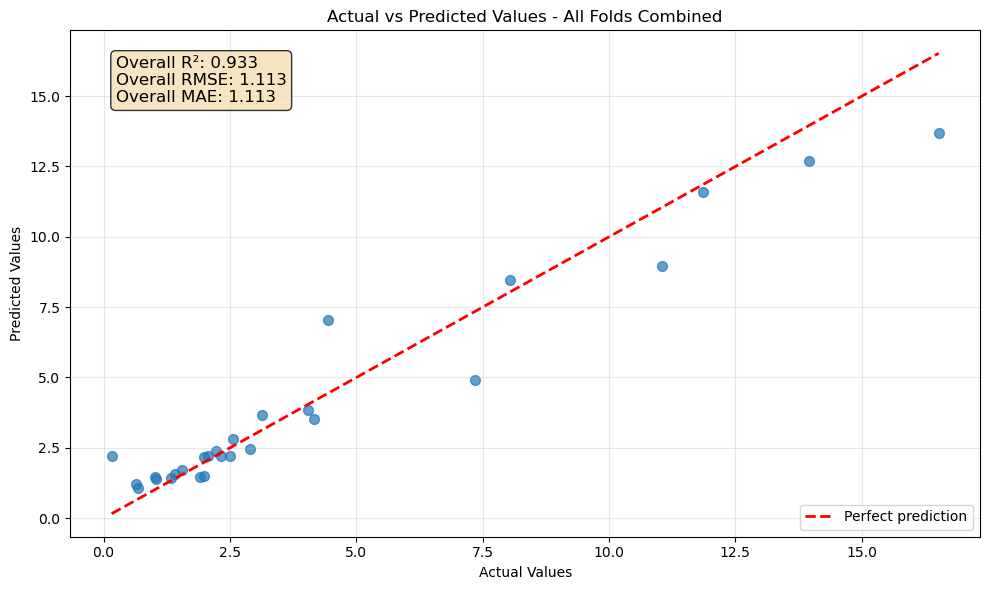


Feature Importance (Permutation Importance):
                           feature  importance
              initial_bulk_density    6.005604
consolidation_:_effective_pressure    0.368195
               initial_voids_ratio   -0.512025


In [182]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(2626919)
np.random.seed(2626919)

# Load the data
df = final_total.copy()

# Define feature and target columns
feature_cols = [
    'initial_bulk_density', 'initial_voids_ratio',
    'consolidation_:_effective_pressure'
]
target_col = 'failure_stress'

# Drop rows with missing values in features or target
df = df.dropna(subset=feature_cols + [target_col])

print(f"Available samples: {len(df)}")

# Prepare data
X = df[feature_cols].values
y = df[target_col].values

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=2626919)

# Define the ANN model
class ANN(nn.Module):
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Store results for each fold
fold_results = []
all_y_test = []
all_y_pred = []

# 5-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\n=== Fold {fold + 1}/5 ===")
    
    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale the features and target
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled.astype(np.float32))
    y_train_tensor = torch.FloatTensor(y_train_scaled.astype(np.float32))
    X_test_tensor = torch.FloatTensor(X_test_scaled.astype(np.float32))
    y_test_tensor = torch.FloatTensor(y_test_scaled.astype(np.float32))
    
    # Initialize model
    model = ANN(X_train_scaled.shape[1])
    model = model.float()
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 2500
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train_tensor)
        loss = criterion(outputs.squeeze(), y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs.squeeze(), y_test_tensor)
        
        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    # Final prediction and evaluation for this fold
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor).numpy()
    
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_original = y_test
    
    # Calculate metrics
    r2 = r2_score(y_test_original, y_pred)
    rmse = mean_squared_error(y_test_original, y_pred, squared=False)
    mae = mean_squared_error(y_test_original, y_pred, squared=False)
    
    # Store results
    fold_results.append({
        'r2': r2,
        'rmse': rmse,
        'mae': mae
    })
    
    # Store predictions for overall analysis
    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred)
    
    print(f"Fold {fold + 1} Results: R²: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")

# Calculate mean metrics across folds
mean_r2 = np.mean([result['r2'] for result in fold_results])
std_r2 = np.std([result['r2'] for result in fold_results])
mean_rmse = np.mean([result['rmse'] for result in fold_results])
std_rmse = np.std([result['rmse'] for result in fold_results])
mean_mae = np.mean([result['mae'] for result in fold_results])
std_mae = np.std([result['mae'] for result in fold_results])

# Overall metrics
overall_r2 = r2_score(all_y_test, all_y_pred)
overall_rmse = mean_squared_error(all_y_test, all_y_pred, squared=False)
overall_mae = mean_squared_error(all_y_test, all_y_pred, squared=False)

# Print results
print(f"\nMean R²: {mean_r2:.3f} ± {std_r2:.3f}")
print(f"Mean RMSE: {mean_rmse:.3f} ± {std_rmse:.3f}")
print(f"Mean MAE: {mean_mae:.3f} ± {std_mae:.3f}")

print(f"\nOverall Metrics (all folds combined):")
print(f"R²: {overall_r2:.3f}")
print(f"RMSE: {overall_rmse:.3f}")
print(f"MAE: {overall_mae:.3f}")

# Create actual vs predicted plot with metrics inside
plt.figure(figsize=(10, 6))
plt.scatter(all_y_test, all_y_pred, alpha=0.7, s=50)
max_val = max(max(all_y_test), max(all_y_pred))
min_val = min(min(all_y_test), min(all_y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')

# Add metrics text inside the plot
textstr = f'Overall R²: {overall_r2:.3f}\nOverall RMSE: {overall_rmse:.3f}\nOverall MAE: {overall_mae:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - All Folds Combined')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance using the last fold's model
def permutation_importance(model, X_tensor, y_tensor, metric=r2_score, n_repeats=5):
    """Calculate permutation feature importance"""
    model.eval()
    with torch.no_grad():
        baseline_pred = model(X_tensor).numpy()
        baseline_score = metric(y_tensor.numpy(), baseline_pred.flatten())
    
    importance_scores = np.zeros(X_tensor.shape[1])
    
    for feature_idx in range(X_tensor.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_tensor.clone()
            X_permuted[:, feature_idx] = X_permuted[torch.randperm(X_permuted.size(0)), feature_idx]
            
            with torch.no_grad():
                perm_pred = model(X_permuted).numpy()
                score = metric(y_tensor.numpy(), perm_pred.flatten())
                scores.append(score)
        
        importance_scores[feature_idx] = baseline_score - np.mean(scores)
    
    return importance_scores

# Calculate feature importance
feature_importance = permutation_importance(model, X_test_tensor, y_test_tensor, n_repeats=5)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Permutation Importance):")
print(importance_df.to_string(index=False))

Available samples: 27

=== Fold 1/5 ===
Epoch [500/2500], Train Loss: 0.0576, Val Loss: 0.0600
Epoch [1000/2500], Train Loss: 0.0124, Val Loss: 0.0571
Epoch [1500/2500], Train Loss: 0.0285, Val Loss: 0.0537
Epoch [2000/2500], Train Loss: 0.0450, Val Loss: 0.0554
Epoch [2500/2500], Train Loss: 0.0111, Val Loss: 0.0562
Fold 1 Results: R²: 0.935, RMSE: 1.023, MAE: 1.023

=== Fold 2/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0568, Val Loss: 0.0179
Epoch [1000/2500], Train Loss: 0.0274, Val Loss: 0.0114
Epoch [1500/2500], Train Loss: 0.0154, Val Loss: 0.0218
Epoch [2000/2500], Train Loss: 0.0164, Val Loss: 0.0240
Epoch [2500/2500], Train Loss: 0.0128, Val Loss: 0.0182
Fold 2 Results: R²: 0.966, RMSE: 0.610, MAE: 0.610

=== Fold 3/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0275, Val Loss: 0.0563
Epoch [1000/2500], Train Loss: 0.0357, Val Loss: 0.0532
Epoch [1500/2500], Train Loss: 0.0422, Val Loss: 0.0835
Epoch [2000/2500], Train Loss: 0.0227, Val Loss: 0.0743
Epoch [2500/2500], Train Loss: 0.0095, Val Loss: 0.0784
Fold 3 Results: R²: 0.778, RMSE: 1.279, MAE: 1.279

=== Fold 4/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0391, Val Loss: 0.2328
Epoch [1000/2500], Train Loss: 0.0721, Val Loss: 0.1790
Epoch [1500/2500], Train Loss: 0.0168, Val Loss: 0.3495
Epoch [2000/2500], Train Loss: 0.0239, Val Loss: 0.4122
Epoch [2500/2500], Train Loss: 0.0179, Val Loss: 0.4361
Fold 4 Results: R²: 0.891, RMSE: 2.116, MAE: 2.116

=== Fold 5/5 ===


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch [500/2500], Train Loss: 0.0289, Val Loss: 0.0400
Epoch [1000/2500], Train Loss: 0.0232, Val Loss: 0.0694
Epoch [1500/2500], Train Loss: 0.0145, Val Loss: 0.0589
Epoch [2000/2500], Train Loss: 0.0134, Val Loss: 0.0622
Epoch [2500/2500], Train Loss: 0.0171, Val Loss: 0.0600
Fold 5 Results: R²: 0.249, RMSE: 1.121, MAE: 1.121

Mean R²: 0.764 ± 0.265
Mean RMSE: 1.230 ± 0.495
Mean MAE: 1.230 ± 0.495

Overall Metrics (all folds combined):
R²: 0.909
RMSE: 1.296
MAE: 1.296


C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\arunj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

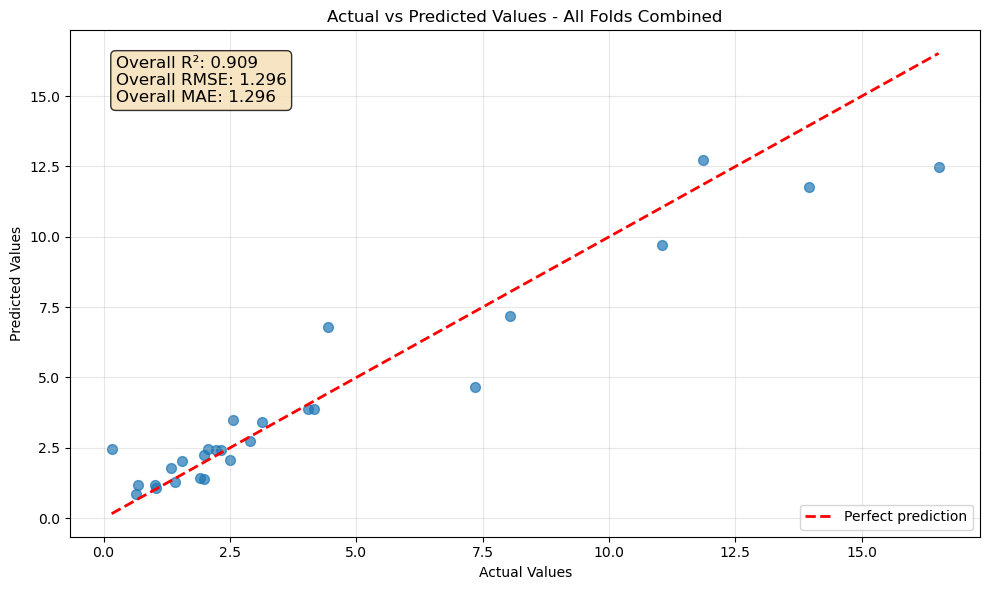


Feature Importance (Permutation Importance):
                           feature  importance
              initial_bulk_density    4.688518
consolidation_:_effective_pressure    0.073663


In [184]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(2626919)
np.random.seed(2626919)

# Load the data
df = final_total.copy()

# Define feature and target columns
feature_cols = [
    'initial_bulk_density',
    'consolidation_:_effective_pressure'
]
target_col = 'failure_stress'

# Drop rows with missing values in features or target
df = df.dropna(subset=feature_cols + [target_col])

print(f"Available samples: {len(df)}")

# Prepare data
X = df[feature_cols].values
y = df[target_col].values

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=2626919)

# Define the ANN model
class ANN(nn.Module):
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Store results for each fold
fold_results = []
all_y_test = []
all_y_pred = []

# 5-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\n=== Fold {fold + 1}/5 ===")
    
    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale the features and target
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled.astype(np.float32))
    y_train_tensor = torch.FloatTensor(y_train_scaled.astype(np.float32))
    X_test_tensor = torch.FloatTensor(X_test_scaled.astype(np.float32))
    y_test_tensor = torch.FloatTensor(y_test_scaled.astype(np.float32))
    
    # Initialize model
    model = ANN(X_train_scaled.shape[1])
    model = model.float()
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 2500
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train_tensor)
        loss = criterion(outputs.squeeze(), y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs.squeeze(), y_test_tensor)
        
        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    # Final prediction and evaluation for this fold
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor).numpy()
    
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_original = y_test
    
    # Calculate metrics
    r2 = r2_score(y_test_original, y_pred)
    rmse = mean_squared_error(y_test_original, y_pred, squared=False)
    mae = mean_squared_error(y_test_original, y_pred, squared=False)
    
    # Store results
    fold_results.append({
        'r2': r2,
        'rmse': rmse,
        'mae': mae
    })
    
    # Store predictions for overall analysis
    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred)
    
    print(f"Fold {fold + 1} Results: R²: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")

# Calculate mean metrics across folds
mean_r2 = np.mean([result['r2'] for result in fold_results])
std_r2 = np.std([result['r2'] for result in fold_results])
mean_rmse = np.mean([result['rmse'] for result in fold_results])
std_rmse = np.std([result['rmse'] for result in fold_results])
mean_mae = np.mean([result['mae'] for result in fold_results])
std_mae = np.std([result['mae'] for result in fold_results])

# Overall metrics
overall_r2 = r2_score(all_y_test, all_y_pred)
overall_rmse = mean_squared_error(all_y_test, all_y_pred, squared=False)
overall_mae = mean_squared_error(all_y_test, all_y_pred, squared=False)

# Print results
print(f"\nMean R²: {mean_r2:.3f} ± {std_r2:.3f}")
print(f"Mean RMSE: {mean_rmse:.3f} ± {std_rmse:.3f}")
print(f"Mean MAE: {mean_mae:.3f} ± {std_mae:.3f}")

print(f"\nOverall Metrics (all folds combined):")
print(f"R²: {overall_r2:.3f}")
print(f"RMSE: {overall_rmse:.3f}")
print(f"MAE: {overall_mae:.3f}")

# Create actual vs predicted plot with metrics inside
plt.figure(figsize=(10, 6))
plt.scatter(all_y_test, all_y_pred, alpha=0.7, s=50)
max_val = max(max(all_y_test), max(all_y_pred))
min_val = min(min(all_y_test), min(all_y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')

# Add metrics text inside the plot
textstr = f'Overall R²: {overall_r2:.3f}\nOverall RMSE: {overall_rmse:.3f}\nOverall MAE: {overall_mae:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - All Folds Combined')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance using the last fold's model
def permutation_importance(model, X_tensor, y_tensor, metric=r2_score, n_repeats=5):
    """Calculate permutation feature importance"""
    model.eval()
    with torch.no_grad():
        baseline_pred = model(X_tensor).numpy()
        baseline_score = metric(y_tensor.numpy(), baseline_pred.flatten())
    
    importance_scores = np.zeros(X_tensor.shape[1])
    
    for feature_idx in range(X_tensor.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_tensor.clone()
            X_permuted[:, feature_idx] = X_permuted[torch.randperm(X_permuted.size(0)), feature_idx]
            
            with torch.no_grad():
                perm_pred = model(X_permuted).numpy()
                score = metric(y_tensor.numpy(), perm_pred.flatten())
                scores.append(score)
        
        importance_scores[feature_idx] = baseline_score - np.mean(scores)
    
    return importance_scores

# Calculate feature importance
feature_importance = permutation_importance(model, X_test_tensor, y_test_tensor, n_repeats=5)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Permutation Importance):")
print(importance_df.to_string(index=False))

# THANK YOU